# Experiments and Results: Evaluation

## Evaluation Functions

In [4]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os 
import pathlib
import glob
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1 import ImageGrid

In [5]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  4


#### Load Datasets and Predictions Functions

In [6]:
# normalize values from [min, max] to [0-1]
def normalize_test(image, idx): 
    min_val = test_min_vals[idx]
    max_val = test_max_vals[idx]
    return (image - (min_val)) / (max_val - min_val)

def denormalize(image, idx): 
    min_val = test_min_vals[idx]
    max_val = test_max_vals[idx]
    return image * (min_val - max_val) + min_val

def denorm(dataset): 
    return [denormalize(x, idx) for idx, x in enumerate(dataset)]

def load_test_dataset_with_degraded_LR(HR_file_path, remove=False): 

    img_dir = HR_file_path
    all_files = os.listdir(img_dir)
    hr_test = [os.path.join(img_dir + "/" + i) for i in all_files]
   

    if remove == True:
        hr_test.remove(hr_test[0])
        
    print('HR Test Samples: ', len(hr_test), 'Files found')

    #load numpy files
    hr_test_ds = [np.load(x) for x in hr_test]

    # get min and max values for each sample pair
    global test_min_vals
    global test_max_vals
    
    test_min_vals = [x.min() for x in hr_test_ds]
    test_max_vals = [x.max() for x in hr_test_ds]

    # normalize dataset
    hr_test_ds = [normalize_test(x, idx) for idx, x in enumerate(hr_test_ds)]

    hr_test_ds = tf.cast(hr_test_ds, tf.float32)
    hr_test_ds = [tf.stack((x,)*3, axis=-1) for x in hr_test_ds]

    lr_test_degraded = [(tf.image.resize(tf.squeeze(x), 
                                 [hr_test_ds[0].shape[0] // Params['scale'],hr_test_ds[0].shape[0] // Params['scale']], 
                                 method=tf.image.ResizeMethod.BICUBIC) )
                        for x in hr_test_ds]
    # convert to tensor
    hr_test_ds = tf.convert_to_tensor(hr_test_ds)
    lr_test_degraded = tf.convert_to_tensor(lr_test_degraded)
    lr_test_ds = lr_test_degraded
    print("HR Dataset Shape: ", hr_test_ds.shape)
    print("Upscale x", Params['scale'], " LR Dataset Shape: ", lr_test_ds.shape)

    lr_test = lr_test_ds
    hr_test = hr_test_ds

    lr_test_denorm = denorm(lr_test_ds)
    hr_test_denorm = denorm(hr_test_ds)
    
    return hr_test, lr_test, lr_test_denorm, hr_test_denorm

In [7]:
def load_dataset_with_real_LR(HR_file_path, LR_file_path, remove=False):
    
    img_dir = HR_file_path
    all_files = os.listdir(img_dir)
    hr_test = [os.path.join(img_dir + "/" + i) for i in all_files]

    if remove == True:
        hr_test.remove(hr_test[0])
        
    print('HR Test Samples: ', len(hr_test), 'Files found')

    #load numpy files
    hr_test_ds = [np.load(x) for x in hr_test]

    img_dir = LR_file_path
    all_files = os.listdir(img_dir)
    lr_test = [os.path.join(img_dir + "/" + i) for i in all_files]
        
    print('LR Test Samples: ', len(lr_test), 'Files found')

    #load numpy files
    lr_test_ds = [np.load(x) for x in lr_test]
    
    # get min and max values for each sample pair
    global test_min_vals
    global test_max_vals
    
    test_min_vals = [x.min() for x in hr_test_ds]
    test_max_vals = [x.max() for x in hr_test_ds]

    # normalize dataset
    hr_test_ds = [normalize_test(x, idx) for idx, x in enumerate(hr_test_ds)]
    hr_test_ds = tf.cast(hr_test_ds, tf.float32)
    hr_test_ds = [tf.stack((x,)*3, axis=-1) for x in hr_test_ds]
    hr_test_ds = tf.convert_to_tensor(hr_test_ds)
    
    lr_test_ds = [normalize_test(x, idx) for idx, x in enumerate(lr_test_ds)]
    lr_test_ds = tf.cast(lr_test_ds, tf.float32)
    lr_test_ds = [tf.stack((x,)*3, axis=-1) for x in lr_test_ds]
    lr_test_ds = tf.convert_to_tensor(lr_test_ds)

    print("HR Dataset Shape: ", hr_test_ds.shape)
    print("Upscale x", Params['scale'], " LR Dataset Shape: ", lr_test_ds.shape)

    lr_test = lr_test_ds
    hr_test = hr_test_ds

    lr_test_denorm = denorm(lr_test_ds)
    hr_test_denorm = denorm(hr_test_ds)
    
    return hr_test, lr_test, lr_test_denorm, hr_test_denorm

In [8]:
def calculate_prediction(lr, model): 
    # caluclate prediction for test ds
    generator = model
    
    fake = []
    for idx, img in enumerate(lr): 

        img = generator(tf.expand_dims(img, axis=0))
        fake.append(img)
        
    return fake

#### Quantitative Evaluation Functions

In [9]:
def calculate_PSNR(prediction, target): 
    ''' calculate PSNR with normalized dataset '''
    
    PSNR_list = []

    for idx, img in enumerate(target): 

        PSNR = tf.image.psnr(tf.clip_by_value(target[idx], 0., 1.), tf.clip_by_value(prediction[idx], 0.,1.), max_val=1.0)
        PSNR_list.append(PSNR)
        
    return PSNR_list


def calculate_SSIM(prediction, target): 
    ''' calculate SSIM with normalized dataset '''
    
    SSIM_list = []

    for idx, img in enumerate(target): 
        SSIM = tf.image.ssim(tf.clip_by_value(target[idx], 0., 1.), tf.clip_by_value(prediction[idx], 0.,1.), max_val=1.0)
        SSIM_list.append(SSIM)
        
    return SSIM_list


#calculate the RMSE
def calculate_RMSE(prediction, target):   
    ''' calculate RMSE with re-mapped dataset '''
    
    RMSE_list = []

    for idx, img in enumerate(target): 
        RMSE = tf.math.sqrt(tf.reduce_mean(tf.math.square(prediction[idx] - target[idx])))
        RMSE_list.append(RMSE)
    return RMSE_list

#calculate the MAE
def calculate_MAE(prediction, target):
    ''' calculate MAE with re-mapped dataset '''
    
    MAE_list = []

    for idx, img in enumerate(target): 
        MAE = tf.reduce_mean(tf.abs(prediction[idx] - target[idx]))
        MAE_list.append(MAE)
    
    return MAE_list

In [10]:
def evaluate_quantitative(prediction, target, remapped_prediction, remapped_target, name='prediction'): 
    
    ''' calculate the quantitative metrics (PSNR, SSIM, RMSE, MAE)'''
    
    print(f"Quantitative Evaluation of {name} method")
    print("_________________________________________________________________________________________")
    
    # PSNR
    PSNR_list = calculate_PSNR(prediction, target) 
    print(f"PSNR value on {name} dataset is                    {tf.reduce_mean(PSNR_list):.3f} dB")
    print(f"PSNR Standard Deviation on {name} dataset is       {tf.math.reduce_std(PSNR_list):.3f} dB")
    print("_________________________________________________________________________________________")
    
    # SSIM
    SSIM_list = calculate_SSIM(prediction, target)
    print(f"SSIM value on {name} dataset is                    {tf.reduce_mean(SSIM_list):.1%} ")
    print(f"SSIM Standard Deviation on {name} dataset is       {tf.math.reduce_std(SSIM_list):.1%}")
    print("_________________________________________________________________________________________")
    
    # RMSE
    RMSE_list = calculate_RMSE(remapped_prediction, remapped_target)
    print(f"RMSE value on {name} dataset is                    {tf.reduce_mean(RMSE_list):.2f} ")
    print(f"RMSE Standard Deviation on {name} dataset is       {tf.math.reduce_std(RMSE_list):.2f}")
    print("_________________________________________________________________________________________")
    
     # RMSE
    MAE_list = calculate_MAE(remapped_prediction, remapped_target)
    print(f"MAE value on {name} dataset is                     {tf.reduce_mean(MAE_list):.2f} ")
    print(f"MAE Standard Deviation on {name} dataset is        {tf.math.reduce_std(MAE_list):.2f}")
    print("_________________________________________________________________________________________")
    
    
    return PSNR_list, RMSE_list 

In [11]:
def plot_RMSE_over_samples(save_directory, dataset_name, *RMSE_lists):
    for RMSE_list, name, color in RMSE_lists: 
        plt.plot(RMSE_list, label=name, color=color)
    
    # plt.plot(bicubic_denorm_rmse_list, label='Bicubic')
    # plt.plot(pred_rmse_list, label='Super-Resolution')

    plt.legend()
    plt.grid()
    plt.xlabel('Samples')
    plt.ylabel('RMSE (meters)')
    scale = Params['scale']
    plt.title(f'{dataset_name} dataset (scale factor: x{scale})')
    os.makedirs(save_directory + '/quantitative_evaluation', exist_ok = True)
    plt.savefig(save_directory + '/quantitative_evaluation/RMSE_over_samples.png')
    plt.close()

def plot_error_distribution(save_directory, *RMSE_lists): 
    
    nrows = len(RMSE_lists)
    n_bins = len(RMSE_lists[0][0])
    fig, axs = plt.subplots(nrows, 1, sharex=True, sharey=True, figsize=(5,4.*nrows), tight_layout=True)
    
    
    colors = ['chocolate', 'gold', 'turquoise', 'teal']
    idx = 0
    for RMSE, name in RMSE_lists: 
        
        axs[idx].hist(np.array(RMSE), bins=n_bins, color=colors[idx])
        axs[idx].axvline(np.mean(RMSE), 
                         color='maroon', 
                         alpha=0.8, 
                         linestyle=':', 
                         label= f'Mean {np.mean(RMSE):.2f}')
        axs[idx].axvline(np.median(RMSE), 
                         color='coral', 
                         alpha=0.8, 
                         linestyle=':', 
                         label= f'Median {np.median(RMSE):.2f}')
        axs[idx].set_title(name)
        axs[idx].legend(loc="upper right")
        axs[idx].grid()
        
        idx +=1

    plt.xlabel('RMSE')
    plt.ylabel('Frequency')
    for ax in axs.flat:
        ax.set(xlabel='RMSE (m)', ylabel='Frequency')
        # ax.xaxis.set_ticks(np.arange(0, 300, 20))
    
    os.makedirs(save_directory + '/quantitative_evaluation', exist_ok = True)
    plt.savefig(save_directory + '/quantitative_evaluation/RMSE_error_distribution.png')
    plt.close()

#### Visual Evaluation Function

In [12]:
def visual_evaluation(save_directory, hr_denorm, lr_denorm, *predictions): 
    
    for idx, img in enumerate(hr_denorm):

        vmin = np.min(hr_denorm[idx])
        vmax = np.max(hr_denorm[idx])
        
        bicubic_denorm = predictions[0][0]
            
        vmin_bi = np.min(hr_denorm[idx][:,:,0] - bicubic_denorm[idx][:,:,0])
        vmax_bi = np.max(hr_denorm[idx][:,:,0] - bicubic_denorm[idx][:,:,0])

        ncols = len(predictions)+1

        fig = plt.figure(figsize=(4.*ncols, 4.*2))
        grid = ImageGrid(fig, 111,  # similar to subplot(111)
                         nrows_ncols=(2, ncols),  # creates 2x2 grid of axes
                         axes_pad=0.25,  # pad between axes in inch.
                        )

        grid[0].imshow(np.array(hr_denorm)[idx][:,:,0], origin="lower", vmin=vmin, vmax=vmax) 
        grid[0].set_title(f'Sample No. {idx+1}: Original')
        grid[0].axis('off')

        padding = Params['hr_dimension']//Params['scale']*(Params['scale']-1)
        grid[ncols].imshow(np.pad(np.array(lr_denorm)[idx][:,:,0], [(0, padding), (padding, 0)], mode='constant', constant_values=np.nan), vmin=vmin, vmax=vmax) 
        grid[ncols].set_title('Real Low-Resolution')
        grid[ncols].axis('off')
        grid[ncols].text(.1, .008, f'\n\n\n\n\n\n\n\n\n\n\nAverage depth: {np.mean((hr_denorm)[idx][:,:,0]):.0f} m  \nDepth difference: {np.max((hr_denorm)[idx][:,:,0]) - np.min((hr_denorm)[idx][:,:,0]):.0f} m', 
                     horizontalalignment='left', verticalalignment='top', fontsize='large')


        index = 1
        alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i']
        for method in predictions: 

            # method = [denorm_images, PSNR, RMSE, name]
            images_denorm = tf.squeeze(method[0])
            images_PSNR = tf.squeeze(method[1])
            images_RMSE = tf.squeeze(method[2])
            name = method[3]

            grid[index].imshow(np.array(images_denorm)[idx][:,:, 0], vmin=vmin, vmax=vmax)
            grid[index].set_title(f'{idx+1}.{alphabet[index-1]}) {name}')
            grid[index].axis('off')
            grid[index].text(.6, .008, f'PSNR {images_PSNR[idx]:.3f} dB | RMSE {images_RMSE[idx]:.2f} m', horizontalalignment='left', verticalalignment='top', fontsize='large')

            grid[ncols+index].imshow(np.array(hr_denorm[idx][:,:,0] - images_denorm[idx][:,:,0]), cmap='seismic', vmin=vmin_bi, vmax=vmax_bi)
            grid[ncols+index].set_title(f'{idx+1}.{alphabet[ncols+index-1]}) Difference Orig. - {name}')
            grid[ncols+index].axis('off')

            index +=1
            if index == ncols: index+=1
        
        plt.savefig(save_directory + '/VE_Pangaea_{}.png'.format(str(idx+1).zfill(2))) 
        plt.close()

#### Domain-Specific Evaluation

In [13]:
def calculate_gradient(dataset): 
    grad_list = []
    
    for x in range(len(dataset)): 
        vgrad = np.gradient(dataset[x][:,:,0]) # image gradient
        grad_list.append(np.sqrt(vgrad[0]**2 + vgrad[1]**2)) # magnitude of image gradient
        
    return grad_list

def evaluate_gradient(prediction, target, name):
    ''' calculate the quantitative metrics of gradient (RMSE, MAE)'''
    
    pred_grad_list = calculate_gradient(prediction)
    target_grad_list = calculate_gradient(target)
    
    grad_RMSE_list = calculate_RMSE(pred_grad_list, target_grad_list)
    grad_MAE_list = calculate_MAE(pred_grad_list, target_grad_list)
    
    print("_________________________________________________________________________________________") 
    print(f"Gradient evaluation of {name} method")
    print(f"RMSE value  is                                     {np.mean(grad_RMSE_list):.2f} m with STD  {np.std(grad_RMSE_list):.2f} m")
    print(f"MAE value  is                                      {np.mean(grad_MAE_list):.2f} m with STD  {np.std(grad_MAE_list):.2f} m")
    print("_________________________________________________________________________________________")
    
    return grad_RMSE_list

In [14]:
def visual_evaluation_gradient(save_directory, hr_denorm, lr_denorm, *predictions): 
     
    hr_gradient = calculate_gradient(tf.squeeze(hr_denorm))
    lr_gradient = calculate_gradient(tf.squeeze(lr_denorm))    
        
    for idx, img in enumerate(hr_gradient):

        vmin = np.min(hr_gradient[idx])
        vmax = np.max(hr_gradient[idx])
        
        bicubic_gradient = calculate_gradient(tf.squeeze(predictions[0][0]))
            
        vmin_bi = np.min(hr_gradient[idx] - bicubic_gradient[idx])
        vmax_bi = np.max(hr_gradient[idx] - bicubic_gradient[idx])

        ncols = len(predictions)+1

        fig = plt.figure(figsize=(4.*ncols, 4.*2))
        grid = ImageGrid(fig, 111, 
                         nrows_ncols=(2, ncols),  
                         axes_pad=0.25, 
                        )

        grid[0].imshow(np.array(hr_gradient)[idx], origin="lower", vmin=vmin, vmax=vmax) 
        grid[0].set_title(f'Sample No. {idx+1}: Original')
        grid[0].axis('off')

        padding = Params['hr_dimension']//Params['scale']*(Params['scale']-1)
        grid[ncols].imshow(np.pad(np.array(lr_gradient)[idx], [(0, padding), (padding, 0)], mode='constant', constant_values=np.nan), vmin=vmin, vmax=vmax) 
        grid[ncols].set_title('Real Low-Resolution')
        grid[ncols].axis('off')
        grid[ncols].text(.1, .008, f'\n\n\n\n\n\n\n\n\n\n\n\nDepth difference: {np.max((hr_denorm)[idx]) - np.min((hr_denorm)[idx]):.0f} m', 
                     horizontalalignment='left', verticalalignment='top', fontsize='large')
        
        
        index = 1
        alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i']
        for method in predictions: 

            # method = [denorm_images, PSNR, RMSE, name]
            images_gradient = calculate_gradient(tf.squeeze(method[0]))
            images_gradient_RMSE = calculate_RMSE(images_gradient, hr_gradient)
            name = method[1]

            grid[index].imshow(np.array(images_gradient)[idx], vmin=vmin, vmax=vmax)
            grid[index].set_title(f'{idx+1}.{alphabet[index-1]}) {name}')
            grid[index].axis('off')
            grid[index].text(.6, .008, f' RMSE {images_gradient_RMSE[idx]:.2f} m', horizontalalignment='left', verticalalignment='top', color='white', fontsize='large')

            grid[ncols+index].imshow(np.array(hr_gradient[idx] - images_gradient[idx]), cmap='seismic', vmin=vmin_bi, vmax=vmax_bi)
            grid[ncols+index].set_title(f'{idx+1}.{alphabet[ncols+index-1]}) Difference Orig. - {name}')
            grid[ncols+index].axis('off')

            index +=1
            if index == ncols: index+=1
        os.makedirs(save_directory + '/VE_gradient', exist_ok = True)
        plt.savefig(save_directory + '/VE_gradient/VE_gradient_{}.png'.format(str(idx+1).zfill(2))) 
        plt.close()

In [15]:
def calc_distance(point1, point2): 
    return np.sqrt((point2[1][0] - point1[1][0])**2 + (point2[1][1] - point1[1][1])**2)

def calculate_peak(image):

    depth_value = np.max(image[:,:,0])
    peak_coordinates = np.unravel_index(np.argmax(image[:,:,0], axis=None), [Params['hr_dimension'],Params['hr_dimension']])
    return (depth_value, peak_coordinates)
        

def calculate_valley(image): 
    
    depth_value = np.min(image[:,:,0])
    valley_coordinates = np.unravel_index(np.argmin(image[:,:,0], axis=None), [Params['hr_dimension'],Params['hr_dimension']])
    return (depth_value, valley_coordinates)

def evaluate_critical_points(prediction, target, name):
    
    pred_peak = [calculate_peak(img) for img in prediction]
    target_peak = [calculate_peak(img) for img in target]
    
    pred_valley = [calculate_valley(img) for img in prediction]
    target_valley = [calculate_valley(img) for img in target]
    
    peak_dist_list = [calc_distance(target_peak[idx], pred_peak[idx]) for idx in range(len(target))]
    valley_dist_list = [calc_distance(target_valley[idx], pred_valley[idx]) for idx in range(len(target))]
    
    print("_________________________________________________________________________________________") 
    print(f"Critical points evaluation of {name} method")
    print("_________________________________________________________________________________________") 
    print(f"Mean displacement of peaks is                     {np.mean(peak_dist_list):.2f} m with STD {np.std(peak_dist_list):.2f} m")
    print(f"Mean displacement of valleys is                   {np.mean(valley_dist_list):.2f} m with STD {np.std(valley_dist_list):.2f} m")
    print(f"Median displacement of peaks is                   {np.median(peak_dist_list):.2f} m")
    print(f"Median displacement of valleys is                 {np.median(valley_dist_list):.2f} m")
 
    
    
    count = 0
    exact = 0
    for i in peak_dist_list: 
        if i < 2: count+=1
        if i == 0 : exact+=1
    
    print(f"Total number of peaks: {len(peak_dist_list)}. \
                       {exact} peaks are exact, {count} peaks are of by less than 2 pixels.")
    
    count = 0
    exact = 0
    for i in valley_dist_list: 
        if i < 2: count+=1
        if i == 0 : exact+=1
    
    print(f"Total number of valleys: {len(valley_dist_list)}. \
                     {exact} valleys are exact, {count} valleys are of by less than 2 pixels.")
    
    print("_________________________________________________________________________________________") 
    
    return (peak_dist_list, valley_dist_list)

In [16]:
def visual_evaluation_critical_points(save_directory, hr_denorm, *methods): 
    for idx in range(len(hr_denorm)):
        # plot the peak and valley on the patch 
        for method in methods: 
            dataset = tf.squeeze(method[0])
            peaks = calculate_peak(dataset[idx])
            peak_coordinates = peaks[1]
            plt.plot(peak_coordinates[1], peak_coordinates[0], marker='^', color = method[2])
           
            valleys = calculate_valley(dataset[idx])
            valley_coordinates = valleys[1]
            plt.plot(valley_coordinates[1], valley_coordinates[0], marker='v', color = method[2])

        peaks = calculate_peak(hr_denorm[idx])
        peak_coordinates = peaks[1]
        plt.plot(peak_coordinates[1], peak_coordinates[0], marker='.', color = 'red')
        valleys = calculate_valley(hr_denorm[idx])
        valley_coordinates = valleys[1]
        plt.plot(valley_coordinates[1], valley_coordinates[0], marker='.', color = 'red')
        plt.imshow(hr_denorm[idx][:,:,0])
        
        os.makedirs(save_directory + '/VE_critical_points', exist_ok = True)
        plt.savefig(save_directory + '/VE_critical_points/VE_CP_{}.png'.format(str(idx+1).zfill(2))) 
        plt.close()

In [17]:
def get_depth_difference_per_sample(dataset):
    ''' returns a list of the depth difference per sample '''
    
    min_vals = [x.min() for x in np.array(dataset)]
    max_vals = [x.max() for x in np.array(dataset)]
    
    return [(max_vals[x] - min_vals[x]) for x in range(len(min_vals))]

In [18]:
def RMSE_depending_on_depth_difference(hr_denorm, method):
    ''' 
        RMSE with changing complexitiy in dataset. 
        complexity defined as depth differences.
        methods = (dataset, name, color, RMSE) '''
    
    depth_difference = get_depth_difference_per_sample(hr_denorm)
    name = method[1]
    RMSE = method[3]

    RMSE_for_depth_difference_lower_500m = []
    RMSE_for_depth_difference_between_500m_and_1000m = []
    RMSE_for_depth_difference_lower_1000m = []
    RMSE_for_depth_difference_higher_1000m = []
    RMSE_for_depth_difference_higher_2000m = []
    RMSE_for_depth_difference_between_1000_and_2000m = []
    RMSE_for_depth_difference_between_2000_and_3000m = []
    RMSE_for_depth_difference_between_3000_and_4000m = []
    RMSE_for_depth_difference_between_4000_and_6000m = []
    RMSE_for_depth_difference_higher_6000m = []
    
    
    for idx, x in enumerate(depth_difference): 
        if x <= 500: 
            RMSE_for_depth_difference_lower_500m.append(RMSE[idx])
        if 500 <= x <= 1000: 
            RMSE_for_depth_difference_between_500m_and_1000m.append(RMSE[idx])
        if x <= 1000: 
            RMSE_for_depth_difference_lower_1000m.append(RMSE[idx]) 
        if x >= 1000: 
            RMSE_for_depth_difference_higher_1000m.append(RMSE[idx])
        if x >= 2000: 
            RMSE_for_depth_difference_higher_2000m.append(RMSE[idx])
        if 1000 <= x <= 2000: 
            RMSE_for_depth_difference_between_1000_and_2000m.append(RMSE[idx])
        if 2000 <= x <= 3000: 
            RMSE_for_depth_difference_between_2000_and_3000m.append(RMSE[idx])
        if 3000 <= x <= 4000: 
            RMSE_for_depth_difference_between_3000_and_4000m.append(RMSE[idx])
        if 4000 <= x <= 6000: 
            RMSE_for_depth_difference_between_3000_and_4000m.append(RMSE[idx])
        if x >= 6000: 
            RMSE_for_depth_difference_higher_6000m.append(RMSE[idx])
            
    print("_________________________________________________________________________________________") 
    print(f'RMSE depending on depth difference analysis: {method[1]}')

    print(f'0- 500 m:  {np.mean(RMSE_for_depth_difference_lower_500m):.2f} | number of samples with depth difference <= 500m: {len(RMSE_for_depth_difference_lower_500m)}.')
    
    print(f'500 - 1000 m: {np.mean(RMSE_for_depth_difference_between_500m_and_1000m):.2f} | number of samples with depth difference 500 - 1000m: {len(RMSE_for_depth_difference_between_500m_and_1000m)}.')
    
    print(f'1000 - 2000 m: {np.mean(RMSE_for_depth_difference_between_1000_and_2000m):.2f} | number of samples with depth difference >= 2000m : {len(RMSE_for_depth_difference_between_1000_and_2000m)}.')

    print(f'2000 - 3000 m: {np.mean(RMSE_for_depth_difference_between_2000_and_3000m):.2f} | number of samples with depth difference >= 2000m : {len(RMSE_for_depth_difference_between_2000_and_3000m)}.')
    
    print(f'3000 - 4000 m: {np.mean(RMSE_for_depth_difference_between_3000_and_4000m):.2f} | number of samples with depth difference >= 2000m : {len(RMSE_for_depth_difference_between_3000_and_4000m)}.')
    
    print(f'4000 - 6000 m: {np.mean(RMSE_for_depth_difference_between_4000_and_6000m):.2f} | number of samples with depth difference >= 2000m : {len(RMSE_for_depth_difference_between_4000_and_6000m)}.')
    
    print(f'>= 6000 m: {np.mean(RMSE_for_depth_difference_higher_6000m):.2f} | number of samples with depth difference >= 2000m : {len(RMSE_for_depth_difference_higher_6000m)}.')
    
    print("____________________") 
    
    print(f'0 - 1000 m: {np.mean(RMSE_for_depth_difference_lower_1000m):.2f} | number of samples with depth difference <= 1000m: {len(RMSE_for_depth_difference_lower_1000m)}.')

    print(f'1000 -inf m: {np.mean(RMSE_for_depth_difference_higher_1000m):.2f} | number of samples with depth difference >= 1000m: {len(RMSE_for_depth_difference_higher_1000m)}.')

    print(f'2000 - inf m: {np.mean(RMSE_for_depth_difference_higher_2000m):.2f} | number of samples with depth difference >= 2000m : {len(RMSE_for_depth_difference_higher_2000m)}.')
    
    RMSE_per_depth_difference = [np.mean(RMSE_for_depth_difference_lower_500m), 
                                 np.mean(RMSE_for_depth_difference_between_500m_and_1000m), 
                                 np.mean(RMSE_for_depth_difference_between_1000_and_2000m),
                                 np.mean(RMSE_for_depth_difference_between_2000_and_3000m),
                                 np.mean(RMSE_for_depth_difference_between_3000_and_4000m),
                                 np.mean(RMSE_for_depth_difference_between_4000_and_6000m),
                                 np.mean(RMSE_for_depth_difference_higher_6000m),
                                ]
    
    return RMSE_per_depth_difference

In [19]:
def get_average_depth_per_sample(dataset): 
    ''' returns a list of the average depth per sample '''
    dataset = np.array(tf.squeeze(dataset))
    return [np.mean(dataset[x]) for x in range(len(dataset))]

In [20]:
def RMSE_depending_on_average_depth(hr_denorm, method):
    
    ''' RMSE at difference depths of the dataset. 
        Methods performs small error at specific depth?
        methods = (dataset, name, color, RMSE) '''
    
    average_depth = get_average_depth_per_sample(hr_denorm)
    name = method[1]
    RMSE = method[3]
    
    average_depth = np.abs(average_depth)
    
    RMSE_at_depth_0_500m = []
    RMSE_at_depth_500_1000m = []
    RMSE_at_depth_1000_2000m = []
    RMSE_at_depth_2000_4000m = []
    RMSE_at_depth_4000_6000m = []
    RMSE_at_depth_6000_8000m = []
    RMSE_at_depth_8000_10000m = []
    RMSE_at_depth_10000_infm = []
    RMSE_at_depth_8000_infm = []
    RMSE_at_depth_6000_infm = []
    
    RMSE_at_depth_0_2000m = []
    
    for idx, x in enumerate(average_depth):
        if x <= 500: 
            RMSE_at_depth_0_500m.append(RMSE[idx])
        if 500 <= x <= 1000: 
            RMSE_at_depth_500_1000m.append(RMSE[idx])
        if 1000 <= x <= 2000: 
            RMSE_at_depth_1000_2000m.append(RMSE[idx])
        if 2000 <= x <= 4000: 
            RMSE_at_depth_2000_4000m.append(RMSE[idx])
        if 4000 <= x <= 6000: 
            RMSE_at_depth_4000_6000m.append(RMSE[idx])
        if 6000 <= x: 
            RMSE_at_depth_6000_infm.append(RMSE[idx])
        if 6000 <= x <= 8000: 
            RMSE_at_depth_6000_8000m.append(RMSE[idx])
        if 8000 <= x <= 10000: 
            RMSE_at_depth_8000_10000m.append(RMSE[idx])
        if x >= 8000:
            RMSE_at_depth_8000_infm.append(RMSE[idx])
        if x <= 2000: 
            RMSE_at_depth_0_2000m.append(RMSE[idx])
        if x >= 10000: 
            RMSE_at_depth_10000_infm.append(RMSE[idx])
            
            
            
    print("_________________________________________________________________________________________") 
    print(f'RMSE depending on average depth analysis: {method[1]}')

    print(f'0 - 500 m:     {np.mean(RMSE_at_depth_0_500m):.2f} | No. samples: {len(RMSE_at_depth_0_500m)}.')
    
    print(f'500 - 1000 m:  {np.mean(RMSE_at_depth_500_1000m):.2f} | No. samples: {len(RMSE_at_depth_500_1000m)}.')
    
    print(f'1000 - 2000 m: {np.mean(RMSE_at_depth_1000_2000m):.2f} | No. samples: {len(RMSE_at_depth_1000_2000m)}.')

    print(f'2000 - 4000 m: {np.mean(RMSE_at_depth_2000_4000m):.2f} | No. samples: {len(RMSE_at_depth_2000_4000m)}.')

    print(f'4000 - 6000 m: {np.mean(RMSE_at_depth_4000_6000m):.2f} | No. samples: {len(RMSE_at_depth_4000_6000m)}.')
    
    print(f'6000 - 8000 m: {np.mean(RMSE_at_depth_6000_8000m):.2f} | No. samples: {len(RMSE_at_depth_6000_8000m)}.')
    
    print(f'8000 - 10000 m: {np.mean(RMSE_at_depth_8000_10000m):.2f} | No. samples: {len(RMSE_at_depth_8000_10000m)}.')
    
    print(f'10000 - inf m: {np.mean(RMSE_at_depth_10000_infm):.2f} | No. samples: {len(RMSE_at_depth_10000_infm)}.')
    
    print(f'6000 - inf m: {np.mean(RMSE_at_depth_6000_infm):.2f} | No. samples: {len(RMSE_at_depth_6000_infm)}.')
    
    print(f'8000 - inf m: {np.mean(RMSE_at_depth_8000_infm):.2f} | No. samples: {len(RMSE_at_depth_8000_infm)}.')
        
    print(f'0 - 2000 m: {np.mean(RMSE_at_depth_0_2000m):.2f} | No. samples: {len(RMSE_at_depth_0_2000m)}.')
    
    RMSE_per_depth =  [np.mean(RMSE_at_depth_0_500m), 
                       np.mean(RMSE_at_depth_500_1000m), 
                       np.mean(RMSE_at_depth_1000_2000m), 
                       np.mean(RMSE_at_depth_2000_4000m), 
                       np.mean(RMSE_at_depth_4000_6000m), 
                       np.mean(RMSE_at_depth_6000_8000m),
                       np.mean(RMSE_at_depth_8000_10000m),
                       np.mean(RMSE_at_depth_10000_infm),
                      ]

    return RMSE_per_depth


In [21]:
def plot_RMSE_over_average_depth(save_directory, RMSE_per_depth, name, color): 
    for x in range(len(name)): 
        plt.plot([500-250, 1000-250, 2000-500, 4000-1000, 6000-1000, 8000-1000, 10000-1000, 11000], 
                 RMSE_per_depth[x],
                 'o', 
                 color=color[x], 
                 label=name[x],
        )
    plt.grid()
    plt.legend()
    plt.savefig(save_directory + '/quantitative_evaluation/RMSE_per_average_depth.png')
    plt.close()

In [22]:
def plot_RMSE_over_depth_difference(save_directory, RMSE_per_depth_difference, name, color): 
    for x in range(len(name)): 
        plt.plot([500-250, 1000-250, 2000-500, 3000-500, 4000-500, 5000, 6500], 
                 RMSE_per_depth_difference[x],
                 'o', 
                 color=color[x], 
                 label=name[x],
        )
    plt.grid()
    plt.legend()
    plt.savefig(save_directory + '/quantitative_evaluation/RMSE_per_depth_difference.png')
    plt.close()

In [23]:
def domain_specific_evaluation(save_directory, hr_denorm, lr_denorm, *methods): 
    ''' methods = (dataset, name, color, RMSE) '''
    RMSE_plot_list = []
    RMSE_per_depth_difference_list = []
    color_list = []
    name_list = []
    
    for method in methods: 
        name = method[1]
        grad = evaluate_gradient(tf.squeeze(method[0]), hr_denorm, name)
        peaks, valleys = evaluate_critical_points(tf.squeeze(method[0]), hr_denorm, name)
        RMSE_per_depth_difference = RMSE_depending_on_depth_difference(hr_denorm, method)
        RMSE_per_depth_difference_list.append(RMSE_per_depth_difference)
        
        RMSE_per_depth = RMSE_depending_on_average_depth(hr_denorm, method)
        RMSE_plot_list.append(RMSE_per_depth)
        color_list.append(method[2])
        name_list.append(name)


    plot_RMSE_over_average_depth(save_directory, RMSE_plot_list, name_list, color_list)
    
    plot_RMSE_over_depth_difference(save_directory, RMSE_per_depth_difference_list, name_list, color_list)
        
    visual_evaluation_gradient(save_directory, hr_denorm, lr_denorm, *methods)
    
    visual_evaluation_critical_points(save_directory, hr_denorm, *methods)

#### Complete Evaluation Function

In [24]:
def complete_quantitative_evaluation(dataset_name, save_directory, HR_file_path, SR_model, SRGAN_model=None, LR_file_path=None, remove=False):
    
    if LR_file_path != None: 
        hr, lr, lr_denorm, hr_denorm = load_dataset_with_real_LR(HR_file_path=HR_file_path, LR_file_path=LR_file_path, remove=remove)
    else: 
        hr, lr, lr_denorm, hr_denorm = load_test_dataset_with_degraded_LR(HR_file_path=HR_file_path, remove=remove)
    
    bicubic = tf.image.resize(lr, [Params['hr_dimension'], Params['hr_dimension']],method=tf.image.ResizeMethod.BICUBIC)
    bicubic_denorm = denorm(bicubic)
    bicubic_PSNR, bicubic_RMSE = evaluate_quantitative(bicubic, hr, bicubic_denorm, hr_denorm, 'Baseline')
    
    bicubic_nohalfpixel = tf.compat.v1.image.resize_bicubic(lr, [Params['hr_dimension'], Params['hr_dimension']])
    bicubic_nohalfpixel_denorm = denorm(bicubic_nohalfpixel)
    bicubic_nohalfpixel_PSNR, bicubic_nohalfpixel_RMSE = evaluate_quantitative(bicubic_nohalfpixel, hr, bicubic_nohalfpixel_denorm, hr_denorm, 'Baseline (no HP)')
    
    SR_pred = calculate_prediction(lr, SR_model)
    SR_pred_denorm = denorm(SR_pred)
    SR_PSNR, SR_RMSE = evaluate_quantitative(SR_pred, hr, SR_pred_denorm, hr_denorm, 'SR')

    if SRGAN_model == None: 
        plot_RMSE_over_samples(save_directory,
                               dataset_name, 
                               (bicubic_RMSE, 'Baseline', 'darkorange'), 
                               (bicubic_nohalfpixel_RMSE, 'Baseline (no HP)', 'gold'),
                               (SR_RMSE, 'SR', 'turquoise' ))
            
        plot_error_distribution(save_directory,
                                (bicubic_RMSE, 'Baseline'), 
                                (bicubic_nohalfpixel_RMSE, 'Baseline (no HP)'),
                                (SR_RMSE, 'SR' ))
        visual_evaluation(save_directory, 
                          hr_denorm, 
                          lr_denorm, 
                          (bicubic_denorm, bicubic_PSNR, bicubic_RMSE, 'Baseline'), 
                          (bicubic_nohalfpixel_denorm, bicubic_nohalfpixel_PSNR, bicubic_nohalfpixel_RMSE, 'Baseline (no HP)'), 
                          (SR_pred_denorm, SR_PSNR, SR_RMSE, 'SR'))
        
        domain_specific_evaluation(save_directory, 
                                   hr_denorm, 
                                   lr_denorm,
                                   (bicubic_denorm, 'Baseline', 'darkorange', bicubic_RMSE),
                                   (bicubic_nohalfpixel_denorm, 'Baseline (no HP)', 'lemonchiffon', bicubic_nohalfpixel_RMSE),
                                   (SR_pred_denorm, 'SR', 'm', SR_RMSE))
        
    else: 
        
        SRGAN_pred = calculate_prediction(lr, SRGAN_model)
        SRGAN_pred_denorm = denorm(SRGAN_pred)
        SRGAN_PSNR, SRGAN_RMSE = evaluate_quantitative(SRGAN_pred, hr, SRGAN_pred_denorm, hr_denorm, 'SRGAN')
    
        plot_RMSE_over_samples(save_directory,
                               dataset_name, 
                               (bicubic_RMSE, 'Baseline', 'darkorange'), 
                               (bicubic_nohalfpixel_RMSE, 'Baseline (no HP)', 'gold'),
                               (SR_RMSE, 'SR', 'turquoise' ), 
                               (SRGAN_RMSE, 'SRGAN', 'teal'))

        plot_error_distribution(save_directory,
                                (bicubic_RMSE, 'Baseline'), 
                                (bicubic_nohalfpixel_RMSE, 'Baseline (no HP)'),
                                (SR_RMSE, 'SR' ), 
                                (SRGAN_RMSE, 'SRGAN'))
        
        
        visual_evaluation(save_directory, hr_denorm, 
                      lr_denorm, 
                      (bicubic_denorm, bicubic_PSNR, bicubic_RMSE, 'Baseline'), 
                      (bicubic_nohalfpixel_denorm, bicubic_nohalfpixel_PSNR, bicubic_nohalfpixel_RMSE, 'Baseline (no HP)'), 
                      (SR_pred_denorm, SR_PSNR, SR_RMSE, 'SR') , 
                      (SRGAN_pred_denorm, SRGAN_PSNR, SRGAN_RMSE, 'SRGAN'))
        
        
        domain_specific_evaluation(save_directory, 
                                   hr_denorm, 
                                   lr_denorm,
                                   (bicubic_denorm, 'Baseline', 'darkorange', bicubic_RMSE), 
                                   (bicubic_nohalfpixel_denorm, 'Baseline (no HP)', 'lemonchiffon', bicubic_nohalfpixel_RMSE),
                                   (SR_pred_denorm, 'SR', 'm', SR_RMSE), 
                                   (SRGAN_pred_denorm, 'SRGAN', 'y', SRGAN_RMSE))
        

-----

# Experiment Evaluation

-----

## Experiment 1: GEBCO

#### Load datasets and models

In [25]:
#GEBCO Datasets
file_paths = {
    'test_x2' : {'HR' : 'datasets/GEBCO/x2/test/HR', 
                 'LR' : 'datasets/GEBCO/x2/test/LR',
                }, 
    'test_x4' : {'HR' : 'datasets/GEBCO/x4/test/HR',
                 'LR' : 'datasets/GEBCO/x4/test/LR',
                },
}

#### Experiment: Upscale x2

In [26]:
SR_x2_model = tf.keras.models.load_model('models/GEBCO_x2')
SRGAN_x2_model = tf.keras.models.load_model('models/GAN_GEBCO_x2/Generator_GEBCO_x2')

2022-09-01 13:32:25.104986: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-01 13:32:25.647552: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:05:00.0 name: TITAN Xp computeCapability: 6.1
coreClock: 1.582GHz coreCount: 30 deviceMemorySize: 11.91GiB deviceMemoryBandwidth: 510.07GiB/s
2022-09-01 13:32:25.648344: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:06:00.0 name: TITAN Xp computeCapability: 6.1
coreClock: 1.582GHz coreCount: 30 deviceMemorySize: 11.91GiB deviceMemoryBandwidth: 510.07GiB/s
2022-09-01 13:32:25.649119: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found

In [27]:
Params = {
    'hr_dimension' : 256,               # Dimension of a High Resolution (HR) Image
    'scale' : 2,                        # Factor by which Low Resolution (LR) Images will be downscaled.
}

HR_file_path = file_paths['test_x2']['HR']
LR_file_path = file_paths['test_x2']['LR']

In [28]:
directory = 'visual_evaluation/GEBCO/x2_GAN'
complete_quantitative_evaluation('GEBCO', directory, HR_file_path, SR_x2_model, SRGAN_x2_model, LR_file_path)

HR Test Samples:  93 Files found
LR Test Samples:  93 Files found
HR Dataset Shape:  (93, 256, 256, 3)
Upscale x 2  LR Dataset Shape:  (93, 128, 128, 3)
Quantitative Evaluation of Baseline method
_________________________________________________________________________________________
PSNR value on Baseline dataset is                    41.524 dB
PSNR Standard Deviation on Baseline dataset is       13.391 dB
_________________________________________________________________________________________
SSIM value on Baseline dataset is                    96.3% 
SSIM Standard Deviation on Baseline dataset is       5.6%
_________________________________________________________________________________________
RMSE value on Baseline dataset is                    38.77 
RMSE Standard Deviation on Baseline dataset is       42.94
_________________________________________________________________________________________
MAE value on Baseline dataset is                     20.68 
MAE Standard Deviatio

2022-09-01 13:33:36.018001: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-09-01 13:33:36.477162: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-09-01 13:33:36.548905: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-09-01 13:33:37.458249: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


Quantitative Evaluation of SR method
_________________________________________________________________________________________
PSNR value on SR dataset is                    40.204 dB
PSNR Standard Deviation on SR dataset is       11.196 dB
_________________________________________________________________________________________
SSIM value on SR dataset is                    96.5% 
SSIM Standard Deviation on SR dataset is       5.2%
_________________________________________________________________________________________
RMSE value on SR dataset is                    39.42 
RMSE Standard Deviation on SR dataset is       41.49
_________________________________________________________________________________________
MAE value on SR dataset is                     21.77 
MAE Standard Deviation on SR dataset is        26.38
_________________________________________________________________________________________
Quantitative Evaluation of SRGAN method
_______________________________________

/opt/miniconda3/envs/first/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/miniconda3/envs/first/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


_________________________________________________________________________________________
Gradient evaluation of Baseline (no HP) method
RMSE value  is                                     9.44 m with STD  6.24 m
MAE value  is                                      4.31 m with STD  2.88 m
_________________________________________________________________________________________
_________________________________________________________________________________________
Critical points evaluation of Baseline (no HP) method
_________________________________________________________________________________________
Mean displacement of peaks is                     29.32 m with STD 48.24 m
Mean displacement of valleys is                   30.97 m with STD 64.46 m
Median displacement of peaks is                   2.24 m
Median displacement of valleys is                 1.41 m
Total number of peaks: 93.                        18 peaks are exact, 40 peaks are of by less than 2 pixels.
Total number of 

#### Experiment: Upscale x4

In [29]:
SR_x4_model = tf.keras.models.load_model('models/GEBCO_x4')

In [30]:
Params = {
    'hr_dimension' : 256,               # Dimension of a High Resolution (HR) Image
    'scale' : 4,                        # Factor by which Low Resolution (LR) Images will be downscaled.
}

HR_file_path = file_paths['test_x4']['HR']
LR_file_path = file_paths['test_x4']['LR']

In [31]:
directory = 'visual_evaluation/GEBCO/x4'
complete_quantitative_evaluation(dataset_name='GEBCO', 
                                 save_directory=directory, 
                                 HR_file_path=HR_file_path, 
                                 SR_model=SR_x4_model, 
                                 LR_file_path=LR_file_path)

HR Test Samples:  93 Files found
LR Test Samples:  93 Files found
HR Dataset Shape:  (93, 256, 256, 3)
Upscale x 4  LR Dataset Shape:  (93, 64, 64, 3)
Quantitative Evaluation of Baseline method
_________________________________________________________________________________________
PSNR value on Baseline dataset is                    22.411 dB
PSNR Standard Deviation on Baseline dataset is       4.607 dB
_________________________________________________________________________________________
SSIM value on Baseline dataset is                    83.1% 
SSIM Standard Deviation on Baseline dataset is       11.1%
_________________________________________________________________________________________
RMSE value on Baseline dataset is                    216.77 
RMSE Standard Deviation on Baseline dataset is       122.28
_________________________________________________________________________________________
MAE value on Baseline dataset is                     147.51 
MAE Standard Deviati

#### Experiment: real vs. degraded x2

In [32]:
SR_x2_degraded_model = tf.keras.models.load_model('models/GEBCO_x2_degraded')

In [33]:
Params = {
    'hr_dimension' : 256,               # Dimension of a High Resolution (HR) Image
    'scale' : 2,                        # Factor by which Low Resolution (LR) Images will be downscaled.
}

HR_file_path = file_paths['test_x2']['HR']
LR_file_path = file_paths['test_x2']['LR']

In [ ]:
directory = 'visual_evaluation/GEBCO/x2_SR_trained_with_degraded_LR'
complete_quantitative_evaluation(dataset_name='GEBCO', 
                                 save_directory=directory, 
                                 HR_file_path=HR_file_path, 
                                 SR_model=SR_x2_degraded_model, 
                                 LR_file_path=LR_file_path)

HR Test Samples:  93 Files found
LR Test Samples:  93 Files found
HR Dataset Shape:  (93, 256, 256, 3)
Upscale x 2  LR Dataset Shape:  (93, 128, 128, 3)
Quantitative Evaluation of Baseline method
_________________________________________________________________________________________
PSNR value on Baseline dataset is                    41.524 dB
PSNR Standard Deviation on Baseline dataset is       13.391 dB
_________________________________________________________________________________________
SSIM value on Baseline dataset is                    96.3% 
SSIM Standard Deviation on Baseline dataset is       5.6%
_________________________________________________________________________________________
RMSE value on Baseline dataset is                    38.77 
RMSE Standard Deviation on Baseline dataset is       42.94
_________________________________________________________________________________________
MAE value on Baseline dataset is                     20.68 
MAE Standard Deviatio

In [ ]:
directory = 'visual_evaluation/GEBCO/degraded_test_ds/x2_SR_trained_with_degraded_LR'
complete_quantitative_evaluation(dataset_name='GEBCO', 
                                 save_directory=directory, 
                                 HR_file_path=HR_file_path, 
                                 SR_model=SR_x2_degraded_model)

#### Experiment: real vs. degraded x4

In [ ]:
SR_x4_degraded_model = tf.keras.models.load_model('models/GEBCO_x4_degraded')

In [ ]:
Params = {
    'hr_dimension' : 256,               # Dimension of a High Resolution (HR) Image
    'scale' : 4,                        # Factor by which Low Resolution (LR) Images will be downscaled.
}

HR_file_path = file_paths['test_x4']['HR']
LR_file_path = file_paths['test_x4']['LR']

In [ ]:
directory = 'visual_evaluation/GEBCO/x4_SR_trained_with_degraded_LR'
complete_quantitative_evaluation(dataset_name='GEBCO', 
                                 save_directory=directory, 
                                 HR_file_path=HR_file_path, 
                                 SR_model=SR_x4_degraded_model, 
                                 LR_file_path=LR_file_path)

In [ ]:
directory = 'visual_evaluation/GEBCO/degraded_test_ds/x4_SR_trained_with_degraded_LR'
complete_quantitative_evaluation(dataset_name='GEBCO', 
                                 save_directory=directory, 
                                 HR_file_path=HR_file_path, 
                                 SR_model=SR_x4_degraded_model)

----

## Experiment 2: Pangaea

#### Load datasets and models

In [33]:
#Pangaea Datasets
file_paths = {
    'HR_test_256' : 'datasets/Pangaea/256/test/HR', 
    'HR_test_128' : 'datasets/Pangaea/128/test/HR', 
}

#### Experiment: Upscale x4 (inklusive GAN)

In [ ]:
SR_256_x4_model = tf.keras.models.load_model('models/Generator_Pangaea_256_x4')

In [216]:
SR_256_x4_model = tf.keras.models.load_model('models/Generator_Pangaea_256_x4')
SRGAN_256_x4_model = tf.keras.models.load_model('models/GAN_Pangaea/Generator_Pangaea_256_x4')

In [217]:
Params = {
    'hr_dimension' : 256,               # Dimension of a High Resolution (HR) Image
    'scale' : 4,                        # Factor by which Low Resolution (LR) Images will be downscaled.
}

HR_file_path = file_paths['HR_test_256']

In [24]:
directory = 'visual_evaluation/Pangaea/256_x4_GAN'
complete_quantitative_evaluation(dataset_name='Pangaea', 
                                 save_directory=directory, 
                                 HR_file_path=HR_file_path, 
                                 SR_model=SR_256_x4_model, 
                                 SRGAN_model=SRGAN_256_x4_model)

HR Test Samples:  16 Files found
HR Dataset Shape:  (16, 256, 256, 3)
Upscale x 4  LR Dataset Shape:  (16, 64, 64, 3)
Quantitative Evaluation of Baseline method
_________________________________________________________________________________________
PSNR value on Baseline dataset is                    44.907 dB
PSNR Standard Deviation on Baseline dataset is       3.558 dB
_________________________________________________________________________________________
SSIM value on Baseline dataset is                    98.7% 
SSIM Standard Deviation on Baseline dataset is       2.0%
_________________________________________________________________________________________
RMSE value on Baseline dataset is                    4.56 
RMSE Standard Deviation on Baseline dataset is       5.29
_________________________________________________________________________________________
MAE value on Baseline dataset is                     2.15 
MAE Standard Deviation on Baseline dataset is        2.96
__

2022-08-01 13:20:39.015840: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-08-01 13:20:39.897422: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-08-01 13:20:40.015866: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-08-01 13:20:41.543504: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


Quantitative Evaluation of SR method
_________________________________________________________________________________________
PSNR value on SR dataset is                    45.162 dB
PSNR Standard Deviation on SR dataset is       3.743 dB
_________________________________________________________________________________________
SSIM value on SR dataset is                    98.6% 
SSIM Standard Deviation on SR dataset is       2.1%
_________________________________________________________________________________________
RMSE value on SR dataset is                    4.50 
RMSE Standard Deviation on SR dataset is       5.23
_________________________________________________________________________________________
MAE value on SR dataset is                     2.18 
MAE Standard Deviation on SR dataset is        2.92
_________________________________________________________________________________________
Quantitative Evaluation of SRGAN method
____________________________________________

/opt/miniconda3/envs/first/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/miniconda3/envs/first/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


_________________________________________________________________________________________
Critical points evaluation of SR method
_________________________________________________________________________________________
Mean displacement of peaks is                     48.95 m with STD 74.36 m
Mean displacement of valleys is                   35.72 m with STD 73.57 m
Median displacement of peaks is                   12.75 m
Median displacement of valleys is                 1.83 m
Total number of peaks: 16.                        1 peaks are exact, 6 peaks are of by less than 2 pixels.
Total number of valleys: 16.                      3 valleys are exact, 8 valleys are of by less than 2 pixels.
_________________________________________________________________________________________
_________________________________________________________________________________________
RMSE depending on depth difference analysis: SR
0- 500 m:  2.36 | number of samples with depth difference <= 500m: 6.

#### Experiment: Upscale x2

In [24]:
SR_256_x2_model = tf.keras.models.load_model('models/Generator_Pangaea_256_x2')
SRGAN_256_x2_model = tf.keras.models.load_model('models/GAN_Pangaea/Generator_Pangaea_256_x2_49000')

2022-08-25 13:08:21.701363: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-25 13:08:22.274268: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:05:00.0 name: TITAN Xp computeCapability: 6.1
coreClock: 1.582GHz coreCount: 30 deviceMemorySize: 11.91GiB deviceMemoryBandwidth: 510.07GiB/s
2022-08-25 13:08:22.276012: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:06:00.0 name: TITAN Xp computeCapability: 6.1
coreClock: 1.582GHz coreCount: 30 deviceMemorySize: 11.91GiB deviceMemoryBandwidth: 510.07GiB/s
2022-08-25 13:08:22.277644: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found

In [25]:
Params = {
    'hr_dimension' : 256,               # Dimension of a High Resolution (HR) Image
    'scale' : 2,                        # Factor by which Low Resolution (LR) Images will be downscaled 
}

file_path = file_paths['HR_test_256']

In [27]:
directory = 'visual_evaluation/Pangaea/256_x2'
complete_quantitative_evaluation(dataset_name='Pangaea', 
                                 save_directory=directory, 
                                 HR_file_path=file_path, 
                                 SR_model=SR_256_x2_model,
                                 SRGAN_model=SRGAN_256_x2_model
                                )

HR Test Samples:  16 Files found
HR Dataset Shape:  (16, 256, 256, 3)
Upscale x 2  LR Dataset Shape:  (16, 128, 128, 3)
Quantitative Evaluation of Baseline method
_________________________________________________________________________________________
PSNR value on Baseline dataset is                    56.891 dB
PSNR Standard Deviation on Baseline dataset is       4.883 dB
_________________________________________________________________________________________
SSIM value on Baseline dataset is                    99.8% 
SSIM Standard Deviation on Baseline dataset is       0.3%
_________________________________________________________________________________________
RMSE value on Baseline dataset is                    1.51 
RMSE Standard Deviation on Baseline dataset is       2.71
_________________________________________________________________________________________
MAE value on Baseline dataset is                     0.69 
MAE Standard Deviation on Baseline dataset is        1.21


2022-08-25 13:11:21.594041: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-08-25 13:11:22.079062: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-08-25 13:11:22.147676: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-08-25 13:11:23.035802: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


Quantitative Evaluation of SR method
_________________________________________________________________________________________
PSNR value on SR dataset is                    55.905 dB
PSNR Standard Deviation on SR dataset is       5.830 dB
_________________________________________________________________________________________
SSIM value on SR dataset is                    99.8% 
SSIM Standard Deviation on SR dataset is       0.3%
_________________________________________________________________________________________
RMSE value on SR dataset is                    1.91 
RMSE Standard Deviation on SR dataset is       2.57
_________________________________________________________________________________________
MAE value on SR dataset is                     0.68 
MAE Standard Deviation on SR dataset is        1.13
_________________________________________________________________________________________
Quantitative Evaluation of SRGAN method
____________________________________________

/opt/miniconda3/envs/first/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/miniconda3/envs/first/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


_________________________________________________________________________________________
Gradient evaluation of SR method
RMSE value  is                                     1.71 m with STD  2.96 m
MAE value  is                                      0.53 m with STD  0.92 m
_________________________________________________________________________________________
_________________________________________________________________________________________
Critical points evaluation of SR method
_________________________________________________________________________________________
Mean displacement of peaks is                     72.90 m with STD 84.78 m
Mean displacement of valleys is                   9.60 m with STD 32.84 m
Median displacement of peaks is                   17.34 m
Median displacement of valleys is                 1.00 m
Total number of peaks: 16.                        2 peaks are exact, 6 peaks are of by less than 2 pixels.
Total number of valleys: 16.                  

#### Experiment: Upscale x8 

In [120]:
SR_256_x8_model = tf.keras.models.load_model('models/Generator_Pangaea_256_x8')
SRGAN_256_x8_model = tf.keras.models.load_model('models/GAN_Pangaea/Generator_Pangaea_256_x8_49000')

In [130]:
Params = {
    'hr_dimension' : 256,               # Dimension of a High Resolution (HR) Image
    'scale' : 8,                        # Factor by which Low Resolution (LR) Images will be downscaled.
}

file_path = file_paths['HR_test_256']

In [24]:
directory = 'visual_evaluation/Pangaea/256_x8'
complete_quantitative_evaluation(dataset_name='Pangaea', 
                                 save_directory=directory, 
                                 HR_file_path=file_path, 
                                 SR_model=SR_256_x8_model, 
                                 SRGAN_model=SRGAN_256_x8_model)

HR Test Samples:  16 Files found
HR Dataset Shape:  (16, 256, 256, 3)
Upscale x 8  LR Dataset Shape:  (16, 32, 32, 3)
Quantitative Evaluation of Baseline method
_________________________________________________________________________________________
PSNR value on Baseline dataset is                    36.110 dB
PSNR Standard Deviation on Baseline dataset is       2.567 dB
_________________________________________________________________________________________
SSIM value on Baseline dataset is                    96.0% 
SSIM Standard Deviation on Baseline dataset is       3.5%
_________________________________________________________________________________________
RMSE value on Baseline dataset is                    11.26 
RMSE Standard Deviation on Baseline dataset is       8.81
_________________________________________________________________________________________
MAE value on Baseline dataset is                     5.29 
MAE Standard Deviation on Baseline dataset is        6.23
_

2022-08-03 15:44:18.711107: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-08-03 15:44:19.507245: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-08-03 15:44:19.602258: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-08-03 15:44:20.846475: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


Quantitative Evaluation of SR method
_________________________________________________________________________________________
PSNR value on SR dataset is                    36.290 dB
PSNR Standard Deviation on SR dataset is       2.811 dB
_________________________________________________________________________________________
SSIM value on SR dataset is                    95.7% 
SSIM Standard Deviation on SR dataset is       3.4%
_________________________________________________________________________________________
RMSE value on SR dataset is                    12.50 
RMSE Standard Deviation on SR dataset is       8.96
_________________________________________________________________________________________
MAE value on SR dataset is                     5.63 
MAE Standard Deviation on SR dataset is        6.18
_________________________________________________________________________________________
Quantitative Evaluation of SRGAN method
___________________________________________

/opt/miniconda3/envs/first/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/miniconda3/envs/first/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


MAE value  is                                      2.41 m with STD  2.69 m
_________________________________________________________________________________________
_________________________________________________________________________________________
Critical points evaluation of SR method
_________________________________________________________________________________________
Mean displacement of peaks is                     82.88 m with STD 74.39 m
Mean displacement of valleys is                   53.26 m with STD 66.81 m
Median displacement of peaks is                   53.59 m
Median displacement of valleys is                 8.03 m
Total number of peaks: 16.                        0 peaks are exact, 1 peaks are of by less than 2 pixels.
Total number of valleys: 16.                      1 valleys are exact, 4 valleys are of by less than 2 pixels.
_________________________________________________________________________________________
__________________________________________

#### Experiment: different patch size -- 128 dataset (x4)

In [31]:
SR_128_x4_model = tf.keras.models.load_model('models/Generator_Pangaea_128_x4')

In [32]:
Params = {
    'hr_dimension' : 128,               # Dimension of a High Resolution (HR) Image
    'scale' : 4,                        # Factor by which Low Resolution (LR) Images will be downscaled.
}

file_path = file_paths['HR_test_128']

In [33]:
directory = 'visual_evaluation/Pangaea/128_x4'
complete_quantitative_evaluation(dataset_name='Pangaea', 
                                 save_directory=directory, 
                                 HR_file_path=file_path, 
                                 SR_model=SR_128_x4_model,
                                 SRGAN_model=None,
                                 LR_file_path=None,
                                 remove=True)

HR Test Samples:  39 Files found
HR Dataset Shape:  (39, 128, 128, 3)
Upscale x 4  LR Dataset Shape:  (39, 32, 32, 3)
Quantitative Evaluation of Baseline method
_________________________________________________________________________________________
PSNR value on Baseline dataset is                    40.242 dB
PSNR Standard Deviation on Baseline dataset is       4.620 dB
_________________________________________________________________________________________
SSIM value on Baseline dataset is                    96.3% 
SSIM Standard Deviation on Baseline dataset is       5.1%
_________________________________________________________________________________________
RMSE value on Baseline dataset is                    2.25 
RMSE Standard Deviation on Baseline dataset is       1.43
_________________________________________________________________________________________
MAE value on Baseline dataset is                     1.10 
MAE Standard Deviation on Baseline dataset is        0.56
__

#### Experiment: different patch size -- 128 dataset (x8)

In [34]:
SR_128_x8_model = tf.keras.models.load_model('models/Generator_Pangaea_128_x8')

In [35]:
Params = {
    'hr_dimension' : 128,               # Dimension of a High Resolution (HR) Image
    'scale' : 8,                        # Factor by which Low Resolution (LR) Images will be downscaled.
}

file_path = file_paths['HR_test_128']

In [36]:
directory = 'visual_evaluation/Pangaea/128_x8'
complete_quantitative_evaluation(dataset_name='Pangaea', 
                                 save_directory=directory, 
                                 HR_file_path=file_path, 
                                 SR_model=SR_128_x8_model,
                                 SRGAN_model=None,
                                 LR_file_path=None,
                                 remove=True)

HR Test Samples:  39 Files found
HR Dataset Shape:  (39, 128, 128, 3)
Upscale x 8  LR Dataset Shape:  (39, 16, 16, 3)
Quantitative Evaluation of Baseline method
_________________________________________________________________________________________
PSNR value on Baseline dataset is                    32.667 dB
PSNR Standard Deviation on Baseline dataset is       4.092 dB
_________________________________________________________________________________________
SSIM value on Baseline dataset is                    90.5% 
SSIM Standard Deviation on Baseline dataset is       9.7%
_________________________________________________________________________________________
RMSE value on Baseline dataset is                    6.04 
RMSE Standard Deviation on Baseline dataset is       4.54
_________________________________________________________________________________________
MAE value on Baseline dataset is                     2.90 
MAE Standard Deviation on Baseline dataset is        1.91
__

## Interactive LINE plots

- choose image 
- choose upscale or 3 different plots per scale
- choose line - x and y evtl.? 
- choose which predictions should be plotted 

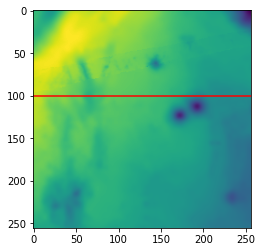

In [268]:
image = 12
h_line = 100
plt.imshow(np.array(hr_denorm)[image,:,:,0])
plt.axhline(h_line,color='red')

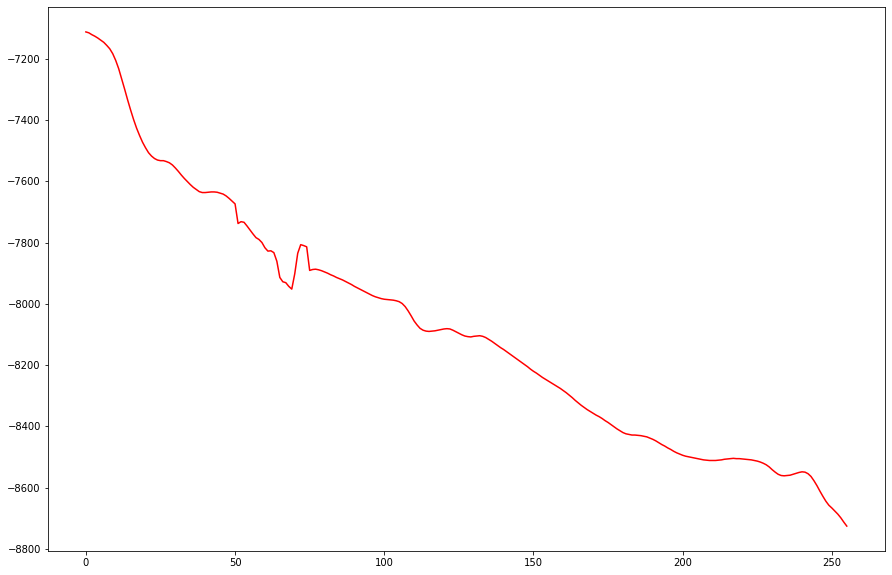

In [272]:
plt.figure(figsize=(15,10))
a = np.array(hr_denorm)[image,:,h_line,0]
plt.plot(a, label='Original', color='red')

(492, 636, 3)


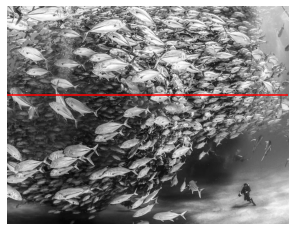

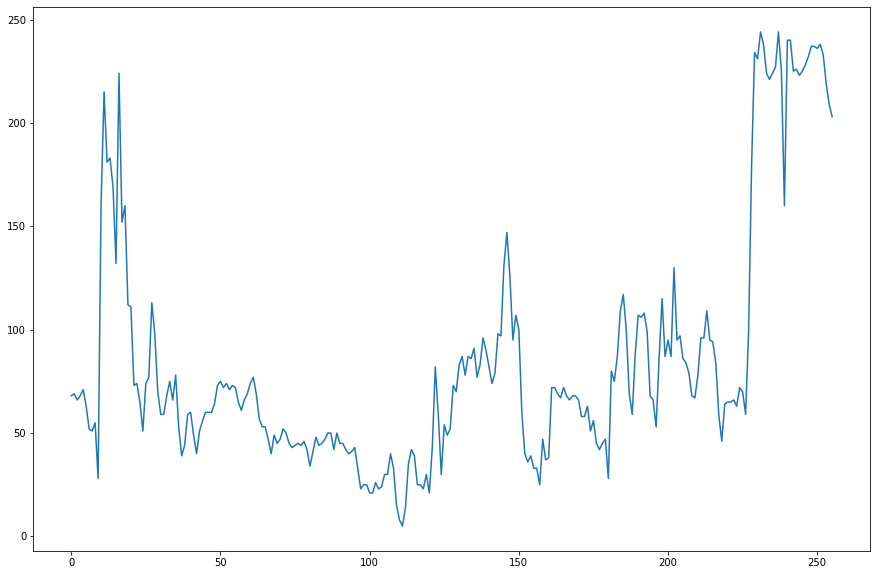

In [304]:
nat_image = plt.imread('natural_image.jpg')
plt.imshow(nat_image[:,:,1],cmap='gray')
plt.axis('off')
print(nat_image.shape)
plt.axhline(200, color='red')
plt.figure(figsize=(15,10))
plt.plot(nat_image[200,100:356,1])

In [296]:
hr, lr_degraded, lr_denorm, hr_denorm = load_test_dataset_with_degraded_LR(HR_file_path=HR_file_path)

lr_degraded = tf.image.resize(lr_degraded, [Params['hr_dimension'], Params['hr_dimension']],method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
lr_degraded_denorm = denorm(lr_degraded)

HR Test Samples:  93 Files found
HR Dataset Shape:  (93, 256, 256, 3)
Upscale x 2  LR Dataset Shape:  (93, 128, 128, 3)


In [ ]:
hr, lr_real, lr_real_denorm, hr_denorm = load_dataset_with_real_LR(HR_file_path=HR_file_path, LR_file_path=LR_file_path)

lr_real = tf.image.resize(lr_real, [Params['hr_dimension'], Params['hr_dimension']],method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
lr_real_denorm = denorm(lr_real)

In [297]:
hr, lr, lr_denorm, hr_denorm = load_test_dataset_with_degraded_LR(HR_file_path=HR_file_path)
#hr, lr, lr_denorm, hr_denorm = load_dataset_with_real_LR(HR_file_path=HR_file_path, LR_file_path=LR_file_path)

lr_test = tf.image.resize(lr, [Params['hr_dimension'], Params['hr_dimension']],method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
lr_test_denorm = denorm(lr_test)

hr, lr_real, lr_real_denorm, hr_denorm = load_dataset_with_real_LR(HR_file_path=HR_file_path, LR_file_path=LR_file_path)

lr_real = tf.image.resize(lr_real, [Params['hr_dimension'], Params['hr_dimension']],method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
lr_real_denorm = denorm(lr_real)


bicubic = tf.image.resize(lr, [Params['hr_dimension'], Params['hr_dimension']],method=tf.image.ResizeMethod.BICUBIC)
bicubic_denorm = denorm(bicubic)

bicubic_nohalfpixel = tf.compat.v1.image.resize_bicubic(lr, [Params['hr_dimension'], Params['hr_dimension']])
bicubic_nohalfpixel_denorm = denorm(bicubic_nohalfpixel)

SR_pred = calculate_prediction(lr, SR_x2_model)
SR_pred_denorm = denorm(SR_pred)

SRGAN_pred = calculate_prediction(lr, SRGAN_x2_model)
SRGAN_pred_denorm = denorm(SRGAN_pred)

HR Test Samples:  93 Files found
HR Dataset Shape:  (93, 256, 256, 3)
Upscale x 2  LR Dataset Shape:  (93, 128, 128, 3)
HR Test Samples:  93 Files found
LR Test Samples:  93 Files found
HR Dataset Shape:  (93, 256, 256, 3)
Upscale x 2  LR Dataset Shape:  (93, 128, 128, 3)


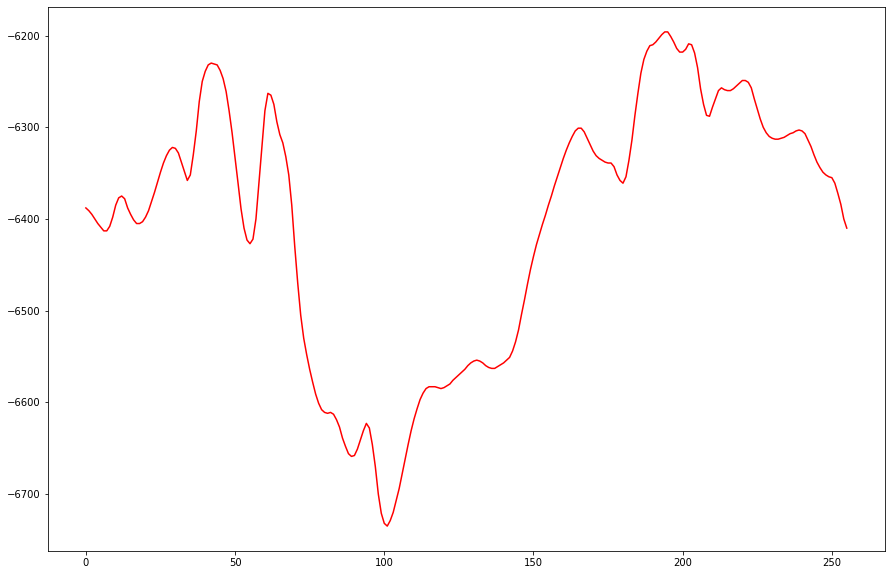

In [310]:
image =30
v_line=110
h_line = 10
a = np.array(hr_denorm)[image,:,v_line,0]
plt.figure(figsize=(15,10))
plt.plot(a, label='Original', color='red')

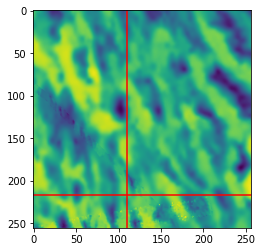

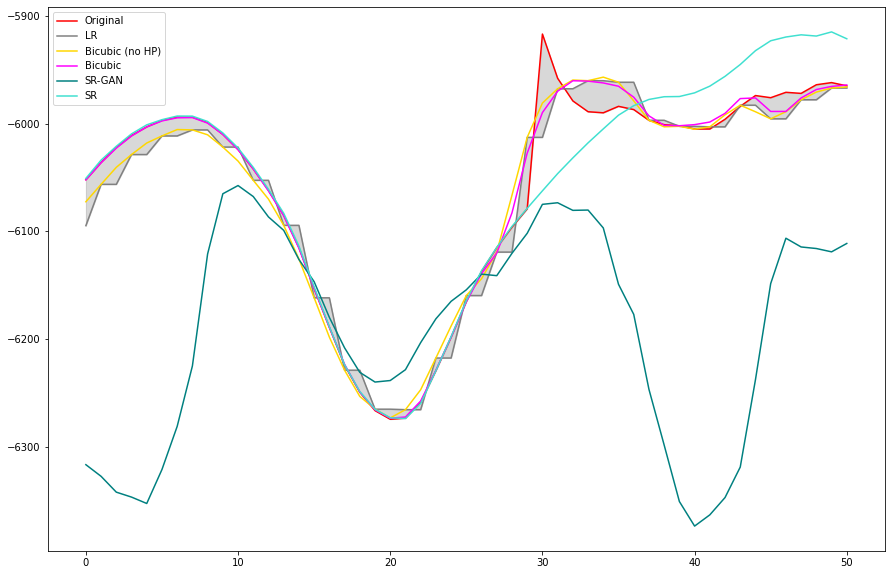

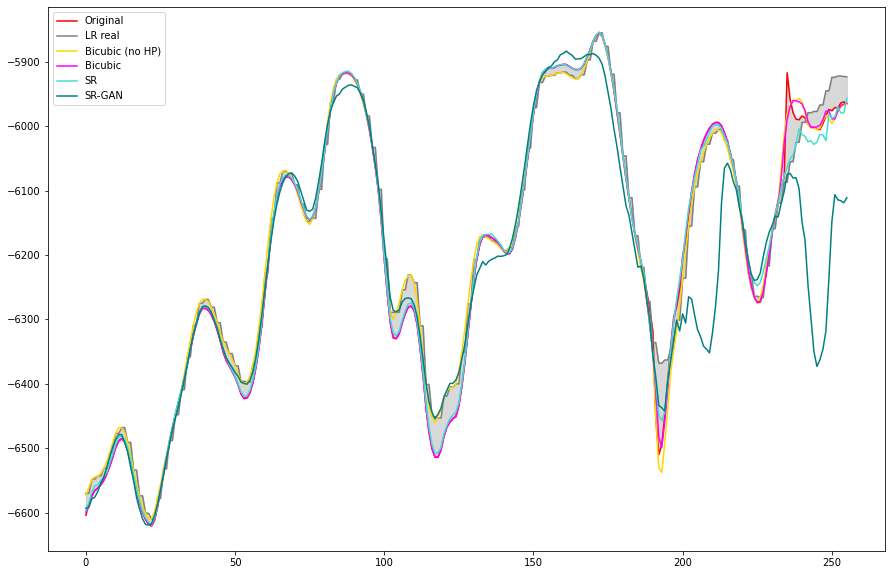

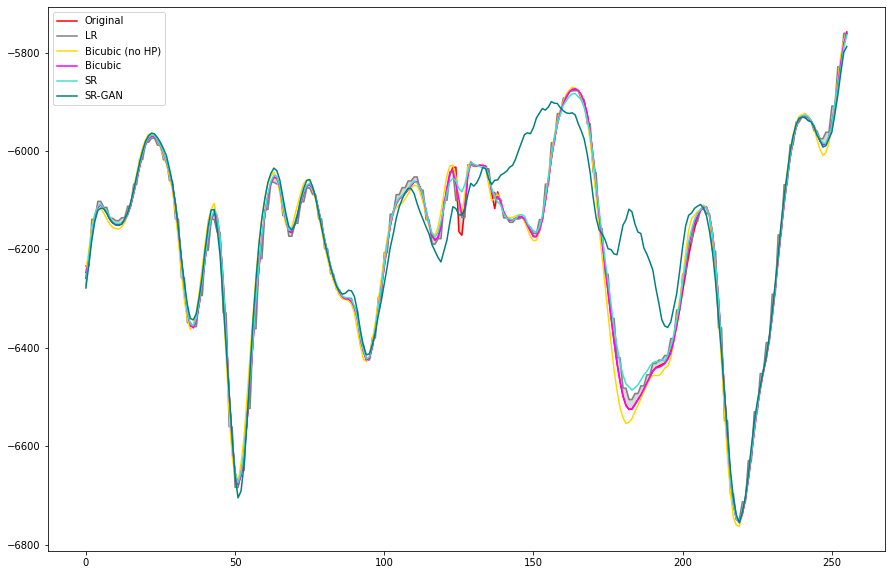

In [323]:
image =33
v_line=110
h_line = 217

plt.imshow(np.array(hr_denorm)[image,:,:,0])
plt.axvline(v_line,color='red')
plt.axhline(h_line,color='red')

x1_min = 205
x1_max = 256

a = np.array(hr_denorm)[image,x1_min:x1_max,v_line,0]
b = np.array(lr_test_denorm)[image,x1_min:x1_max,v_line,0]
x = np.arange(0,x1_max - x1_min,1)

plt.figure(figsize=(15,10))
plt.plot(a, label='Original', color='red')
plt.plot(b, label='LR', color='gray')
plt.fill_between(x, a, b, color ='gray', alpha=0.3)

plt.plot(np.array(bicubic_nohalfpixel_denorm)[image,x1_min:x1_max,v_line,0], label='Bicubic (no HP)', color='gold')
plt.plot(np.array(bicubic_denorm)[image,x1_min:x1_max,v_line,0], label='Bicubic', color='magenta')
#plt.plot(np.array(tf.squeeze(SR_pred_denorm))[image,x1_min:x1_max,v_line, 0 ], label='SR (trained with real LR)', color='turquoise') 
plt.plot(np.array(tf.squeeze(SRGAN_pred_denorm))[image,x1_min:x1_max,v_line, 0], label='SR-GAN', color='teal')
plt.plot(np.array(tf.squeeze(SR_degraded_pred_denorm))[image,x1_min:x1_max,v_line, 0], label='SR', color='turquoise')
plt.legend()

a = np.array(hr_denorm)[image,:,v_line,0]
#b = np.array(lr_test_denorm)[image,:,v_line,0]
c = np.array(lr_real_denorm)[image,:,v_line,0]
x = np.arange(0,256,1)

plt.figure(figsize=(15,10))
plt.plot(a, label='Original', color='red')

plt.plot(c, label='LR real', color='gray')
#plt.plot(b, label='LR artificially degraded', color='gray')
#plt.fill_between(x, a, b, color ='magenta', alpha=0.3)
plt.fill_between(x, a, c, color ='gray', alpha=0.3)
plt.plot(np.array(bicubic_nohalfpixel_denorm)[image,:,v_line,0], label='Bicubic (no HP)', color='gold')
plt.plot(np.array(bicubic_denorm)[image,:,v_line,0], label='Bicubic', color='magenta')
plt.plot(np.array(tf.squeeze(SR_pred_denorm))[image,:,v_line, 0 ], label='SR', color='turquoise') 
plt.plot(np.array(tf.squeeze(SRGAN_pred_denorm))[image,:,v_line, 0], label='SR-GAN', color='teal')
plt.legend()

a = np.array(hr_denorm)[image,h_line,:,0]
b = np.array(lr_test_denorm)[image,h_line,:,0]
x = np.arange(0,256,1)

plt.figure(figsize=(15,10))
plt.plot(a, label='Original', color='red')
plt.plot(b, label='LR', color='gray')
plt.fill_between(x, a, b, color ='gray', alpha=0.3)
plt.plot(np.array(bicubic_nohalfpixel_denorm)[image,h_line,:,0], label='Bicubic (no HP)', color='gold')
plt.plot(np.array(bicubic_denorm)[image,h_line,:,0], label='Bicubic', color='magenta')
plt.plot(np.array(tf.squeeze(SR_pred_denorm))[image,h_line,:, 0 ], label='SR', color='turquoise') 
plt.plot(np.array(tf.squeeze(SRGAN_pred_denorm))[image,h_line,:, 0], label='SR-GAN', color='teal')
plt.legend()

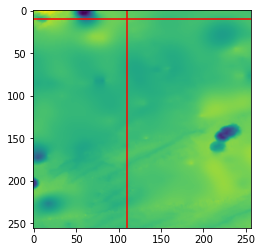

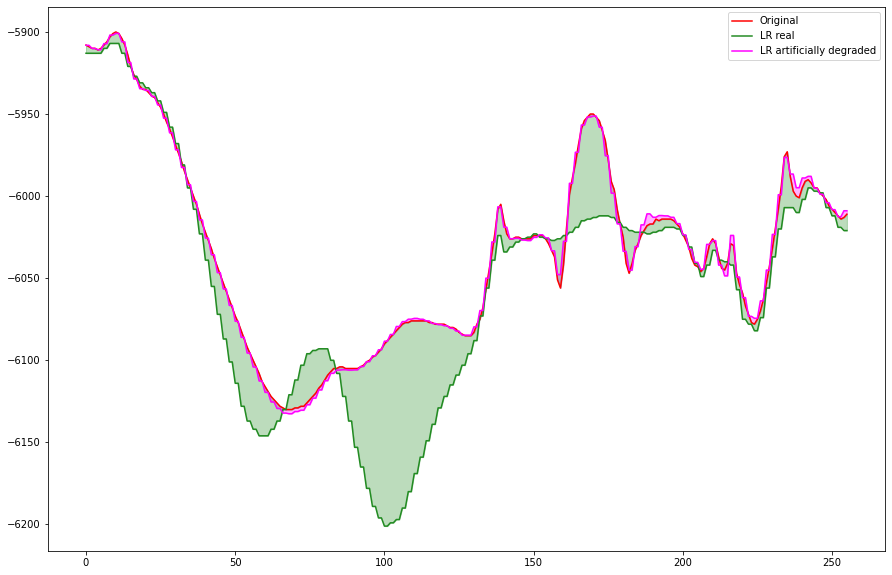

In [302]:
image =78
v_line=110
h_line = 10

plt.imshow(np.array(hr_denorm)[image,:,:,0])
plt.axvline(v_line,color='red')
plt.axhline(h_line,color='red')

a = np.array(hr_denorm)[image,:,v_line,0]
b = np.array(lr_test_denorm)[image,:,v_line,0]
c = np.array(lr_real_denorm)[image,:,v_line,0]
x = np.arange(0,256,1)

plt.figure(figsize=(15,10))
plt.plot(a, label='Original', color='red')

plt.plot(c, label='LR real', color='forestgreen')
plt.plot(b, label='LR artificially degraded', color='magenta')
plt.fill_between(x, a, b, color ='magenta', alpha=0.3)
plt.fill_between(x, a, c, color ='forestgreen', alpha=0.3)
#plt.plot(np.array(bicubic_nohalfpixel_denorm)[image,:,v_line,0], label='Bicubic (no HP)', color='gold')
#plt.plot(np.array(bicubic_denorm)[image,:,v_line,0], label='Bicubic', color='magenta')
#plt.plot(np.array(tf.squeeze(SR_pred_denorm))[image,:,v_line, 0 ], label='SR', color='turquoise') 
#plt.plot(np.array(tf.squeeze(SRGAN_pred_denorm))[image,:,v_line, 0], label='SR-GAN', color='teal')
plt.legend()

# a = np.array(hr_denorm)[image,h_line,:,0]
# b = np.array(lr_test_denorm)[image,h_line,:,0]
# x = np.arange(0,256,1)

# plt.figure(figsize=(15,10))
# plt.plot(a, label='Original', color='red')
# plt.plot(b, label='LR', color='gray')
# plt.fill_between(x, a, b, color ='gray', alpha=0.3)
# #plt.plot(np.array(bicubic_nohalfpixel_denorm)[image,h_line,:,0], label='Bicubic (no HP)', color='gold')
# #plt.plot(np.array(bicubic_denorm)[image,h_line,:,0], label='Bicubic', color='magenta')
# #plt.plot(np.array(tf.squeeze(SR_pred_denorm))[image,h_line,:, 0 ], label='SR', color='turquoise') 
# #plt.plot(np.array(tf.squeeze(SRGAN_pred_denorm))[image,h_line,:, 0], label='SR-GAN', color='teal')
# plt.legend()

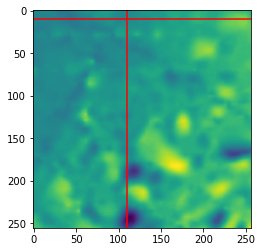

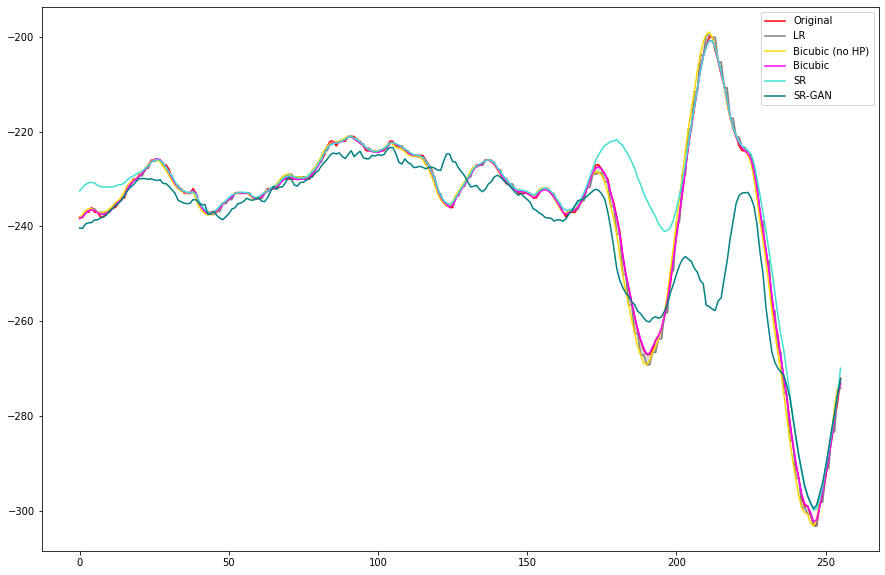

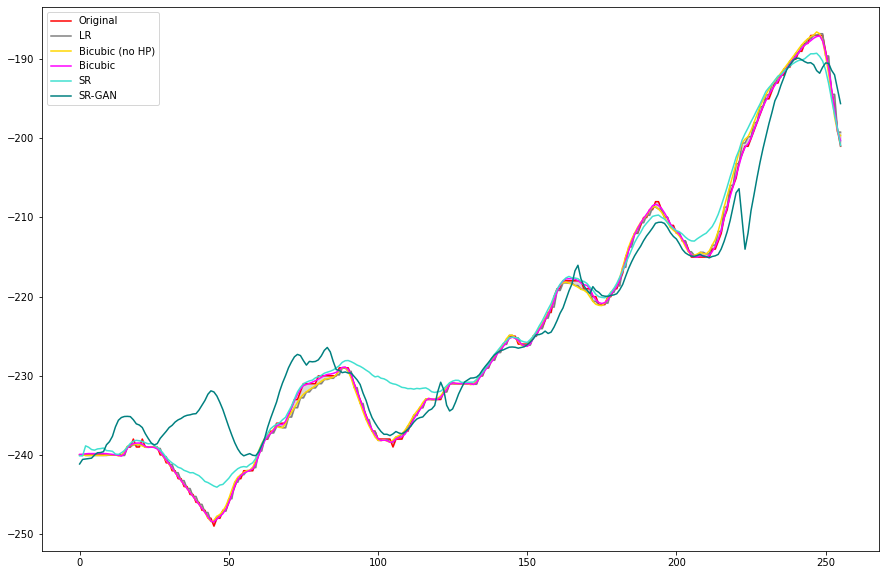

In [278]:
image =4
v_line=110
h_line = 10

plt.imshow(np.array(hr_denorm)[image,:,:,0])
plt.axvline(v_line,color='red')
plt.axhline(h_line,color='red')

a = np.array(hr_denorm)[image,:,v_line,0]
b = np.array(lr_test_denorm)[image,:,v_line,0]
x = np.arange(0,256,1)

plt.figure(figsize=(15,10))
plt.plot(a, label='Original', color='red')
plt.plot(b, label='LR', color='gray')
plt.fill_between(x, a, b, color ='gray', alpha=0.3)
plt.plot(np.array(bicubic_nohalfpixel_denorm)[image,:,v_line,0], label='Bicubic (no HP)', color='gold')
plt.plot(np.array(bicubic_denorm)[image,:,v_line,0], label='Bicubic', color='magenta')
plt.plot(np.array(tf.squeeze(SR_pred_denorm))[image,:,v_line, 0 ], label='SR', color='turquoise') 
plt.plot(np.array(tf.squeeze(SRGAN_pred_denorm))[image,:,v_line, 0], label='SR-GAN', color='teal')
plt.legend()

a = np.array(hr_denorm)[image,h_line,:,0]
b = np.array(lr_test_denorm)[image,h_line,:,0]
x = np.arange(0,256,1)

plt.figure(figsize=(15,10))
plt.plot(a, label='Original', color='red')
plt.plot(b, label='LR', color='gray')
plt.fill_between(x, a, b, color ='gray', alpha=0.3)
plt.plot(np.array(bicubic_nohalfpixel_denorm)[image,h_line,:,0], label='Bicubic (no HP)', color='gold')
plt.plot(np.array(bicubic_denorm)[image,h_line,:,0], label='Bicubic', color='magenta')
plt.plot(np.array(tf.squeeze(SR_pred_denorm))[image,h_line,:, 0 ], label='SR', color='turquoise') 
plt.plot(np.array(tf.squeeze(SRGAN_pred_denorm))[image,h_line,:, 0], label='SR-GAN', color='teal')
plt.legend()

## Lineplots GEBCO

In [26]:
#hr, lr, lr_denorm, hr_denorm = load_test_dataset_with_degraded_LR(HR_file_path=file_path)
hr, lr, lr_denorm, hr_denorm = load_dataset_with_real_LR(HR_file_path=HR_file_path, LR_file_path=LR_file_path)

lr_test = tf.image.resize(lr, [Params['hr_dimension'], Params['hr_dimension']],method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
lr_test_denorm = denorm(lr_test)

bicubic = tf.image.resize(lr, [Params['hr_dimension'], Params['hr_dimension']],method=tf.image.ResizeMethod.BICUBIC)
bicubic_denorm = denorm(bicubic)

bicubic_nohalfpixel = tf.compat.v1.image.resize_bicubic(lr, [Params['hr_dimension'], Params['hr_dimension']])
bicubic_nohalfpixel_denorm = denorm(bicubic_nohalfpixel)

SR_pred = calculate_prediction(lr, SR_x2_model)
SR_pred_denorm = denorm(SR_pred)

SRGAN_pred = calculate_prediction(lr, SRGAN_x2_model)
SRGAN_pred_denorm = denorm(SRGAN_pred)



HR Test Samples:  93 Files found
LR Test Samples:  93 Files found
HR Dataset Shape:  (93, 256, 256, 3)
Upscale x 2  LR Dataset Shape:  (93, 128, 128, 3)


2022-08-07 13:01:50.823243: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-08-07 13:01:51.273107: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-08-07 13:01:51.354384: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-08-07 13:01:52.463306: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


In [176]:
SR_degraded_pred = calculate_prediction(lr, SR_x2_degraded_model)
SR_degraded_pred_denorm = denorm(SR_degraded_pred)

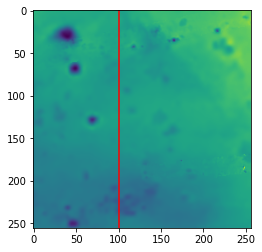

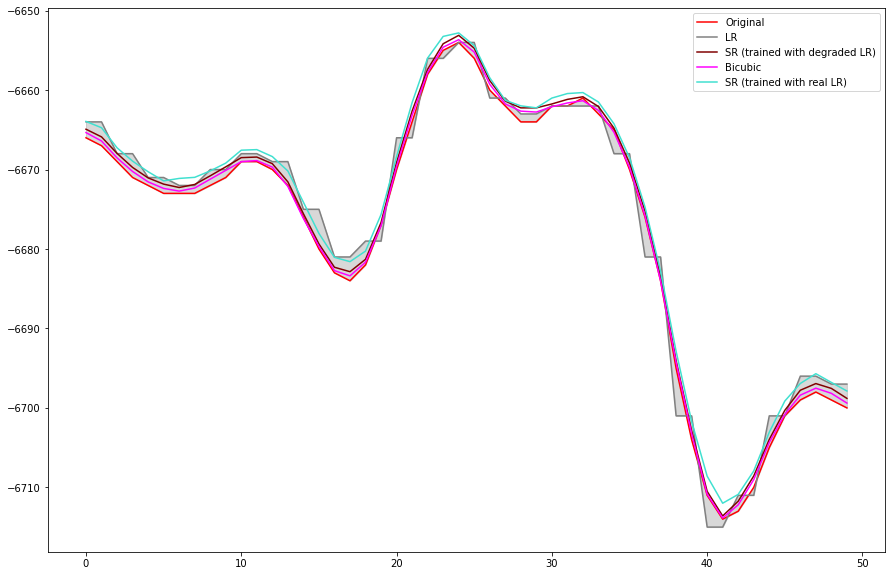

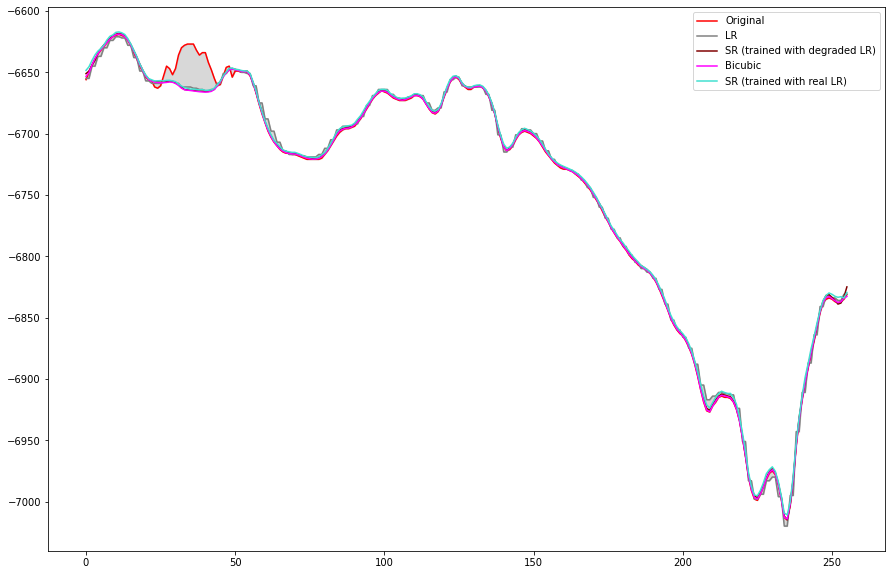

In [189]:
image =64
v_line=100
h_line = 100

plt.imshow(np.array(hr_denorm)[image,:,:,0])
plt.axvline(v_line,color='red')
#plt.axhline(h_line,color='red')

a = np.array(hr_denorm)[image,100:150,v_line,0]
b = np.array(lr_test_denorm)[image,100:150,v_line,0]
x = np.arange(0,50,1)

plt.figure(figsize=(15,10))
plt.plot(a, label='Original', color='red')
plt.plot(b, label='LR', color='gray')
plt.fill_between(x, a, b, color ='gray', alpha=0.3)
plt.plot(np.array(tf.squeeze(SR_degraded_pred_denorm))[image,100:150,v_line, 0], label='SR (trained with degraded LR)', color='maroon')
#plt.plot(np.array(bicubic_nohalfpixel_denorm)[image,:,v_line,0], label='Bicubic (no HP)', color='gold')
plt.plot(np.array(bicubic_denorm)[image,100:150,v_line,0], label='Bicubic', color='magenta')
plt.plot(np.array(tf.squeeze(SR_pred_denorm))[image,100:150,v_line, 0 ], label='SR (trained with real LR)', color='turquoise') 
#plt.plot(np.array(tf.squeeze(SRGAN_pred_denorm))[image,:,v_line, 0], label='SR-GAN', color='teal')
plt.legend()

a = np.array(hr_denorm)[image,:,v_line,0]
b = np.array(lr_test_denorm)[image,:,v_line,0]
x = np.arange(0,256,1)

plt.figure(figsize=(15,10))
plt.plot(a, label='Original', color='red')
plt.plot(b, label='LR', color='gray')
plt.fill_between(x, a, b, color ='gray', alpha=0.3)
plt.plot(np.array(tf.squeeze(SR_degraded_pred_denorm))[image,:,v_line, 0], label='SR (trained with degraded LR)', color='maroon')
#plt.plot(np.array(bicubic_nohalfpixel_denorm)[image,:,v_line,0], label='Bicubic (no HP)', color='gold')
plt.plot(np.array(bicubic_denorm)[image,:,v_line,0], label='Bicubic', color='magenta')
plt.plot(np.array(tf.squeeze(SR_pred_denorm))[image,:,v_line, 0 ], label='SR (trained with real LR)', color='turquoise') 
#plt.plot(np.array(tf.squeeze(SRGAN_pred_denorm))[image,:,v_line, 0], label='SR-GAN', color='teal')
plt.legend()

# a = np.array(hr_denorm)[image,h_line,:,0]
# b = np.array(lr_test_denorm)[image,h_line,:,0]
# x = np.arange(0,256,1)

# plt.figure(figsize=(15,10))
# plt.plot(a, label='Original', color='red')
# plt.plot(b, label='LR', color='gray')
# plt.fill_between(x, a, b, color ='gray', alpha=0.3)
# plt.plot(np.array(tf.squeeze(SR_degraded_pred_denorm))[image,h_line,:, 0], label='SR (trained with degraded LR)', color='lawngreen')
# #plt.plot(np.array(bicubic_nohalfpixel_denorm)[image,h_line,:,0], label='Bicubic (no HP)', color='gold')
# plt.plot(np.array(bicubic_denorm)[image,h_line,:,0], label='Bicubic', color='magenta')
# plt.plot(np.array(tf.squeeze(SR_pred_denorm))[image,h_line,:, 0 ], label='SR (trained with real LR)', color='turquoise') 
# #plt.plot(np.array(tf.squeeze(SRGAN_pred_denorm))[image,h_line,:, 0], label='SR-GAN', color='teal')

# plt.legend()

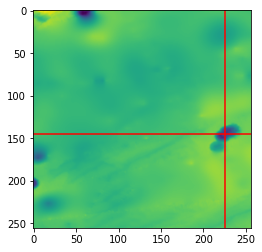

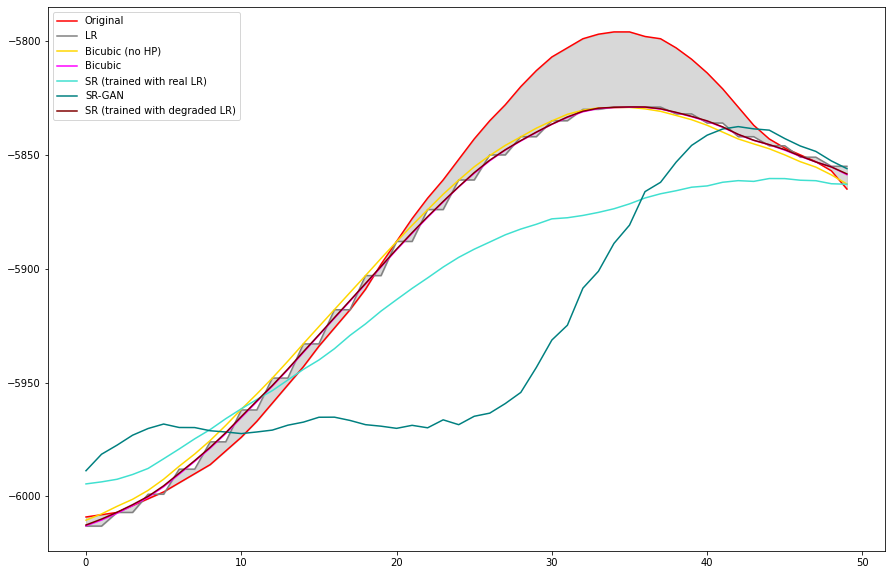

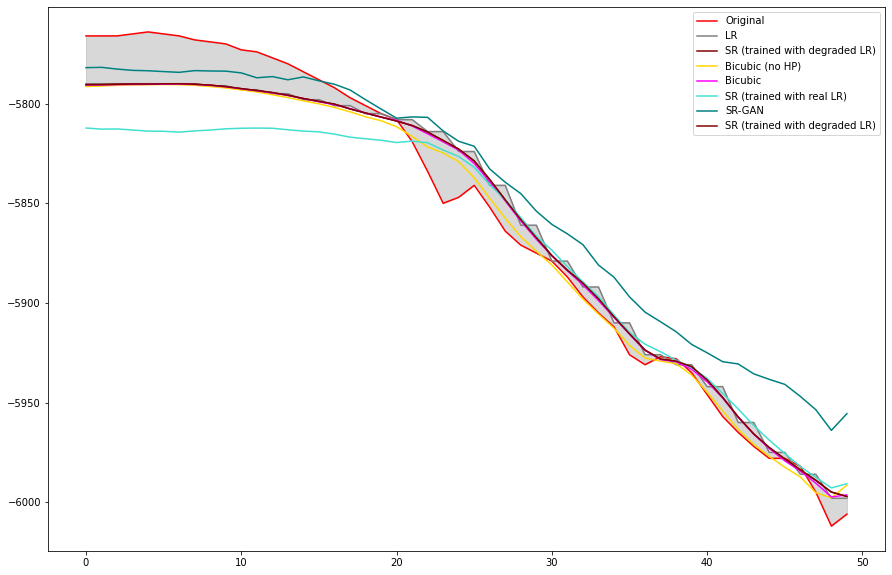

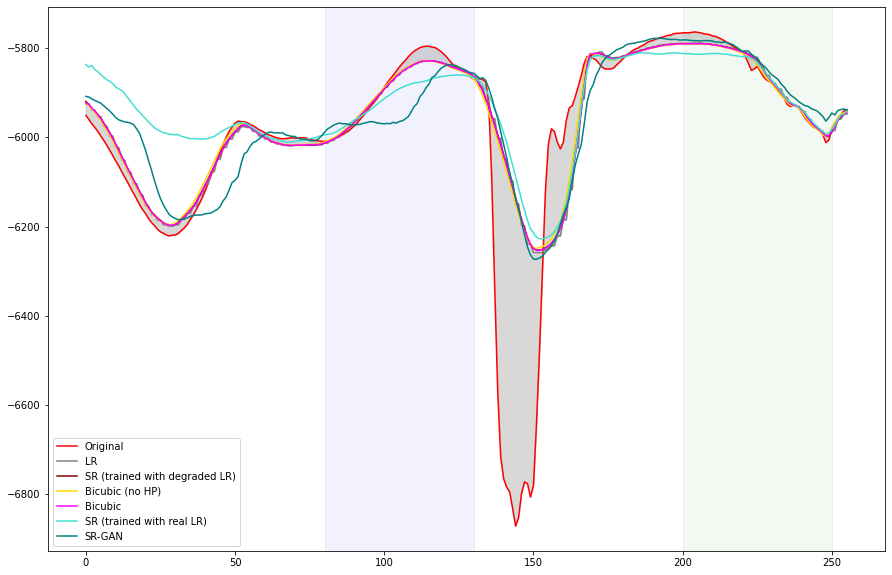

In [233]:
image =78
v_line= 225
h_line = 145

plt.imshow(np.array(hr_denorm)[image,:,:,0])
plt.axvline(v_line,color='red')
plt.axhline(h_line,color='red')
x1_min = 80
x1_max = 130

a = np.array(hr_denorm)[image,x1_min:x1_max,v_line,0]
b = np.array(lr_test_denorm)[image,x1_min:x1_max,v_line,0]
x = np.arange(0,x1_max - x1_min,1)

plt.figure(figsize=(15,10))
plt.plot(a, label='Original', color='red')
plt.plot(b, label='LR', color='gray')
plt.fill_between(x, a, b, color ='gray', alpha=0.3)

plt.plot(np.array(bicubic_nohalfpixel_denorm)[image,x1_min:x1_max,v_line,0], label='Bicubic (no HP)', color='gold')
plt.plot(np.array(bicubic_denorm)[image,x1_min:x1_max,v_line,0], label='Bicubic', color='magenta')
plt.plot(np.array(tf.squeeze(SR_pred_denorm))[image,x1_min:x1_max,v_line, 0 ], label='SR (trained with real LR)', color='turquoise') 
plt.plot(np.array(tf.squeeze(SRGAN_pred_denorm))[image,x1_min:x1_max,v_line, 0], label='SR-GAN', color='teal')
plt.plot(np.array(tf.squeeze(SR_degraded_pred_denorm))[image,x1_min:x1_max,v_line, 0], label='SR (trained with degraded LR)', color='maroon')
plt.legend()

x2_min = 200
x2_max = 250
a = np.array(hr_denorm)[image,x2_min:x2_max,v_line,0]
b = np.array(lr_test_denorm)[image,x2_min:x2_max,v_line,0]
x = np.arange(0,x2_max-x2_min,1)

plt.figure(figsize=(15,10))
plt.plot(a, label='Original', color='red')
plt.plot(b, label='LR', color='gray')
plt.fill_between(x, a, b, color ='gray', alpha=0.3)
plt.plot(np.array(tf.squeeze(SR_degraded_pred_denorm))[image,x2_min:x2_max,v_line, 0], label='SR (trained with degraded LR)', color='maroon')
plt.plot(np.array(bicubic_nohalfpixel_denorm)[image,x2_min:x2_max,v_line,0], label='Bicubic (no HP)', color='gold')
plt.plot(np.array(bicubic_denorm)[image,x2_min:x2_max,v_line,0], label='Bicubic', color='magenta')
plt.plot(np.array(tf.squeeze(SR_pred_denorm))[image,x2_min:x2_max,v_line, 0 ], label='SR (trained with real LR)', color='turquoise') 
plt.plot(np.array(tf.squeeze(SRGAN_pred_denorm))[image,x2_min:x2_max,v_line, 0], label='SR-GAN', color='teal')
plt.plot(np.array(tf.squeeze(SR_degraded_pred_denorm))[image,x2_min:x2_max,v_line, 0], label='SR (trained with degraded LR)', color='maroon')
plt.legend()

# plt.figure(figsize=(15,10))
# plt.plot(a, label='Original', color='red')
# plt.plot(b, label='LR', color='gray')
# plt.fill_between(x, a, b, color ='gray', alpha=0.3)
# #plt.plot(np.array(tf.squeeze(SR_degraded_pred_denorm))[image,x2_min:x2_max,v_line, 0], label='SR (trained with degraded LR)', color='maroon')
# plt.plot(np.array(bicubic_nohalfpixel_denorm)[image,x2_min:x2_max,v_line,0], label='Bicubic (no HP)', color='gold')
# plt.plot(np.array(bicubic_denorm)[image,x2_min:x2_max,v_line,0], label='Bicubic', color='magenta')
# #plt.plot(np.array(tf.squeeze(SR_pred_denorm))[image,x2_min:x2_max,v_line, 0 ], label='SR (trained with real LR)', color='turquoise') 
# #plt.plot(np.array(tf.squeeze(SRGAN_pred_denorm))[image,x2_min:x2_max,v_line, 0], label='SR-GAN', color='teal')
# plt.legend()

a = np.array(hr_denorm)[image,:,v_line,0]
b = np.array(lr_test_denorm)[image,:,v_line,0]
x = np.arange(0,256,1)

plt.figure(figsize=(15,10))
plt.axvspan(x1_min, x1_max, color='blue', alpha=0.05)
plt.axvspan(x2_min, x2_max, color='green', alpha=0.05)
plt.plot(a, label='Original', color='red')
plt.plot(b, label='LR', color='gray')
plt.fill_between(x, a, b, color ='gray', alpha=0.3)
plt.plot(np.array(tf.squeeze(SR_degraded_pred_denorm))[image,:,v_line, 0], label='SR (trained with degraded LR)', color='maroon')
plt.plot(np.array(bicubic_nohalfpixel_denorm)[image,:,v_line,0], label='Bicubic (no HP)', color='gold')
plt.plot(np.array(bicubic_denorm)[image,:,v_line,0], label='Bicubic', color='magenta')
plt.plot(np.array(tf.squeeze(SR_pred_denorm))[image,:,v_line, 0 ], label='SR (trained with real LR)', color='turquoise') 
plt.plot(np.array(tf.squeeze(SRGAN_pred_denorm))[image,:,v_line, 0], label='SR-GAN', color='teal')
plt.legend()

# a = np.array(hr_denorm)[image,h_line,:,0]
# b = np.array(lr_test_denorm)[image,h_line,:,0]
# x = np.arange(0,256,1)

# plt.figure(figsize=(15,10))
# plt.plot(a, label='Original', color='red')
# plt.plot(b, label='LR', color='gray')
# plt.fill_between(x, a, b, color ='gray', alpha=0.3)
# plt.plot(np.array(tf.squeeze(SR_degraded_pred_denorm))[image,h_line,:, 0], label='SR (trained with degraded LR)', color='lawngreen')
# #plt.plot(np.array(bicubic_nohalfpixel_denorm)[image,h_line,:,0], label='Bicubic (no HP)', color='gold')
# plt.plot(np.array(bicubic_denorm)[image,h_line,:,0], label='Bicubic', color='magenta')
# plt.plot(np.array(tf.squeeze(SR_pred_denorm))[image,h_line,:, 0 ], label='SR (trained with real LR)', color='turquoise') 
# #plt.plot(np.array(tf.squeeze(SRGAN_pred_denorm))[image,h_line,:, 0], label='SR-GAN', color='teal')

# plt.legend()

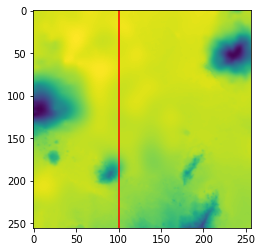

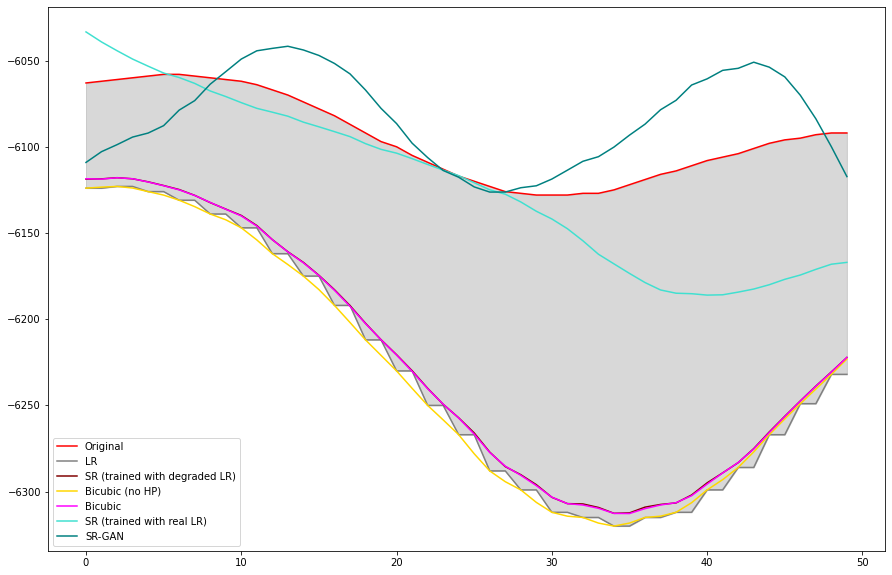

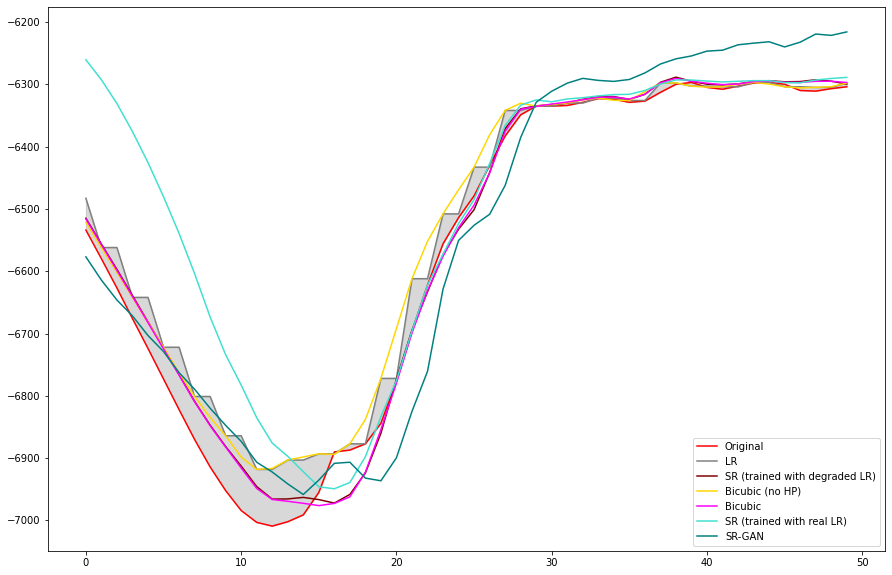

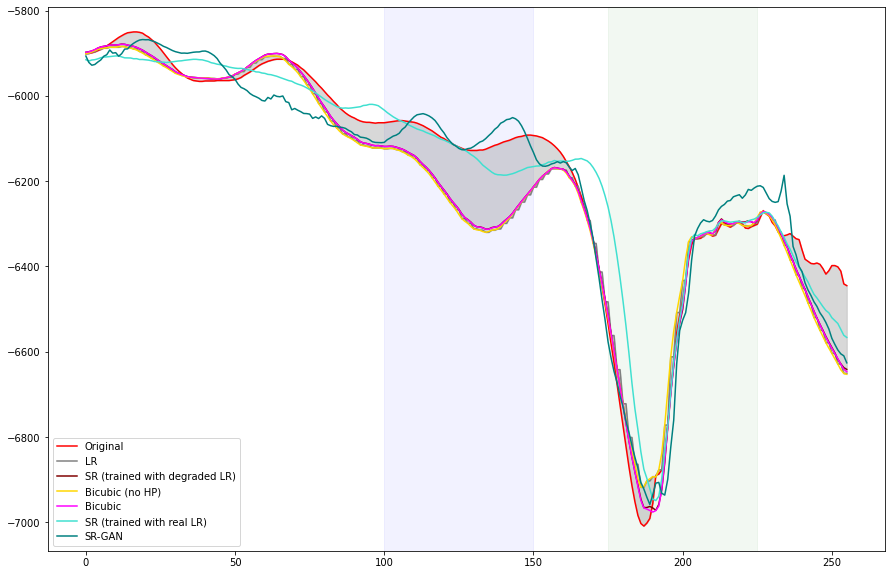

In [222]:
image =69
v_line=100
h_line = 100

plt.imshow(np.array(hr_denorm)[image,:,:,0])
plt.axvline(v_line,color='red')
#plt.axhline(h_line,color='red')
x1_min = 100
x1_max = 150

a = np.array(hr_denorm)[image,x1_min:x1_max,v_line,0]
b = np.array(lr_test_denorm)[image,x1_min:x1_max,v_line,0]
x = np.arange(0,x1_max - x1_min,1)

plt.figure(figsize=(15,10))
plt.plot(a, label='Original', color='red')
plt.plot(b, label='LR', color='gray')
plt.fill_between(x, a, b, color ='gray', alpha=0.3)
plt.plot(np.array(tf.squeeze(SR_degraded_pred_denorm))[image,x1_min:x1_max,v_line, 0], label='SR (trained with degraded LR)', color='maroon')
plt.plot(np.array(bicubic_nohalfpixel_denorm)[image,x1_min:x1_max,v_line,0], label='Bicubic (no HP)', color='gold')
plt.plot(np.array(bicubic_denorm)[image,x1_min:x1_max,v_line,0], label='Bicubic', color='magenta')
plt.plot(np.array(tf.squeeze(SR_pred_denorm))[image,x1_min:x1_max,v_line, 0 ], label='SR (trained with real LR)', color='turquoise') 
plt.plot(np.array(tf.squeeze(SRGAN_pred_denorm))[image,x1_min:x1_max,v_line, 0], label='SR-GAN', color='teal')
plt.legend()

x2_min = 175
x2_max = 225
a = np.array(hr_denorm)[image,x2_min:x2_max,v_line,0]
b = np.array(lr_test_denorm)[image,x2_min:x2_max,v_line,0]
x = np.arange(0,x2_max-x2_min,1)

plt.figure(figsize=(15,10))
plt.plot(a, label='Original', color='red')
plt.plot(b, label='LR', color='gray')
plt.fill_between(x, a, b, color ='gray', alpha=0.3)
plt.plot(np.array(tf.squeeze(SR_degraded_pred_denorm))[image,x2_min:x2_max,v_line, 0], label='SR (trained with degraded LR)', color='maroon')
plt.plot(np.array(bicubic_nohalfpixel_denorm)[image,x2_min:x2_max,v_line,0], label='Bicubic (no HP)', color='gold')
plt.plot(np.array(bicubic_denorm)[image,x2_min:x2_max,v_line,0], label='Bicubic', color='magenta')
plt.plot(np.array(tf.squeeze(SR_pred_denorm))[image,x2_min:x2_max,v_line, 0 ], label='SR (trained with real LR)', color='turquoise') 
plt.plot(np.array(tf.squeeze(SRGAN_pred_denorm))[image,x2_min:x2_max,v_line, 0], label='SR-GAN', color='teal')
plt.legend()

# plt.figure(figsize=(15,10))
# plt.plot(a, label='Original', color='red')
# plt.plot(b, label='LR', color='gray')
# plt.fill_between(x, a, b, color ='gray', alpha=0.3)
# #plt.plot(np.array(tf.squeeze(SR_degraded_pred_denorm))[image,x2_min:x2_max,v_line, 0], label='SR (trained with degraded LR)', color='maroon')
# plt.plot(np.array(bicubic_nohalfpixel_denorm)[image,x2_min:x2_max,v_line,0], label='Bicubic (no HP)', color='gold')
# plt.plot(np.array(bicubic_denorm)[image,x2_min:x2_max,v_line,0], label='Bicubic', color='magenta')
# #plt.plot(np.array(tf.squeeze(SR_pred_denorm))[image,x2_min:x2_max,v_line, 0 ], label='SR (trained with real LR)', color='turquoise') 
# #plt.plot(np.array(tf.squeeze(SRGAN_pred_denorm))[image,x2_min:x2_max,v_line, 0], label='SR-GAN', color='teal')
# plt.legend()

a = np.array(hr_denorm)[image,:,v_line,0]
b = np.array(lr_test_denorm)[image,:,v_line,0]
x = np.arange(0,256,1)

plt.figure(figsize=(15,10))
plt.axvspan(x1_min, x1_max, color='blue', alpha=0.05)
plt.axvspan(x2_min, x2_max, color='green', alpha=0.05)
plt.plot(a, label='Original', color='red')
plt.plot(b, label='LR', color='gray')
plt.fill_between(x, a, b, color ='gray', alpha=0.3)
plt.plot(np.array(tf.squeeze(SR_degraded_pred_denorm))[image,:,v_line, 0], label='SR (trained with degraded LR)', color='maroon')
plt.plot(np.array(bicubic_nohalfpixel_denorm)[image,:,v_line,0], label='Bicubic (no HP)', color='gold')
plt.plot(np.array(bicubic_denorm)[image,:,v_line,0], label='Bicubic', color='magenta')
plt.plot(np.array(tf.squeeze(SR_pred_denorm))[image,:,v_line, 0 ], label='SR (trained with real LR)', color='turquoise') 
plt.plot(np.array(tf.squeeze(SRGAN_pred_denorm))[image,:,v_line, 0], label='SR-GAN', color='teal')
plt.legend()

# a = np.array(hr_denorm)[image,h_line,:,0]
# b = np.array(lr_test_denorm)[image,h_line,:,0]
# x = np.arange(0,256,1)

# plt.figure(figsize=(15,10))
# plt.plot(a, label='Original', color='red')
# plt.plot(b, label='LR', color='gray')
# plt.fill_between(x, a, b, color ='gray', alpha=0.3)
# plt.plot(np.array(tf.squeeze(SR_degraded_pred_denorm))[image,h_line,:, 0], label='SR (trained with degraded LR)', color='lawngreen')
# #plt.plot(np.array(bicubic_nohalfpixel_denorm)[image,h_line,:,0], label='Bicubic (no HP)', color='gold')
# plt.plot(np.array(bicubic_denorm)[image,h_line,:,0], label='Bicubic', color='magenta')
# plt.plot(np.array(tf.squeeze(SR_pred_denorm))[image,h_line,:, 0 ], label='SR (trained with real LR)', color='turquoise') 
# #plt.plot(np.array(tf.squeeze(SRGAN_pred_denorm))[image,h_line,:, 0], label='SR-GAN', color='teal')

# plt.legend()

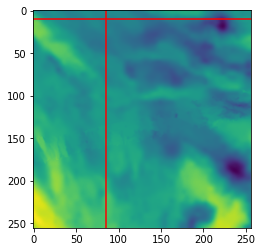

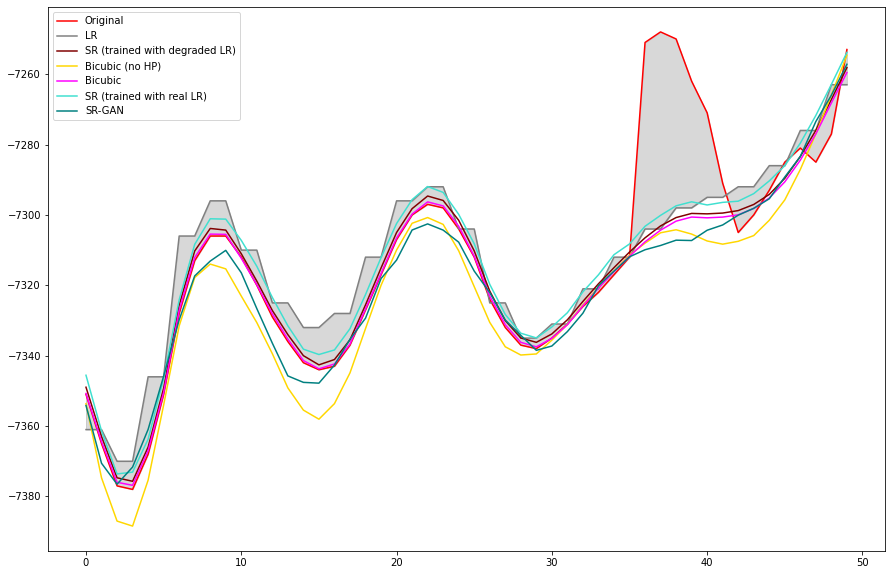

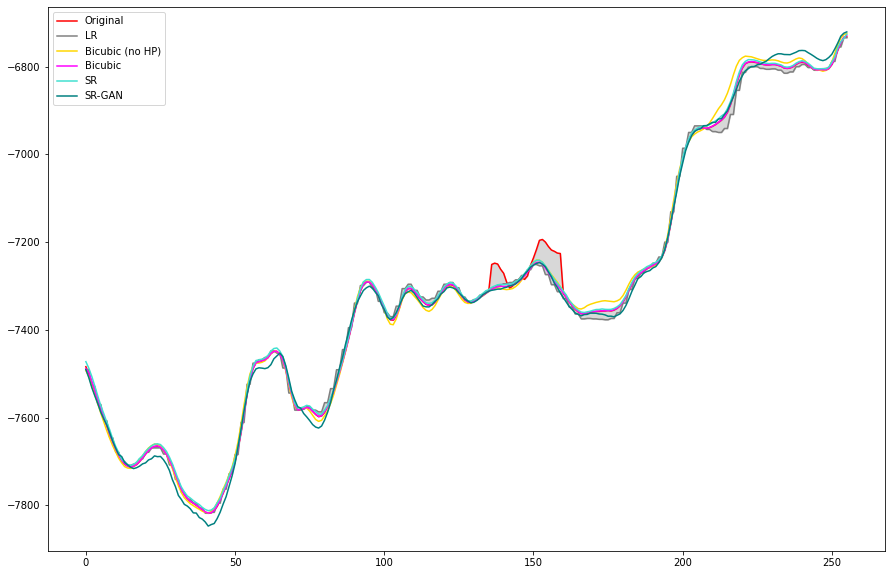

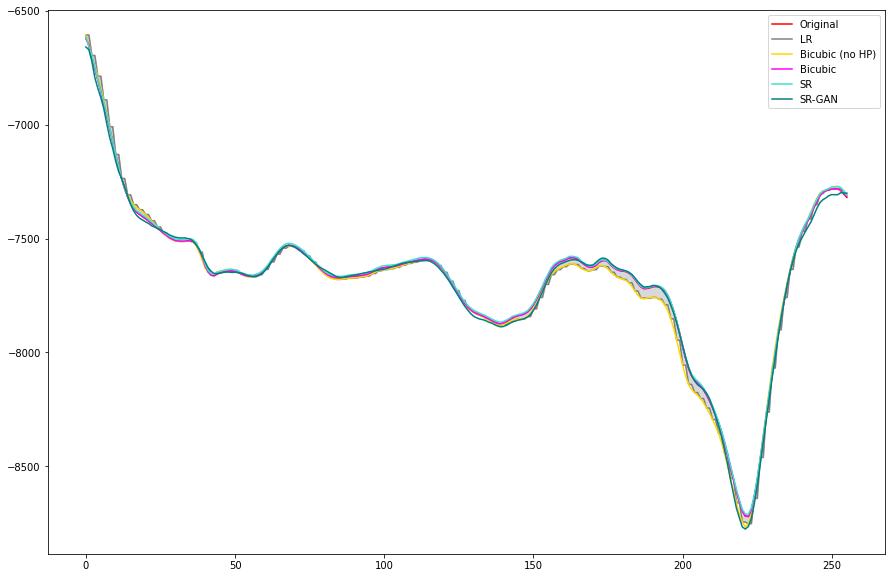

In [239]:
image =13
v_line=85
h_line = 10

plt.imshow(np.array(hr_denorm)[image,:,:,0])
plt.axvline(v_line,color='red')
plt.axhline(h_line,color='red')



x1_min = 100
x1_max = 150

a = np.array(hr_denorm)[image,x1_min:x1_max,v_line,0]
b = np.array(lr_test_denorm)[image,x1_min:x1_max,v_line,0]
x = np.arange(0,x1_max - x1_min,1)

plt.figure(figsize=(15,10))
plt.plot(a, label='Original', color='red')
plt.plot(b, label='LR', color='gray')
plt.fill_between(x, a, b, color ='gray', alpha=0.3)
plt.plot(np.array(tf.squeeze(SR_degraded_pred_denorm))[image,x1_min:x1_max,v_line, 0], label='SR (trained with degraded LR)', color='maroon')
plt.plot(np.array(bicubic_nohalfpixel_denorm)[image,x1_min:x1_max,v_line,0], label='Bicubic (no HP)', color='gold')
plt.plot(np.array(bicubic_denorm)[image,x1_min:x1_max,v_line,0], label='Bicubic', color='magenta')
plt.plot(np.array(tf.squeeze(SR_pred_denorm))[image,x1_min:x1_max,v_line, 0 ], label='SR (trained with real LR)', color='turquoise') 
plt.plot(np.array(tf.squeeze(SRGAN_pred_denorm))[image,x1_min:x1_max,v_line, 0], label='SR-GAN', color='teal')
plt.legend()

a = np.array(hr_denorm)[image,:,v_line,0]
b = np.array(lr_test_denorm)[image,:,v_line,0]
x = np.arange(0,256,1)

plt.figure(figsize=(15,10))
plt.plot(a, label='Original', color='red')
plt.plot(b, label='LR', color='gray')
plt.fill_between(x, a, b, color ='gray', alpha=0.3)
plt.plot(np.array(bicubic_nohalfpixel_denorm)[image,:,v_line,0], label='Bicubic (no HP)', color='gold')
plt.plot(np.array(bicubic_denorm)[image,:,v_line,0], label='Bicubic', color='magenta')
plt.plot(np.array(tf.squeeze(SR_pred_denorm))[image,:,v_line, 0 ], label='SR', color='turquoise') 
plt.plot(np.array(tf.squeeze(SRGAN_pred_denorm))[image,:,v_line, 0], label='SR-GAN', color='teal')
plt.legend()

a = np.array(hr_denorm)[image,h_line,:,0]
b = np.array(lr_test_denorm)[image,h_line,:,0]
x = np.arange(0,256,1)

plt.figure(figsize=(15,10))
plt.plot(a, label='Original', color='red')
plt.plot(b, label='LR', color='gray')
plt.fill_between(x, a, b, color ='gray', alpha=0.3)
#plt.plot(np.array(tf.squeeze(SR_degraded_pred_denorm))[image,h_line,:, 0], label='SR (trained with degraded LR)', color='lawngreen')
plt.plot(np.array(bicubic_nohalfpixel_denorm)[image,h_line,:,0], label='Bicubic (no HP)', color='gold')
plt.plot(np.array(bicubic_denorm)[image,h_line,:,0], label='Bicubic', color='magenta')
plt.plot(np.array(tf.squeeze(SR_pred_denorm))[image,h_line,:, 0 ], label='SR', color='turquoise') 
plt.plot(np.array(tf.squeeze(SRGAN_pred_denorm))[image,h_line,:, 0], label='SR-GAN', color='teal')

plt.legend()

#### Example: good Pair

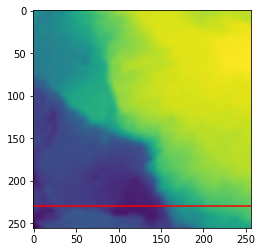

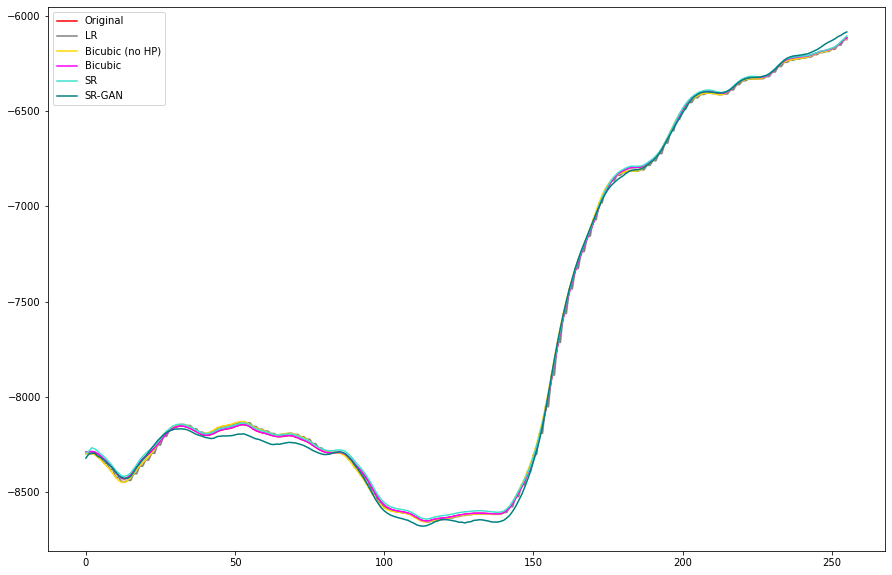

In [179]:
image =17
v_line=85
h_line = 230

plt.imshow(np.array(hr_denorm)[image,:,:,0])
#plt.axvline(v_line,color='red')
plt.axhline(h_line,color='red')

# a = np.array(hr_denorm)[image,:,v_line,0]
# b = np.array(lr_test_denorm)[image,:,v_line,0]
# x = np.arange(0,256,1)

# plt.figure(figsize=(15,10))
# plt.plot(a, label='Original', color='red')
# plt.plot(b, label='LR', color='gray')
# plt.fill_between(x, a, b, color ='gray', alpha=0.3)
# plt.plot(np.array(bicubic_nohalfpixel_denorm)[image,:,v_line,0], label='Bicubic (no HP)', color='gold')
# plt.plot(np.array(bicubic_denorm)[image,:,v_line,0], label='Bicubic', color='magenta')
# plt.plot(np.array(tf.squeeze(SR_pred_denorm))[image,:,v_line, 0 ], label='SR', color='turquoise') 
# plt.plot(np.array(tf.squeeze(SRGAN_pred_denorm))[image,:,v_line, 0], label='SR-GAN', color='teal')
# plt.legend()

a = np.array(hr_denorm)[image,h_line,:,0]
b = np.array(lr_test_denorm)[image,h_line,:,0]
x = np.arange(0,256,1)

plt.figure(figsize=(15,10))
plt.plot(a, label='Original', color='red')
plt.plot(b, label='LR', color='gray')
plt.fill_between(x, a, b, color ='gray', alpha=0.3)
#plt.plot(np.array(tf.squeeze(SR_degraded_pred_denorm))[image,h_line,:, 0], label='SR (trained with degraded LR)', color='lawngreen')
plt.plot(np.array(bicubic_nohalfpixel_denorm)[image,h_line,:,0], label='Bicubic (no HP)', color='gold')
plt.plot(np.array(bicubic_denorm)[image,h_line,:,0], label='Bicubic', color='magenta')
plt.plot(np.array(tf.squeeze(SR_pred_denorm))[image,h_line,:, 0 ], label='SR', color='turquoise') 
plt.plot(np.array(tf.squeeze(SRGAN_pred_denorm))[image,h_line,:, 0], label='SR-GAN', color='teal')

plt.legend()

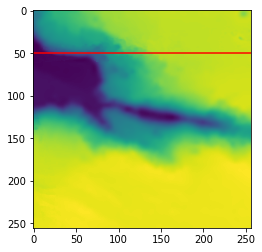

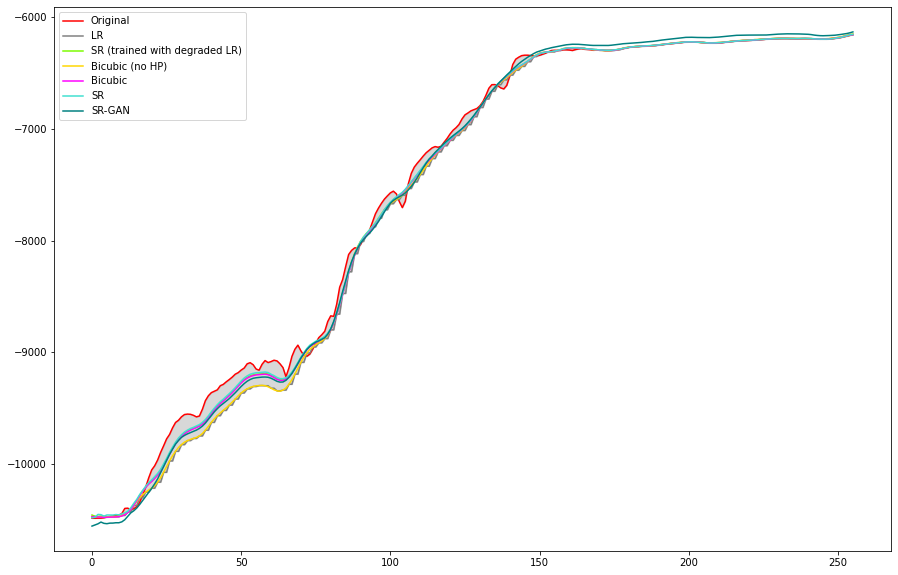

In [181]:
image =61
v_line=130
h_line = 50

plt.imshow(np.array(hr_denorm)[image,:,:,0])
#plt.axvline(v_line,color='red')
plt.axhline(h_line,color='red')

# a = np.array(hr_denorm)[image,:,v_line,0]
# b = np.array(lr_test_denorm)[image,:,v_line,0]
# x = np.arange(0,256,1)

# plt.figure(figsize=(15,10))
# plt.plot(a, label='Original', color='red')
# plt.plot(b, label='LR', color='gray')
# plt.fill_between(x, a, b, color ='gray', alpha=0.3)
# plt.plot(np.array(bicubic_nohalfpixel_denorm)[image,:,v_line,0], label='Bicubic (no HP)', color='gold')
# plt.plot(np.array(bicubic_denorm)[image,:,v_line,0], label='Bicubic', color='magenta')
# plt.plot(np.array(tf.squeeze(SR_pred_denorm))[image,:,v_line, 0 ], label='SR', color='turquoise') 
# plt.plot(np.array(tf.squeeze(SRGAN_pred_denorm))[image,:,v_line, 0], label='SR-GAN', color='teal')
# plt.legend()

a = np.array(hr_denorm)[image,h_line,:,0]
b = np.array(lr_test_denorm)[image,h_line,:,0]
x = np.arange(0,256,1)

plt.figure(figsize=(15,10))
plt.plot(a, label='Original', color='red')
plt.plot(b, label='LR', color='gray')
plt.fill_between(x, a, b, color ='gray', alpha=0.3)
plt.plot(np.array(bicubic_nohalfpixel_denorm)[image,h_line,:,0], label='Bicubic (no HP)', color='gold')
plt.plot(np.array(bicubic_denorm)[image,h_line,:,0], label='Bicubic', color='magenta')
plt.plot(np.array(tf.squeeze(SR_pred_denorm))[image,h_line,:, 0 ], label='SR', color='turquoise') 
plt.plot(np.array(tf.squeeze(SRGAN_pred_denorm))[image,h_line,:, 0], label='SR-GAN', color='teal')

plt.legend()

#### Example: Interpolated HR

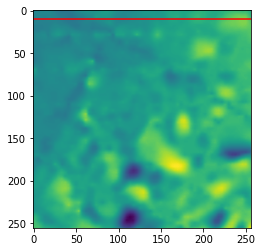

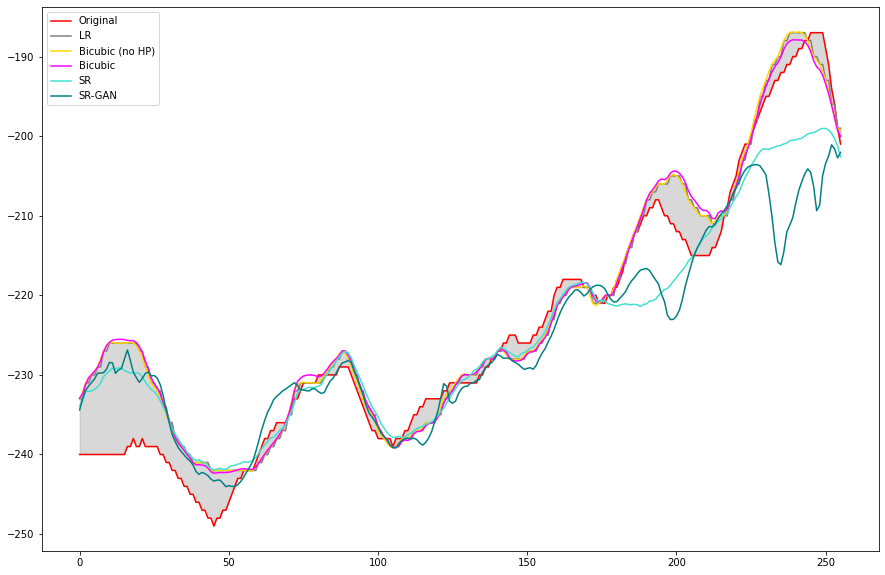

In [165]:
image =4
v_line=110
h_line = 10

plt.imshow(np.array(hr_denorm)[image,:,:,0])
#plt.axvline(v_line,color='red')
plt.axhline(h_line,color='red')

# a = np.array(hr_denorm)[image,:,v_line,0]
# b = np.array(lr_test_denorm)[image,:,v_line,0]
# x = np.arange(0,256,1)

# plt.figure(figsize=(15,10))
# plt.plot(a, label='Original', color='red')
# plt.plot(b, label='LR', color='gray')
# plt.fill_between(x, a, b, color ='gray', alpha=0.3)
# plt.plot(np.array(bicubic_nohalfpixel_denorm)[image,:,v_line,0], label='Bicubic (no HP)', color='gold')
# plt.plot(np.array(bicubic_denorm)[image,:,v_line,0], label='Bicubic', color='magenta')
# plt.plot(np.array(tf.squeeze(SR_pred_denorm))[image,:,v_line, 0 ], label='SR', color='turquoise') 
# plt.plot(np.array(tf.squeeze(SRGAN_pred_denorm))[image,:,v_line, 0], label='SR-GAN', color='teal')
# plt.legend()

a = np.array(hr_denorm)[image,h_line,:,0]
b = np.array(lr_test_denorm)[image,h_line,:,0]
x = np.arange(0,256,1)

plt.figure(figsize=(15,10))
plt.plot(a, label='Original', color='red')
plt.plot(b, label='LR', color='gray')
plt.fill_between(x, a, b, color ='gray', alpha=0.3)
plt.plot(np.array(bicubic_nohalfpixel_denorm)[image,h_line,:,0], label='Bicubic (no HP)', color='gold')
plt.plot(np.array(bicubic_denorm)[image,h_line,:,0], label='Bicubic', color='magenta')
plt.plot(np.array(tf.squeeze(SR_pred_denorm))[image,h_line,:, 0 ], label='SR', color='turquoise') 
plt.plot(np.array(tf.squeeze(SRGAN_pred_denorm))[image,h_line,:, 0], label='SR-GAN', color='teal')
plt.legend()

#### Example: Fake structures - additional high-frequency details

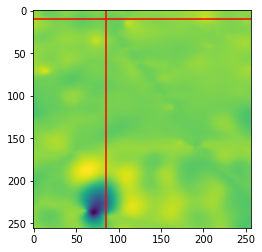

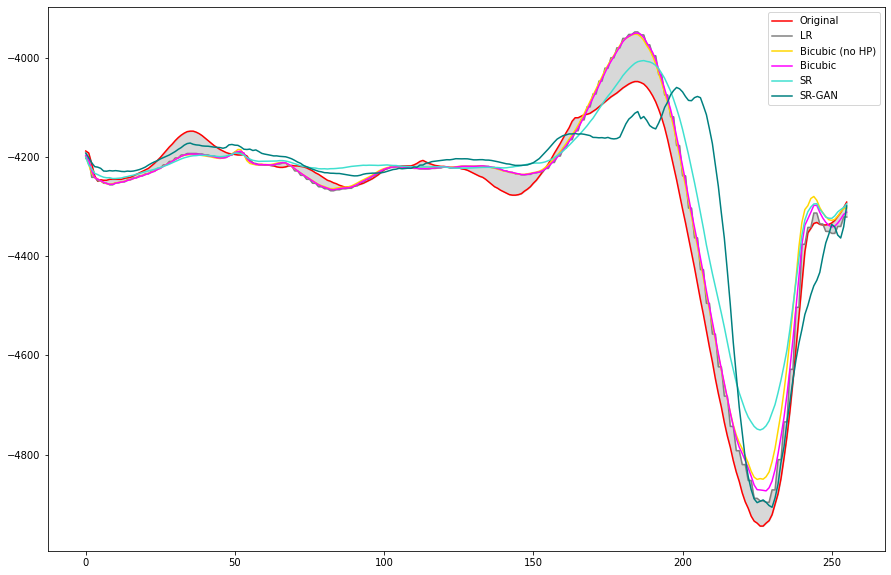

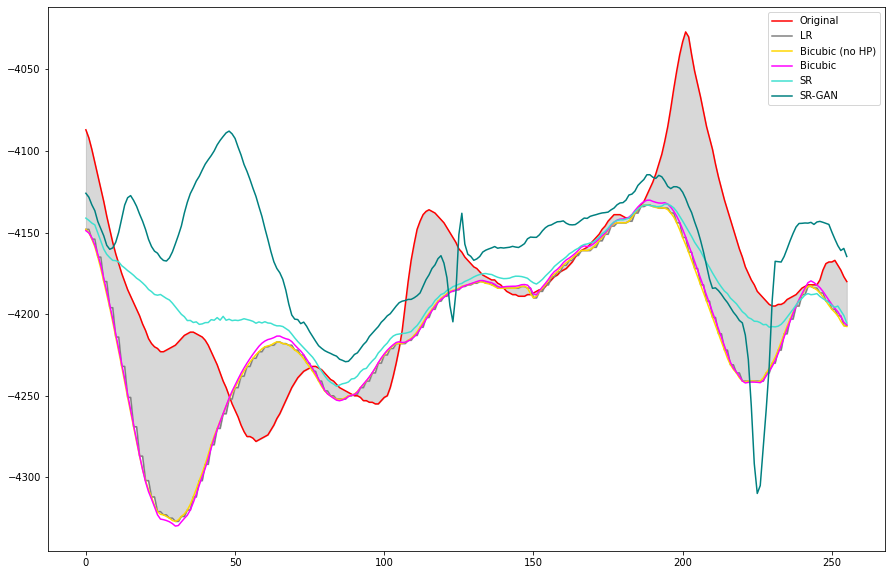

In [161]:
image =24
v_line=85
h_line = 10

plt.imshow(np.array(hr_denorm)[image,:,:,0])
plt.axvline(v_line,color='red')
plt.axhline(h_line,color='red')

a = np.array(hr_denorm)[image,:,v_line,0]
b = np.array(lr_test_denorm)[image,:,v_line,0]
x = np.arange(0,256,1)

plt.figure(figsize=(15,10))
plt.plot(a, label='Original', color='red')
plt.plot(b, label='LR', color='gray')
plt.fill_between(x, a, b, color ='gray', alpha=0.3)
plt.plot(np.array(bicubic_nohalfpixel_denorm)[image,:,v_line,0], label='Bicubic (no HP)', color='gold')
plt.plot(np.array(bicubic_denorm)[image,:,v_line,0], label='Bicubic', color='magenta')
plt.plot(np.array(tf.squeeze(SR_pred_denorm))[image,:,v_line, 0 ], label='SR', color='turquoise') 
plt.plot(np.array(tf.squeeze(SRGAN_pred_denorm))[image,:,v_line, 0], label='SR-GAN', color='teal')
plt.legend()

a = np.array(hr_denorm)[image,h_line,:,0]
b = np.array(lr_test_denorm)[image,h_line,:,0]
x = np.arange(0,256,1)

plt.figure(figsize=(15,10))
plt.plot(a, label='Original', color='red')
plt.plot(b, label='LR', color='gray')
plt.fill_between(x, a, b, color ='gray', alpha=0.3)
plt.plot(np.array(bicubic_nohalfpixel_denorm)[image,h_line,:,0], label='Bicubic (no HP)', color='gold')
plt.plot(np.array(bicubic_denorm)[image,h_line,:,0], label='Bicubic', color='magenta')
plt.plot(np.array(tf.squeeze(SR_pred_denorm))[image,h_line,:, 0 ], label='SR', color='turquoise') 
plt.plot(np.array(tf.squeeze(SRGAN_pred_denorm))[image,h_line,:, 0], label='SR-GAN', color='teal')
plt.legend()

#### Example: Detail only in HR not in LR 

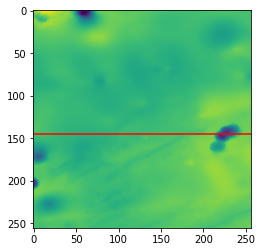

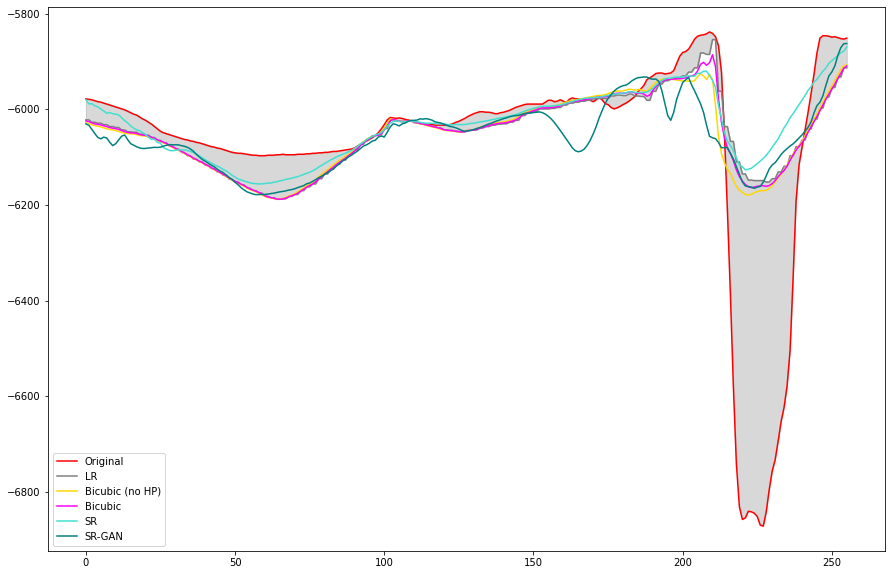

In [225]:
image =78
v_line=85
h_line = 145

plt.imshow(np.array(hr_denorm)[image,:,:,0])
#plt.axvline(v_line,color='red')
plt.axhline(h_line,color='red')

# a = np.array(hr_denorm)[image,:,v_line,0]
# b = np.array(lr_test_denorm)[image,:,v_line,0]
# x = np.arange(0,256,1)

# plt.figure(figsize=(15,10))
# plt.plot(a, label='Original', color='red')
# plt.plot(b, label='LR', color='gray')
# plt.fill_between(x, a, b, color ='gray', alpha=0.3)
# plt.plot(np.array(bicubic_nohalfpixel_denorm)[image,:,v_line,0], label='Bicubic (no HP)', color='gold')
# plt.plot(np.array(bicubic_denorm)[image,:,v_line,0], label='Bicubic', color='magenta')
# plt.plot(np.array(tf.squeeze(SR_pred_denorm))[image,:,v_line, 0 ], label='SR', color='turquoise') 
# plt.plot(np.array(tf.squeeze(SRGAN_pred_denorm))[image,:,v_line, 0], label='SR-GAN', color='teal')
# plt.legend()

a = np.array(hr_denorm)[image,h_line,:,0]
b = np.array(lr_test_denorm)[image,h_line,:,0]
x = np.arange(0,256,1)

plt.figure(figsize=(15,10))
plt.plot(a, label='Original', color='red')
plt.plot(b, label='LR', color='gray')
plt.fill_between(x, a, b, color ='gray', alpha=0.3)
#plt.plot(np.array(tf.squeeze(SR_degraded_pred_denorm))[image,h_line,:, 0], label='SR (trained with degraded LR)', color='lawngreen')
plt.plot(np.array(bicubic_nohalfpixel_denorm)[image,h_line,:,0], label='Bicubic (no HP)', color='gold')
plt.plot(np.array(bicubic_denorm)[image,h_line,:,0], label='Bicubic', color='magenta')
plt.plot(np.array(tf.squeeze(SR_pred_denorm))[image,h_line,:, 0 ], label='SR', color='turquoise') 
plt.plot(np.array(tf.squeeze(SRGAN_pred_denorm))[image,h_line,:, 0], label='SR-GAN', color='teal')

plt.legend()

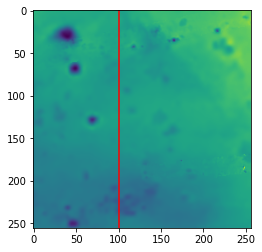

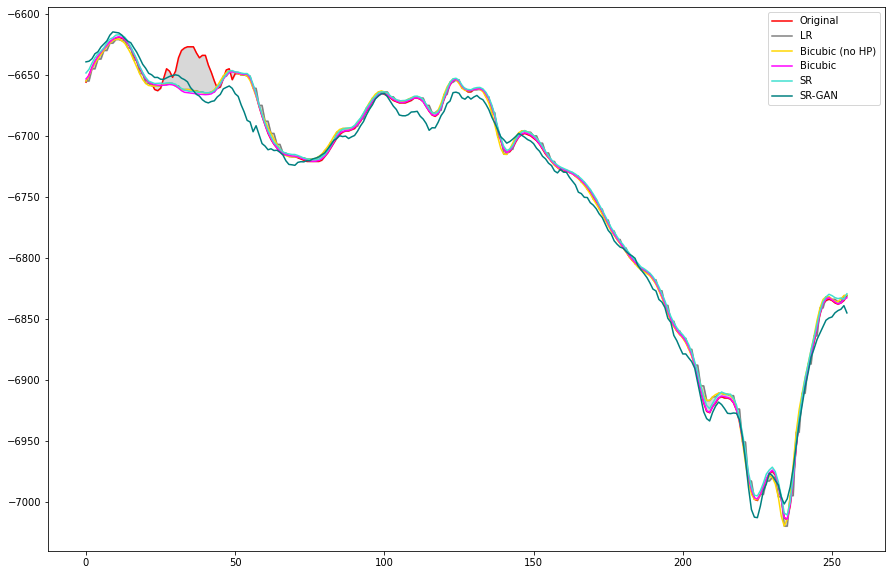

In [167]:
image =64
v_line=100
h_line = 100

plt.imshow(np.array(hr_denorm)[image,:,:,0])
plt.axvline(v_line,color='red')
#plt.axhline(h_line,color='red')

a = np.array(hr_denorm)[image,:,v_line,0]
b = np.array(lr_test_denorm)[image,:,v_line,0]
x = np.arange(0,256,1)

plt.figure(figsize=(15,10))
plt.plot(a, label='Original', color='red')
plt.plot(b, label='LR', color='gray')
plt.fill_between(x, a, b, color ='gray', alpha=0.3)
plt.plot(np.array(bicubic_nohalfpixel_denorm)[image,:,v_line,0], label='Bicubic (no HP)', color='gold')
plt.plot(np.array(bicubic_denorm)[image,:,v_line,0], label='Bicubic', color='magenta')
plt.plot(np.array(tf.squeeze(SR_pred_denorm))[image,:,v_line, 0 ], label='SR', color='turquoise') 
plt.plot(np.array(tf.squeeze(SRGAN_pred_denorm))[image,:,v_line, 0], label='SR-GAN', color='teal')
plt.legend()

# a = np.array(hr_denorm)[image,h_line,:,0]
# b = np.array(lr_test_denorm)[image,h_line,:,0]
# x = np.arange(0,256,1)

# plt.figure(figsize=(15,10))
# plt.plot(a, label='Original', color='red')
# plt.plot(b, label='LR', color='gray')
# plt.fill_between(x, a, b, color ='gray', alpha=0.3)
# plt.plot(np.array(bicubic_nohalfpixel_denorm)[image,h_line,:,0], label='Bicubic (no HP)', color='gold')
# plt.plot(np.array(bicubic_denorm)[image,h_line,:,0], label='Bicubic', color='magenta')
# plt.plot(np.array(tf.squeeze(SR_pred_denorm))[image,h_line,:, 0 ], label='SR', color='turquoise') 
# plt.plot(np.array(tf.squeeze(SRGAN_pred_denorm))[image,h_line,:, 0], label='SR-GAN', color='teal')
# plt.legend()

In [99]:

def plot_horizontal_line_plot(image, x_line):
    plt.figure(figsize=(15,10))
    a = np.array(hr_denorm)[image,x_line,:,0]
    b = np.array(lr_test_denorm)[image,x_line,:,0]
    x = np.arange(0,256,1)

    plt.figure(figsize=(15,10))
    plt.plot(a, label='Original', color='black')
    plt.plot(b, label='LR', color='gray')
    plt.fill_between(x, a, b, color ='gray', alpha=0.2)

    plt.plot(np.array(bicubic_nohalfpixel_denorm)[image,x_line,:,0], label='Bicubic (no HP)', color='gold')
    plt.plot(np.array(bicubic_denorm)[image,x_line,:,0], label='Bicubic', color='magenta')
    plt.plot(np.array(tf.squeeze(SR_pred_denorm))[image,x_line,:, 0], label='SR', color='turquoise') 
    plt.plot(np.array(tf.squeeze(SRGAN_pred_denorm))[image,x_line,:, 0], label='SR-GAN', color='teal')
   # plt.plot(np.array(hr_denorm)[image,x_line,:,0], label='Original', color='red')
   # plt.plot(np.array(lr_test_denorm)[image,x_line,:,0], label='LR', color='gray')
    plt.legend()

In [79]:

def plot_vertical_line_plot(image, x_line):
    plt.figure(figsize=(15,10))

    plt.plot(np.array(bicubic_nohalfpixel_denorm)[image,:,x_line,0], label='Bicubic (no HP)', color='gold')
    plt.plot(np.array(bicubic_denorm)[image,:,x_line,0], label='Bicubic', color='magenta')
    plt.plot(np.array(tf.squeeze(SR_pred_denorm))[image,:,x_line, 0 ], label='SR', color='turquoise') 
    plt.plot(np.array(tf.squeeze(SRGAN_pred_denorm))[image,:,x_line, 0], label='SR-GAN', color='teal')
    plt.plot(np.array(hr_denorm)[image,:,x_line,0], label='Original', color='red')
    plt.plot(np.array(lr_test_denorm)[image,:,x_line,0], label='LR', color='gray')
    plt.legend()

#### Example: Low-frequency HR 

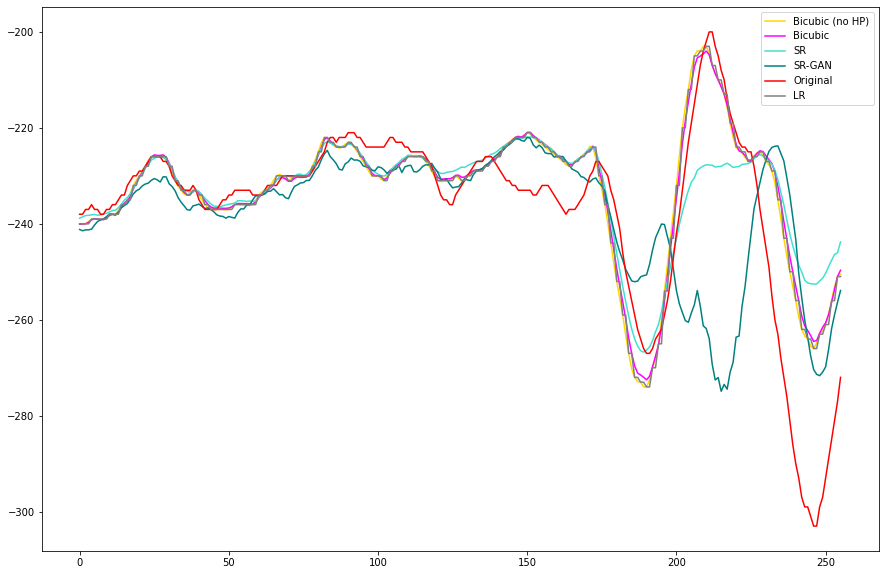

In [52]:
plot_vertical_line_plot(image=4, x_line=110)

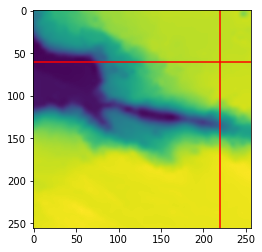

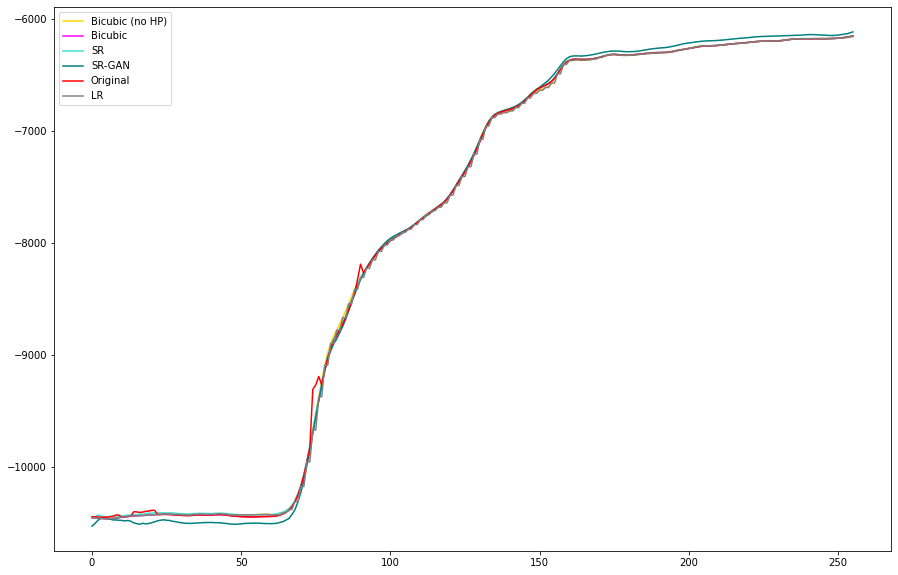

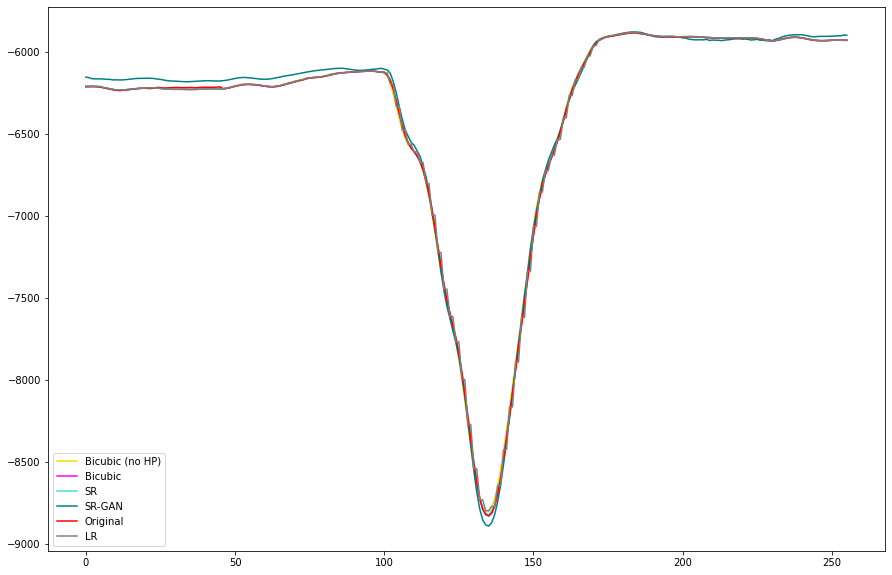

In [57]:
plt.imshow(np.array(tf.squeeze(SR_pred_denorm))[61,:,:,0])
plt.axhline(60,color='red')
plt.axvline(220,color='red')
plot_horizontal_line_plot(image=61, x_line=60)
plot_vertical_line_plot(image=61, x_line=220)

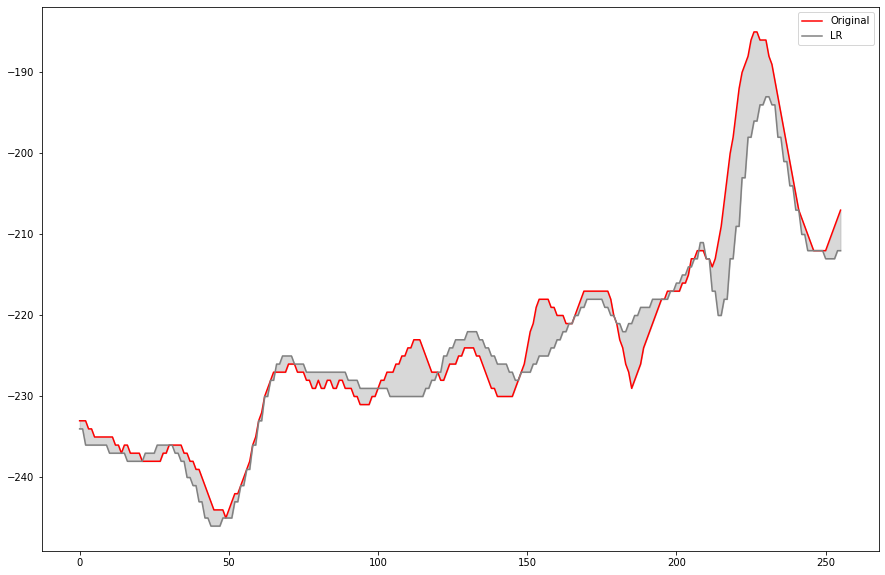

In [104]:
image = 4
x_line=100

a = np.array(hr_denorm)[image,x_line,:,0]
b = np.array(lr_test_denorm)[image,x_line,:,0]
x = np.arange(0,256,1)

plt.figure(figsize=(15,10))
plt.plot(a, label='Original', color='red')
plt.plot(b, label='LR', color='gray')
plt.fill_between(x, a, b, color ='gray', alpha=0.3)
plt.legend()

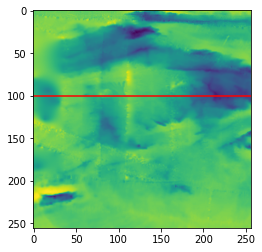

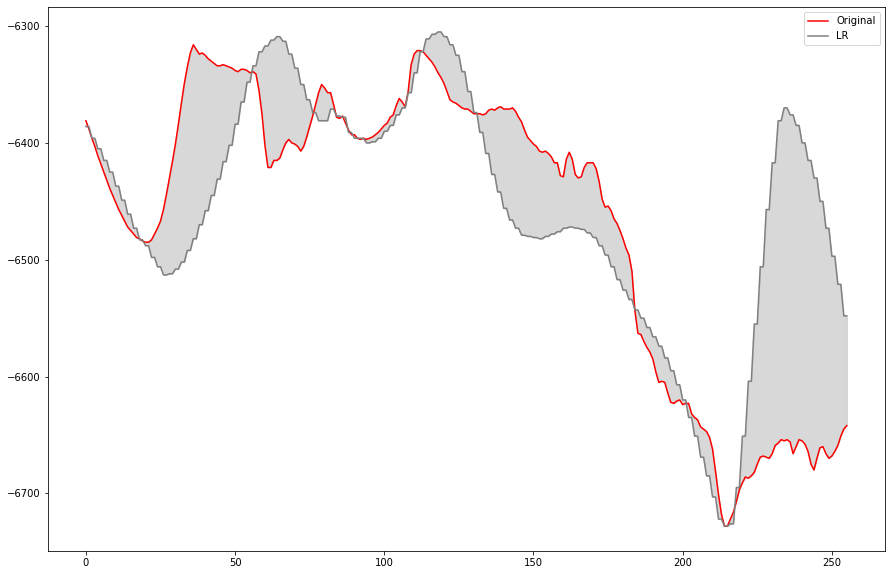

In [108]:
image = 72
x_line=100

plt.imshow(np.array(hr_denorm)[image,:,:,0])
plt.axhline(x_line,color='red')

a = np.array(hr_denorm)[image,x_line,:,0]
b = np.array(lr_test_denorm)[image,x_line,:,0]
x = np.arange(0,256,1)

plt.figure(figsize=(15,10))
plt.plot(a, label='Original', color='red')
plt.plot(b, label='LR', color='gray')
plt.fill_between(x, a, b, color ='gray', alpha=0.3)
plt.legend()

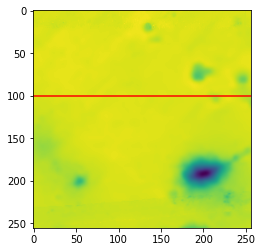

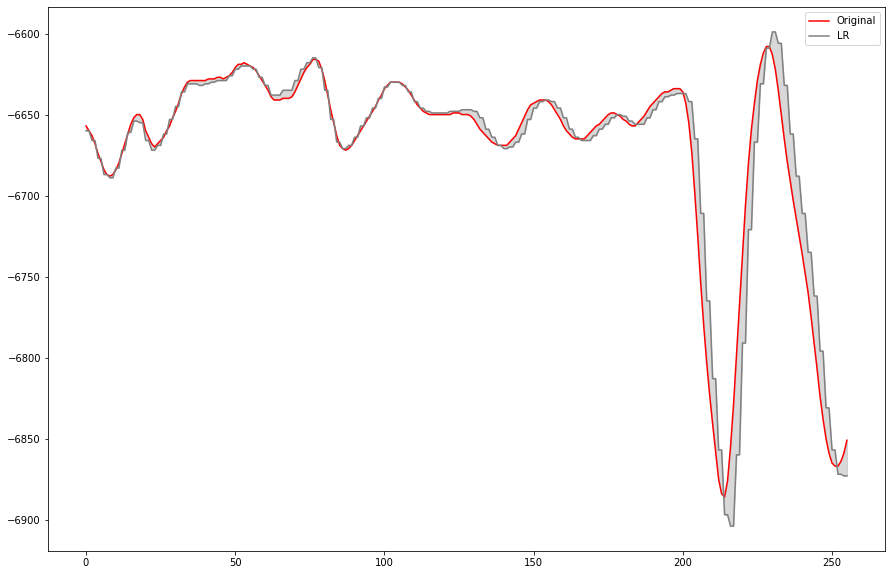

In [109]:
image = 66
x_line=100

plt.imshow(np.array(hr_denorm)[image,:,:,0])
plt.axhline(x_line,color='red')

a = np.array(hr_denorm)[image,x_line,:,0]
b = np.array(lr_test_denorm)[image,x_line,:,0]
x = np.arange(0,256,1)

plt.figure(figsize=(15,10))
plt.plot(a, label='Original', color='red')
plt.plot(b, label='LR', color='gray')
plt.fill_between(x, a, b, color ='gray', alpha=0.3)
plt.legend()

#### Example: Shiptracks

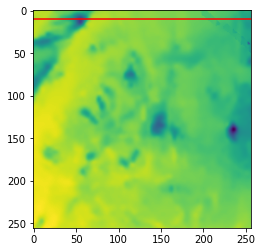

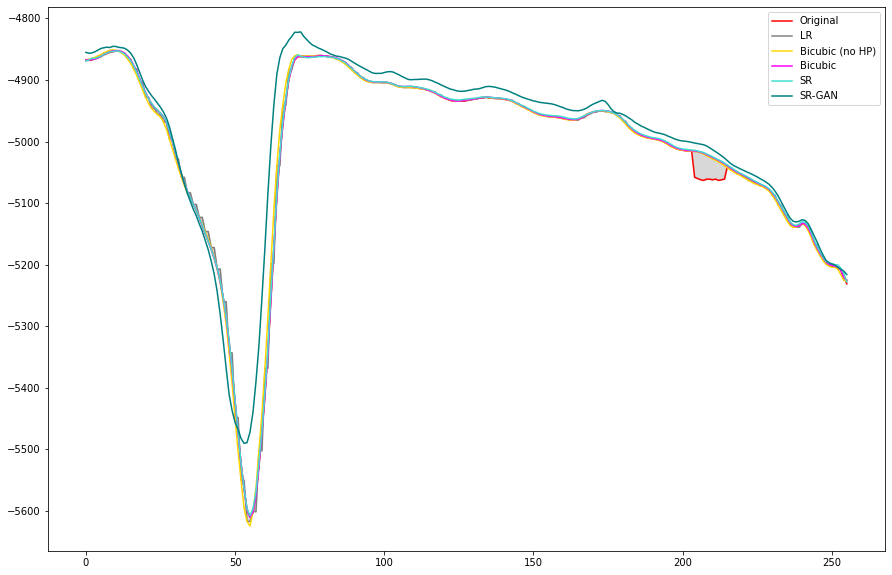

In [130]:
image =44
h_line=10

plt.imshow(np.array(hr_denorm)[image,:,:,0])
plt.axhline(h_line,color='red')

a = np.array(hr_denorm)[image,h_line,:,0]
b = np.array(lr_test_denorm)[image,h_line,:,0]
x = np.arange(0,256,1)

plt.figure(figsize=(15,10))
plt.plot(a, label='Original', color='red')
plt.plot(b, label='LR', color='gray')
plt.fill_between(x, a, b, color ='gray', alpha=0.3)
plt.plot(np.array(bicubic_nohalfpixel_denorm)[image,h_line,:,0], label='Bicubic (no HP)', color='gold')
plt.plot(np.array(bicubic_denorm)[image,h_line,:,0], label='Bicubic', color='magenta')
plt.plot(np.array(tf.squeeze(SR_pred_denorm))[image,h_line,:, 0 ], label='SR', color='turquoise') 
plt.plot(np.array(tf.squeeze(SRGAN_pred_denorm))[image,h_line,:, 0], label='SR-GAN', color='teal')
plt.legend()

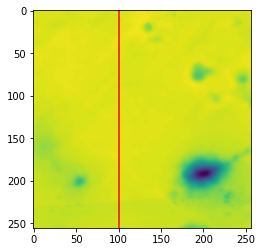

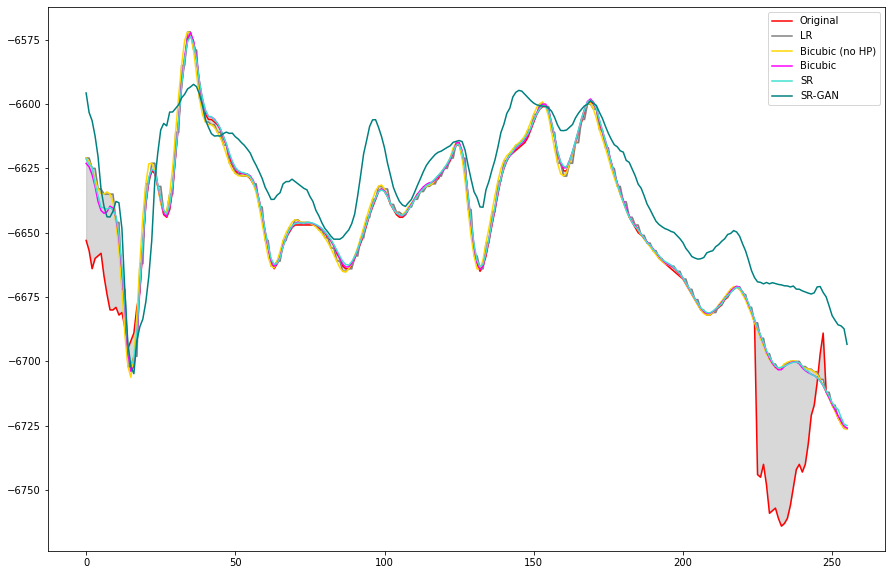

In [146]:
image = 66
v_line=100

plt.imshow(np.array(hr_denorm)[image,:,:,0])
plt.axvline(v_line,color='red')

a = np.array(hr_denorm)[image,:,v_line,0]
b = np.array(lr_test_denorm)[image,:,v_line,0]
x = np.arange(0,256,1)

plt.figure(figsize=(15,10))
plt.plot(a, label='Original', color='red')
plt.plot(b, label='LR', color='gray')
plt.fill_between(x, a, b, color ='gray', alpha=0.3)
plt.plot(np.array(bicubic_nohalfpixel_denorm)[image,:,v_line,0], label='Bicubic (no HP)', color='gold')
plt.plot(np.array(bicubic_denorm)[image,:,v_line,0], label='Bicubic', color='magenta')
plt.plot(np.array(tf.squeeze(SR_pred_denorm))[image,:,v_line, 0 ], label='SR', color='turquoise') 
plt.plot(np.array(tf.squeeze(SRGAN_pred_denorm))[image,:,v_line, 0], label='SR-GAN', color='teal')
plt.legend()

## Lineplots Pangaea

In [36]:
def line_plot(HR_file_path, SR_model, SRGAN_model, image, x_line): 
    
    hr, lr, lr_denorm, hr_denorm = load_test_dataset_with_degraded_LR(HR_file_path=file_path)
   # LR_file_path = file_paths['test_x2']['LR']
   # hr, lr, lr_denorm, hr_denorm = load_dataset_with_real_LR(HR_file_path=HR_file_path, LR_file_path=LR_file_path, remove=remove)
    
    lr_test = tf.image.resize(lr, [Params['hr_dimension'], Params['hr_dimension']],method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    lr_test_denorm = denorm(lr_test)
    
    bicubic = tf.image.resize(lr, [Params['hr_dimension'], Params['hr_dimension']],method=tf.image.ResizeMethod.BICUBIC)
    bicubic_denorm = denorm(bicubic)

    bicubic_nohalfpixel = tf.compat.v1.image.resize_bicubic(lr, [Params['hr_dimension'], Params['hr_dimension']])
    bicubic_nohalfpixel_denorm = denorm(bicubic_nohalfpixel)

    SR_pred = calculate_prediction(lr, SR_model)
    SR_pred_denorm = denorm(SR_pred)
    
    SRGAN_pred = calculate_prediction(lr, SRGAN_model)
    SRGAN_pred_denorm = denorm(SRGAN_pred)
    
    plt.figure(figsize=(15,10))
    
    x = np.zeros(51)
    for i in range(len(x)):
        x[i] = -7300

    plt.plot(np.array(bicubic_nohalfpixel_denorm)[image,x_line,:,0], label='Bicubic (no HP)', color='gold')
    plt.plot(np.array(bicubic_denorm)[image,x_line,:,0], label='Bicubic', color='magenta')
    plt.plot(np.array(tf.squeeze(SR_pred_denorm))[image,x_line,:,0], label='SR', color='turquoise') 
    plt.plot(np.array(tf.squeeze(SRGAN_pred_denorm))[image,x_line,:,0], label='SR-GAN', color='teal')
    plt.plot(np.array(hr_denorm)[image,x_line,:,0], label='Original', color='red')
    plt.plot(np.array(lr_test_denorm)[image,x_line,:,0], label='LR', color='gray', alpha=0.2)
    plt.legend()
    
#     fig = plt.figure(figsize=(80,5))
#     grid = ImageGrid(fig, 111,  # similar to subplot(111)
#                  nrows_ncols=(1, 4),  # creates 2x2 grid of axes
#                  axes_pad=0.1,  # pad between axes in inch.
#                  )
#     grid[0].plot(np.array(bicubic_denorm)[image,x_line,:,0], label='Bicubic', color='darkorange')
#     grid[0].plot(np.array(hr_denorm)[image,x_line,:,0], label='Original', color='red')
    
#     grid[1].plot(np.array(bicubic_nohalfpixel_denorm)[image,x_line,:,0], label='Bicubic (no HP)', color='gold')
#     grid[1].plot(np.array(hr_denorm)[image,x_line,:,0], label='Original', color='red')
    
#     grid[2].plot(np.array(tf.squeeze(SR_pred_denorm))[image,x_line,:,0], label='SR', color='turquoise')
#     grid[2].plot(np.array(hr_denorm)[image,x_line,:,0], label='Original', color='red')
    
#     grid[3].plot(np.array(tf.squeeze(SRGAN_pred_denorm))[image,x_line,:,0], label='SR-GAN', color='teal')
#     grid[3].plot(np.array(hr_denorm)[image,x_line,:,0], label='Original', color='red')


HR Test Samples:  16 Files found
HR Dataset Shape:  (16, 256, 256, 3)
Upscale x 2  LR Dataset Shape:  (16, 128, 128, 3)


NameError: name 'SR_256_x4_model' is not defined

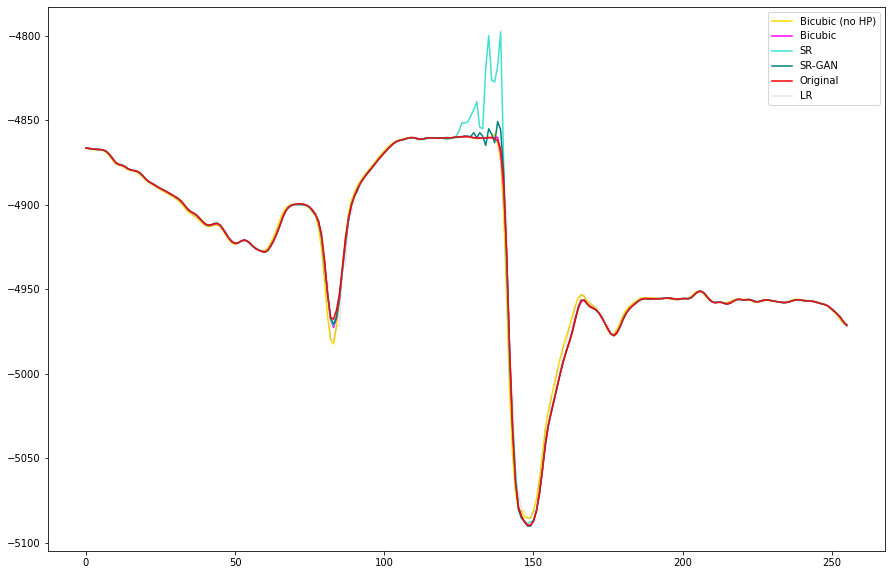

In [37]:
image = 10
line = 160
Params['scale'] = 2
line_plot(HR_file_path=file_paths['HR_test_256'], SR_model= SR_256_x2_model, SRGAN_model = SR_x2_new, image = image, x_line= line)
Params['scale'] = 4
line_plot(HR_file_path=file_paths['HR_test_256'], SR_model= SR_256_x4_model, SRGAN_model = SRGAN_256_x4_model, image = image, x_line= line)
Params['scale'] = 8
line_plot(HR_file_path=file_paths['HR_test_256'], SR_model= SR_256_x8_model, SRGAN_model = SRGAN_256_x8_model, image = image, x_line= line)

HR Test Samples:  16 Files found
HR Dataset Shape:  (16, 256, 256, 3)
Upscale x 2  LR Dataset Shape:  (16, 128, 128, 3)
HR Test Samples:  16 Files found
HR Dataset Shape:  (16, 256, 256, 3)
Upscale x 4  LR Dataset Shape:  (16, 64, 64, 3)
HR Test Samples:  16 Files found
HR Dataset Shape:  (16, 256, 256, 3)
Upscale x 8  LR Dataset Shape:  (16, 32, 32, 3)


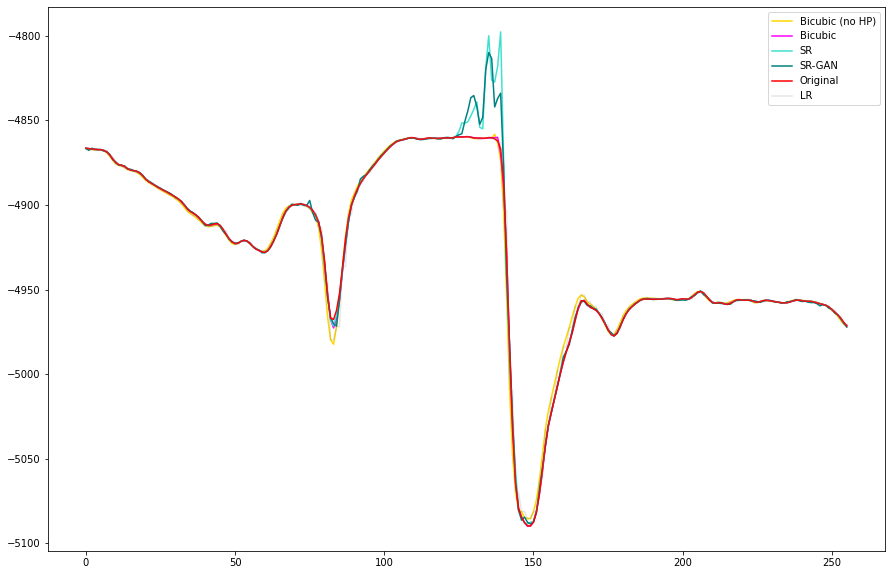

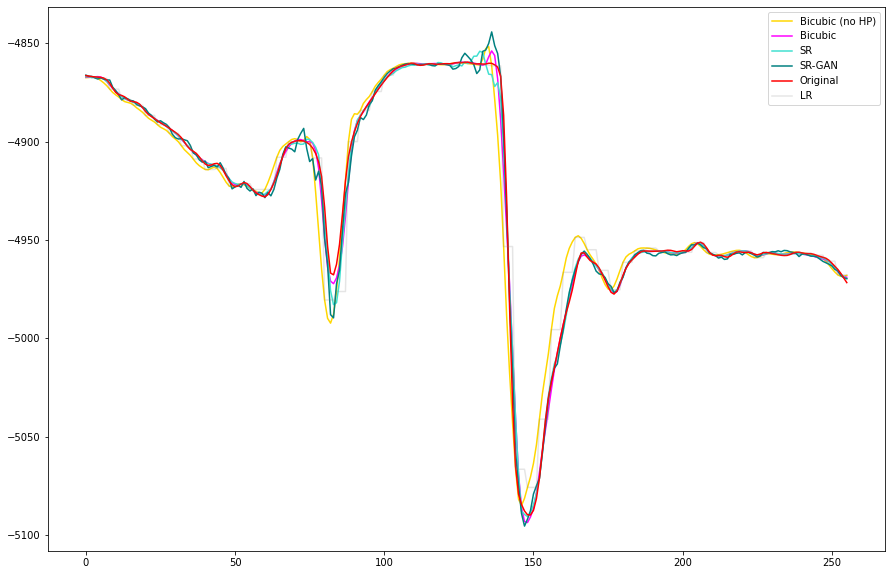

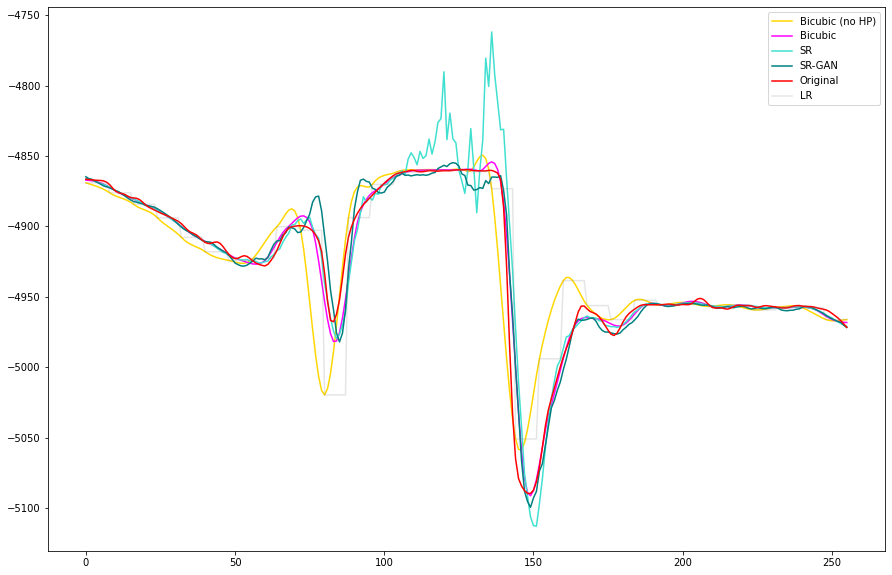

In [271]:
image = 10
line = 160
Params['scale'] = 2
line_plot(HR_file_path=file_paths['HR_test_256'], SR_model= SR_256_x2_model, SRGAN_model = SRGAN_256_x2_model, image = image, x_line= line)
Params['scale'] = 4
line_plot(HR_file_path=file_paths['HR_test_256'], SR_model= SR_256_x4_model, SRGAN_model = SRGAN_256_x4_model, image = image, x_line= line)
Params['scale'] = 8
line_plot(HR_file_path=file_paths['HR_test_256'], SR_model= SR_256_x8_model, SRGAN_model = SRGAN_256_x8_model, image = image, x_line= line)

In [222]:
image = 0
line = 150

HR Test Samples:  16 Files found
HR Dataset Shape:  (16, 256, 256, 3)
Upscale x 2  LR Dataset Shape:  (16, 128, 128, 3)
HR Test Samples:  16 Files found
HR Dataset Shape:  (16, 256, 256, 3)
Upscale x 4  LR Dataset Shape:  (16, 64, 64, 3)
HR Test Samples:  16 Files found
HR Dataset Shape:  (16, 256, 256, 3)
Upscale x 8  LR Dataset Shape:  (16, 32, 32, 3)


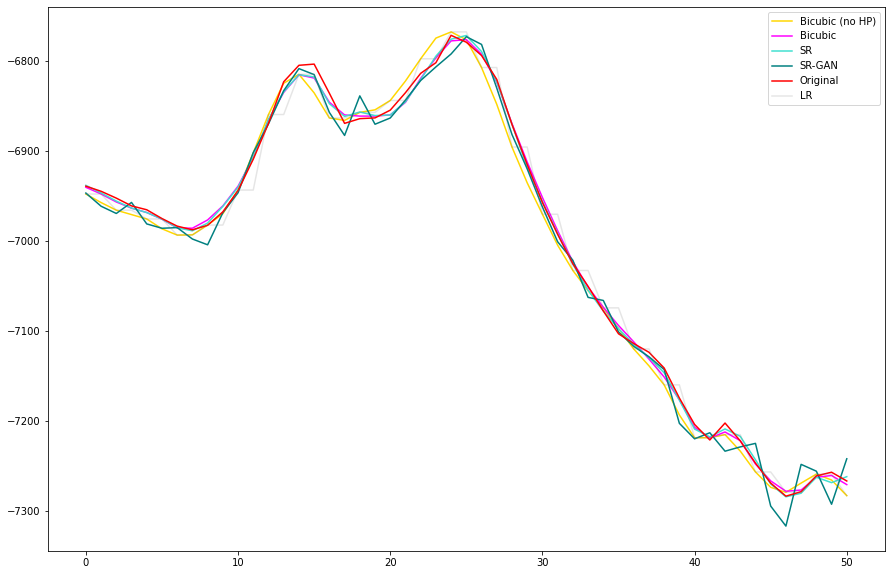

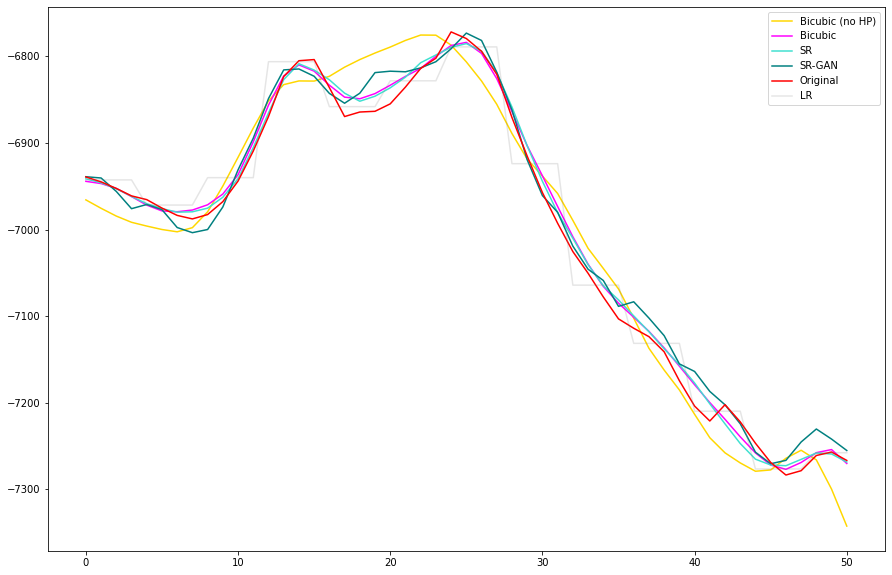

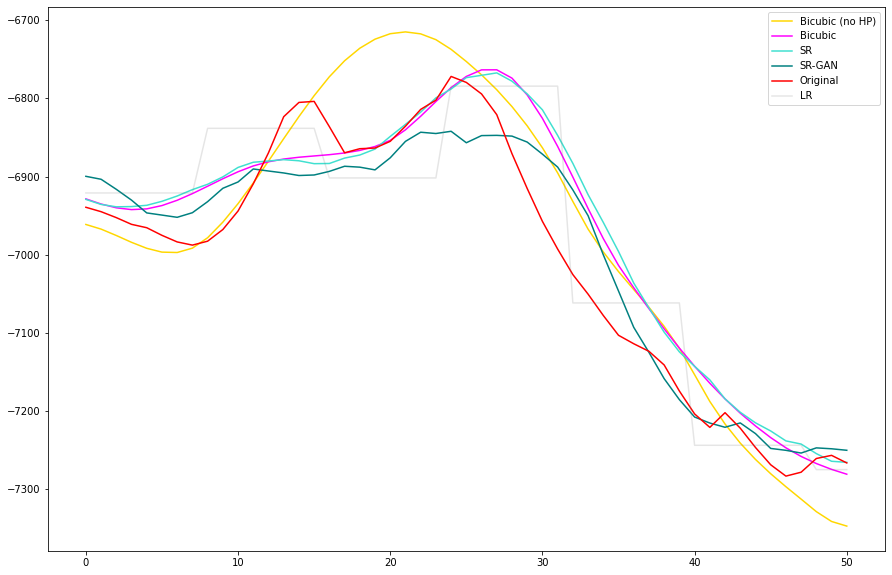

In [267]:
Params['scale'] = 2
line_plot(HR_file_path=file_paths['HR_test_256'], SR_model= SR_256_x2_model, SRGAN_model = SRGAN_256_x2_model, image = image, x_line= line)
Params['scale'] = 4
line_plot(HR_file_path=file_paths['HR_test_256'], SR_model= SR_256_x4_model, SRGAN_model = SRGAN_256_x4_model, image = image, x_line= line)
Params['scale'] = 8
line_plot(HR_file_path=file_paths['HR_test_256'], SR_model= SR_256_x8_model, SRGAN_model = SRGAN_256_x8_model, image = image, x_line= line)

HR Test Samples:  16 Files found
HR Dataset Shape:  (16, 256, 256, 3)
Upscale x 2  LR Dataset Shape:  (16, 128, 128, 3)
HR Test Samples:  16 Files found
HR Dataset Shape:  (16, 256, 256, 3)
Upscale x 4  LR Dataset Shape:  (16, 64, 64, 3)
HR Test Samples:  16 Files found
HR Dataset Shape:  (16, 256, 256, 3)
Upscale x 8  LR Dataset Shape:  (16, 32, 32, 3)


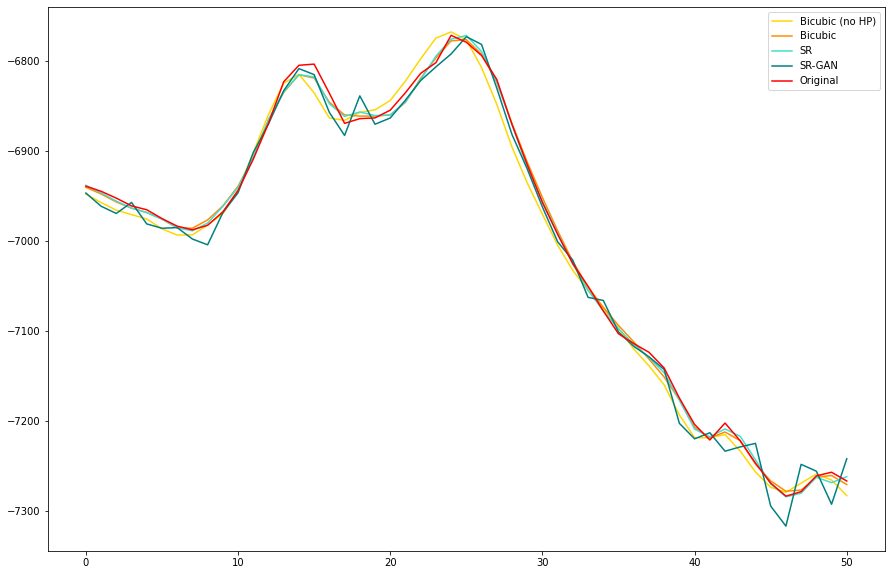

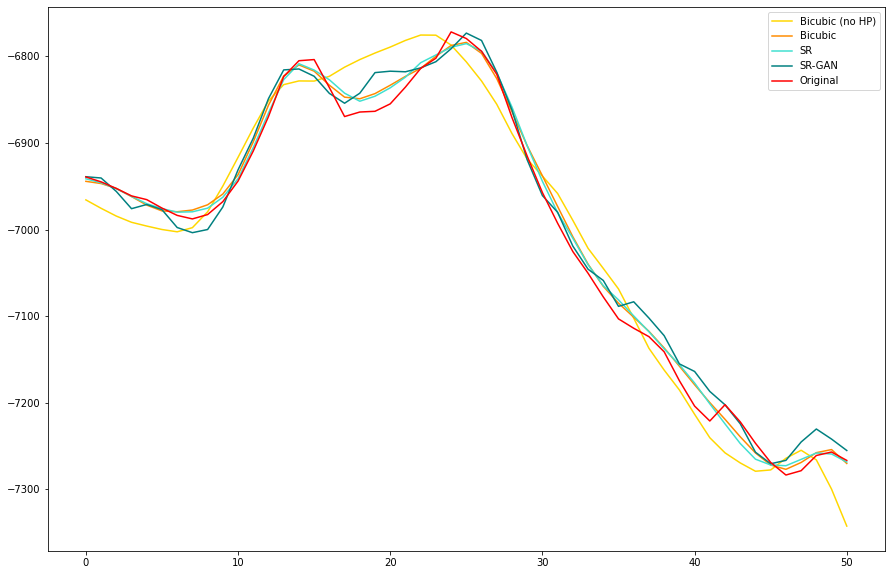

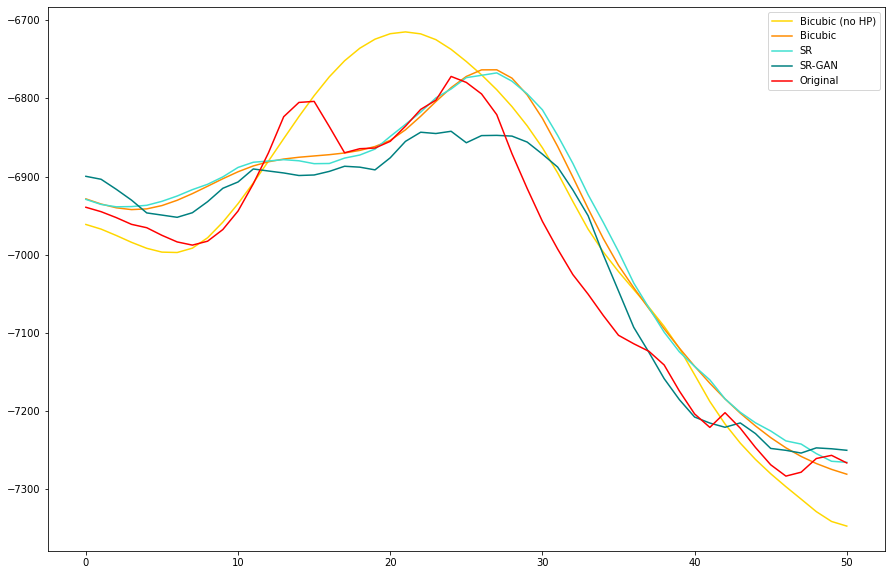

In [227]:
Params['scale'] = 2
line_plot(HR_file_path=file_paths['HR_test_256'], SR_model= SR_256_x2_model, SRGAN_model = SRGAN_256_x2_model, image = image, x_line= line)
Params['scale'] = 4
line_plot(HR_file_path=file_paths['HR_test_256'], SR_model= SR_256_x4_model, SRGAN_model = SRGAN_256_x4_model, image = image, x_line= line)
Params['scale'] = 8
line_plot(HR_file_path=file_paths['HR_test_256'], SR_model= SR_256_x8_model, SRGAN_model = SRGAN_256_x8_model, image = image, x_line= line)

HR Test Samples:  16 Files found
HR Dataset Shape:  (16, 256, 256, 3)
Upscale x 2  LR Dataset Shape:  (16, 128, 128, 3)
HR Test Samples:  16 Files found
HR Dataset Shape:  (16, 256, 256, 3)
Upscale x 4  LR Dataset Shape:  (16, 64, 64, 3)
HR Test Samples:  16 Files found
HR Dataset Shape:  (16, 256, 256, 3)
Upscale x 8  LR Dataset Shape:  (16, 32, 32, 3)


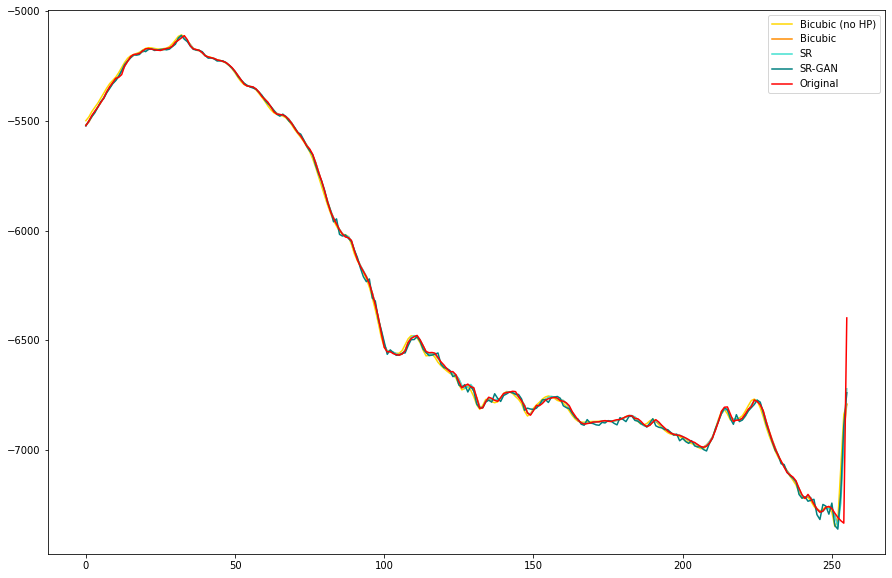

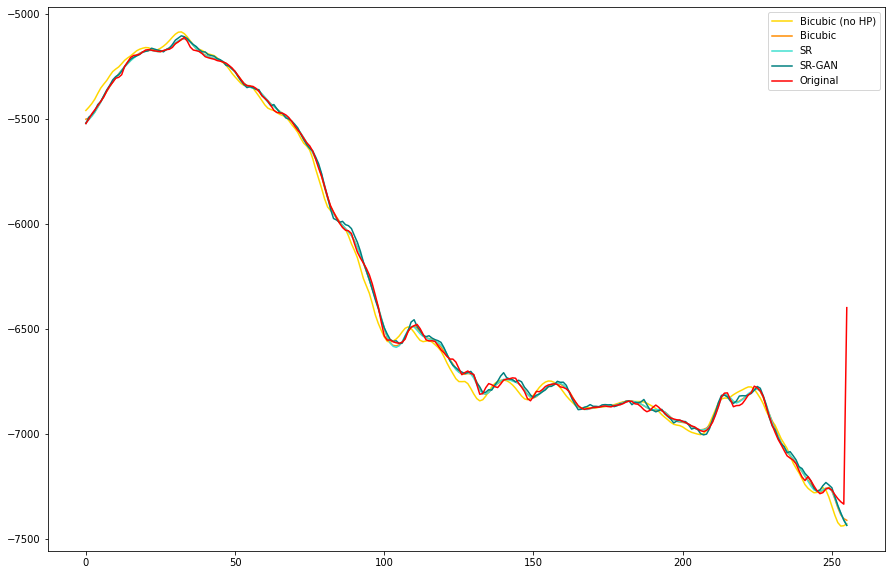

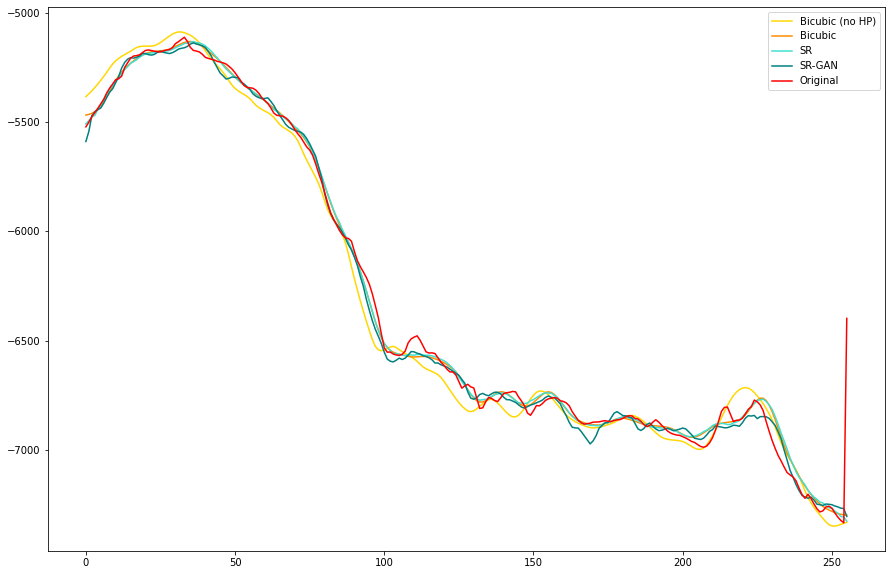

In [223]:
Params['scale'] = 2
line_plot(HR_file_path=file_paths['HR_test_256'], SR_model= SR_256_x2_model, SRGAN_model = SRGAN_256_x2_model, image = image, x_line= line)
Params['scale'] = 4
line_plot(HR_file_path=file_paths['HR_test_256'], SR_model= SR_256_x4_model, SRGAN_model = SRGAN_256_x4_model, image = image, x_line= line)
Params['scale'] = 8
line_plot(HR_file_path=file_paths['HR_test_256'], SR_model= SR_256_x8_model, SRGAN_model = SRGAN_256_x8_model, image = image, x_line= line)

HR Test Samples:  16 Files found
HR Dataset Shape:  (16, 256, 256, 3)
Upscale x 2  LR Dataset Shape:  (16, 128, 128, 3)
HR Test Samples:  16 Files found
HR Dataset Shape:  (16, 256, 256, 3)
Upscale x 4  LR Dataset Shape:  (16, 64, 64, 3)
HR Test Samples:  16 Files found
HR Dataset Shape:  (16, 256, 256, 3)
Upscale x 8  LR Dataset Shape:  (16, 32, 32, 3)


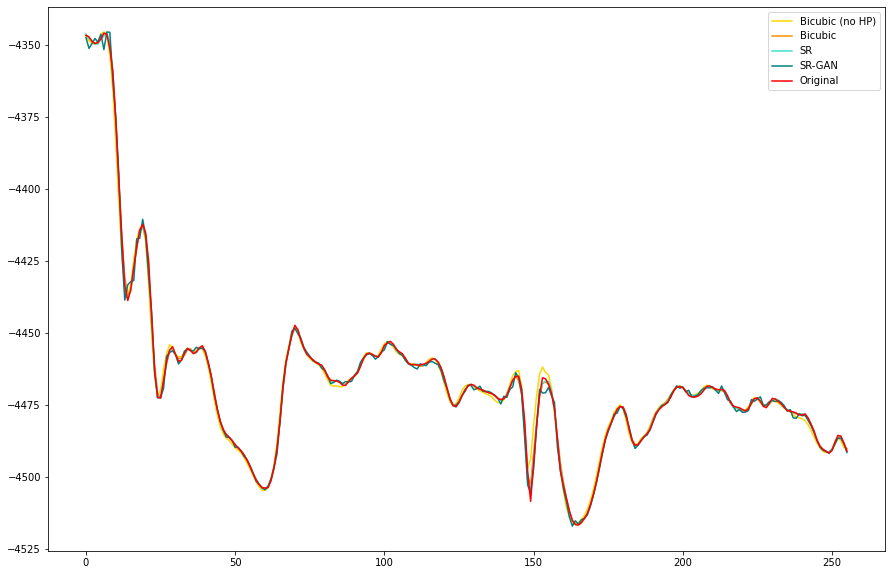

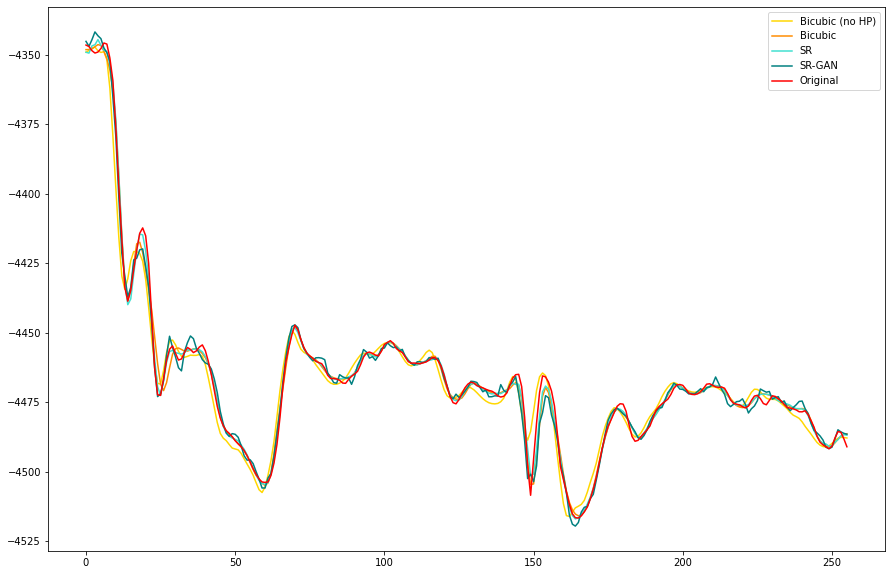

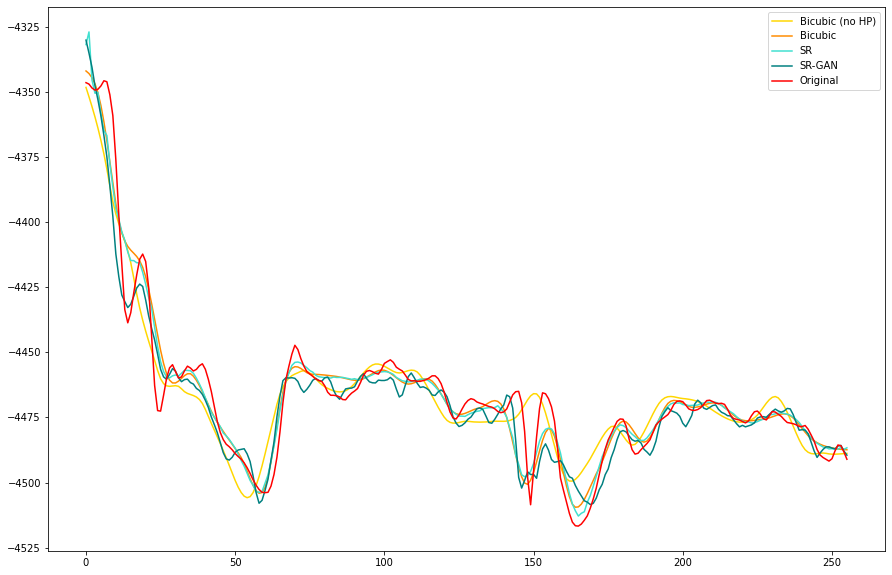

In [221]:
image = 1
line = 150
Params['scale'] = 2
line_plot(HR_file_path=file_paths['HR_test_256'], SR_model= SR_256_x2_model, SRGAN_model = SRGAN_256_x2_model, image = image, x_line= line)
Params['scale'] = 4
line_plot(HR_file_path=file_paths['HR_test_256'], SR_model= SR_256_x4_model, SRGAN_model = SRGAN_256_x4_model, image = image, x_line= line)
Params['scale'] = 8
line_plot(HR_file_path=file_paths['HR_test_256'], SR_model= SR_256_x8_model, SRGAN_model = SRGAN_256_x8_model, image = image, x_line= line)

HR Test Samples:  16 Files found
HR Dataset Shape:  (16, 256, 256, 3)
Upscale x 2  LR Dataset Shape:  (16, 128, 128, 3)


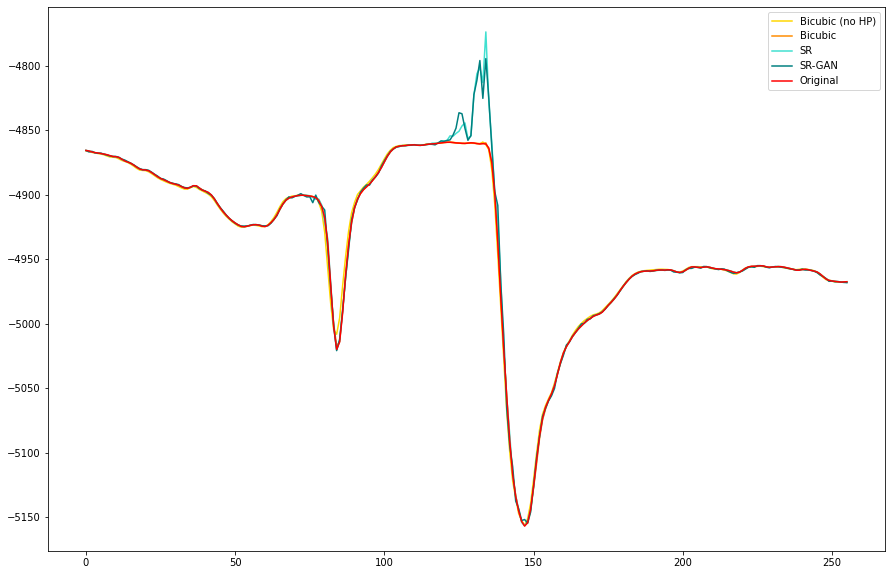

In [215]:
line_plot(HR_file_path=file_paths['HR_test_256'], SR_model= SR_256_x2_model, SRGAN_model = SRGAN_256_x2_model, image = 10, x_line= 150)

HR Test Samples:  16 Files found
HR Dataset Shape:  (16, 256, 256, 3)
Upscale x 4  LR Dataset Shape:  (16, 64, 64, 3)


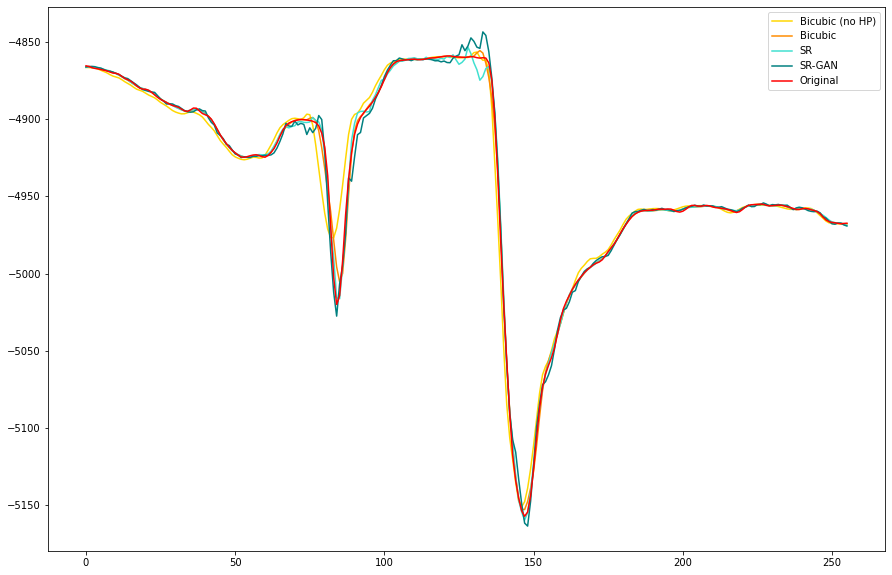

In [218]:
line_plot(HR_file_path=file_paths['HR_test_256'], SR_model= SR_256_x4_model, SRGAN_model = SRGAN_256_x4_model, image = 10, x_line= 150)

HR Test Samples:  16 Files found
HR Dataset Shape:  (16, 256, 256, 3)
Upscale x 8  LR Dataset Shape:  (16, 32, 32, 3)


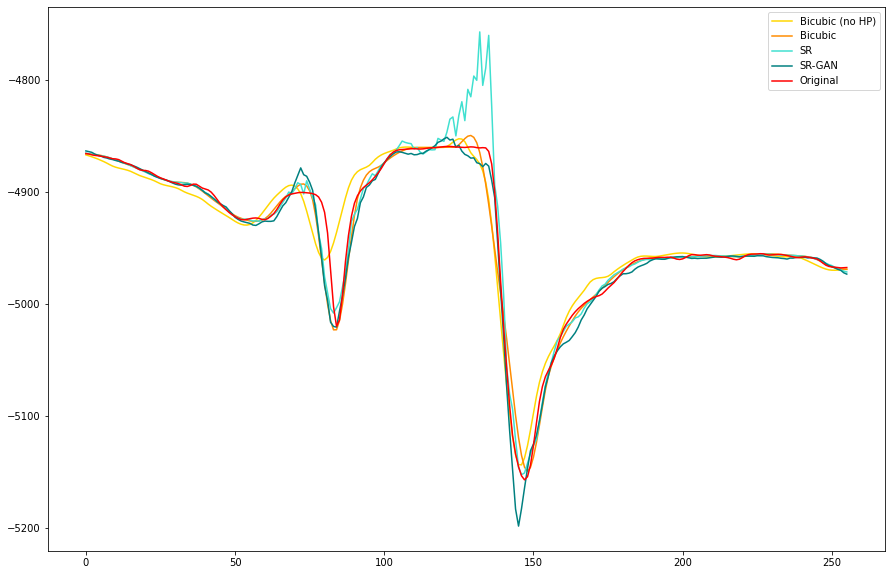

In [134]:
line_plot(HR_file_path=file_paths['HR_test_256'], SR_model= SR_256_x8_model, SRGAN_model = SRGAN_256_x8_model, image = 10, x_line= 180)

HR Test Samples:  16 Files found
HR Dataset Shape:  (16, 256, 256, 3)
Upscale x 8  LR Dataset Shape:  (16, 32, 32, 3)


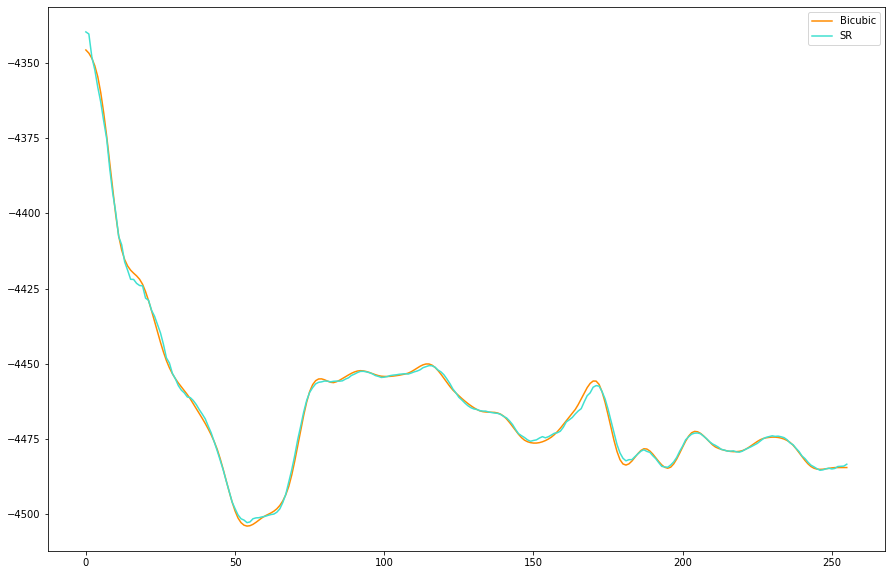

In [152]:
line_plot(HR_file_path=file_paths['HR_test_256'], SR_model= SR_256_x8_model, SRGAN_model = SRGAN_256_x8_model, image = 1, x_line= 165)

HR Test Samples:  16 Files found
HR Dataset Shape:  (16, 256, 256, 3)
Upscale x 8  LR Dataset Shape:  (16, 32, 32, 3)


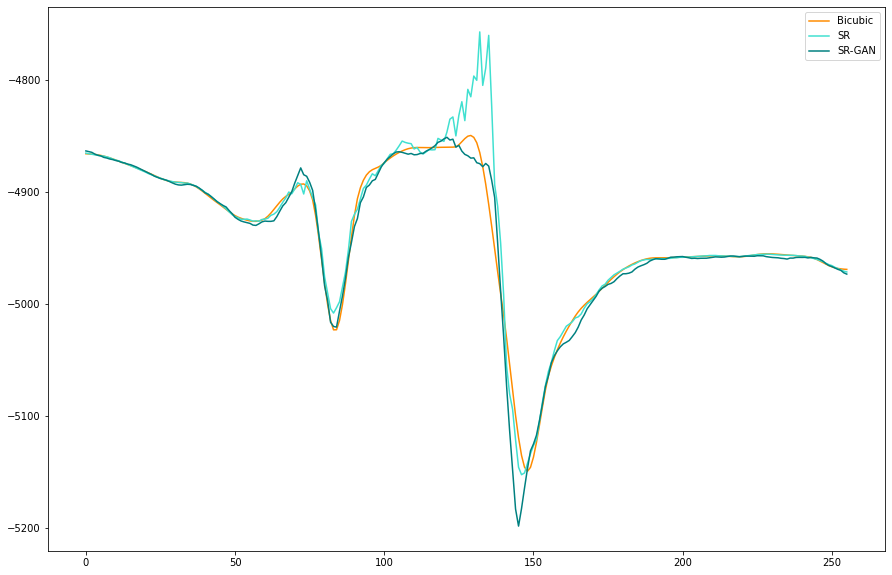

In [154]:
line_plot(HR_file_path=file_paths['HR_test_256'], SR_model= SR_256_x8_model, SRGAN_model = SRGAN_256_x8_model, image = 10, x_line= 150)

HR Test Samples:  16 Files found
HR Dataset Shape:  (16, 256, 256, 3)
Upscale x 8  LR Dataset Shape:  (16, 32, 32, 3)


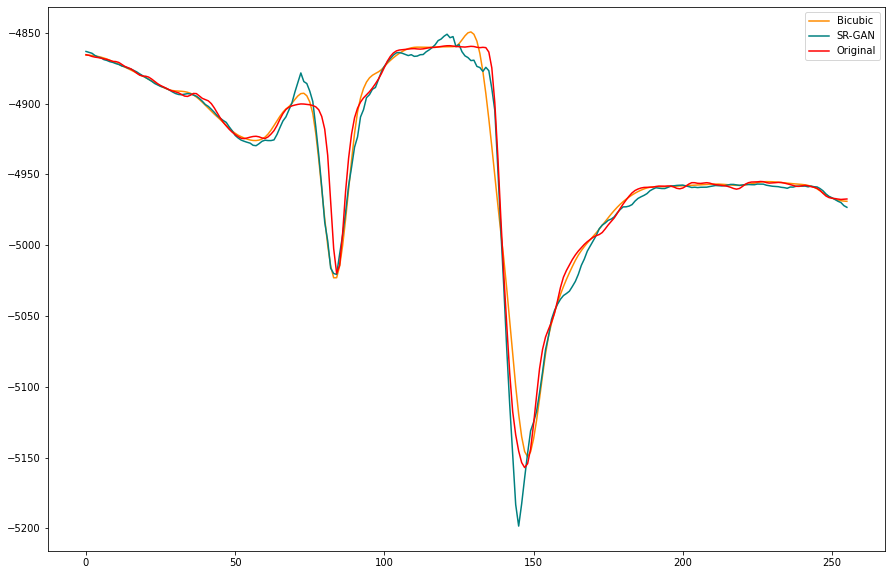

In [156]:
line_plot(HR_file_path=file_paths['HR_test_256'], SR_model= SR_256_x8_model, SRGAN_model = SRGAN_256_x8_model, image = 10, x_line= 150)

HR Test Samples:  16 Files found
HR Dataset Shape:  (16, 256, 256, 3)
Upscale x 8  LR Dataset Shape:  (16, 32, 32, 3)


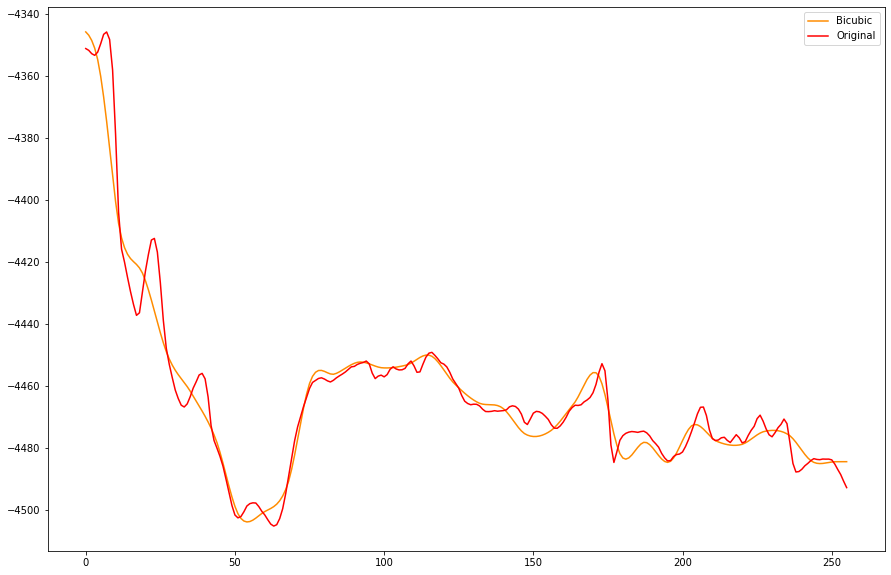

In [148]:
line_plot(HR_file_path=file_paths['HR_test_256'], SR_model= SR_256_x8_model, SRGAN_model = SRGAN_256_x8_model, image = 1, x_line= 165)

HR Test Samples:  16 Files found
HR Dataset Shape:  (16, 256, 256, 3)
Upscale x 8  LR Dataset Shape:  (16, 32, 32, 3)


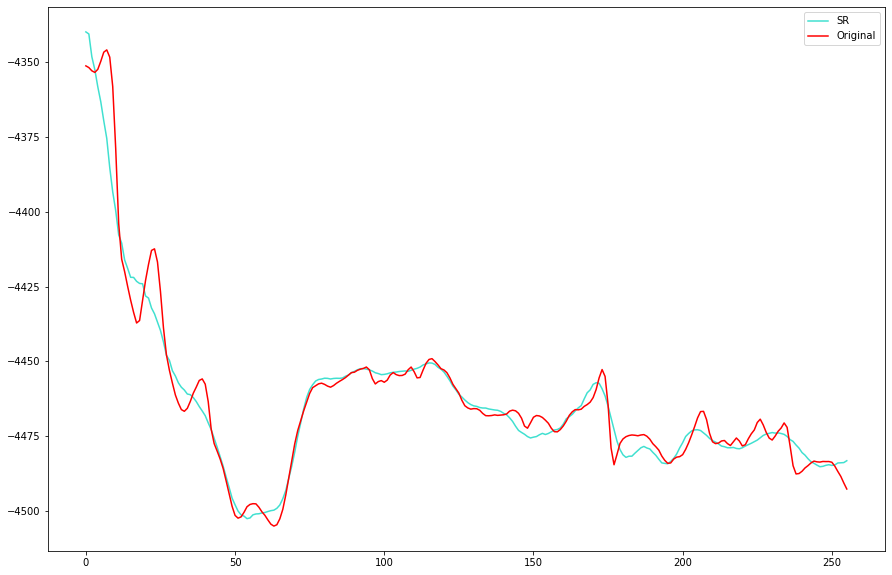

In [146]:
line_plot(HR_file_path=file_paths['HR_test_256'], SR_model= SR_256_x8_model, SRGAN_model = SRGAN_256_x8_model, image = 1, x_line= 165)

HR Test Samples:  16 Files found
HR Dataset Shape:  (16, 256, 256, 3)
Upscale x 8  LR Dataset Shape:  (16, 32, 32, 3)


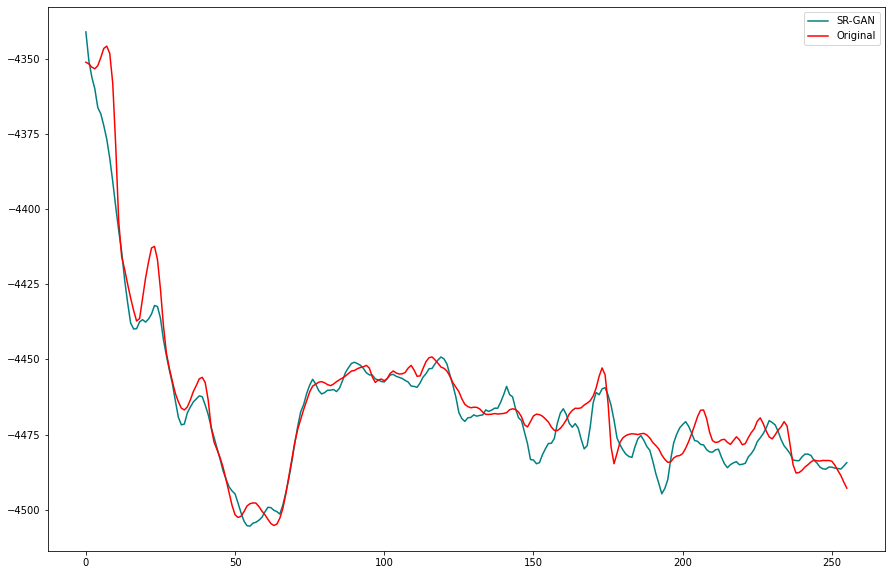

In [144]:
line_plot(HR_file_path=file_paths['HR_test_256'], SR_model= SR_256_x8_model, SRGAN_model = SRGAN_256_x8_model, image = 1, x_line= 165)

HR Test Samples:  16 Files found
HR Dataset Shape:  (16, 256, 256, 3)
Upscale x 8  LR Dataset Shape:  (16, 32, 32, 3)


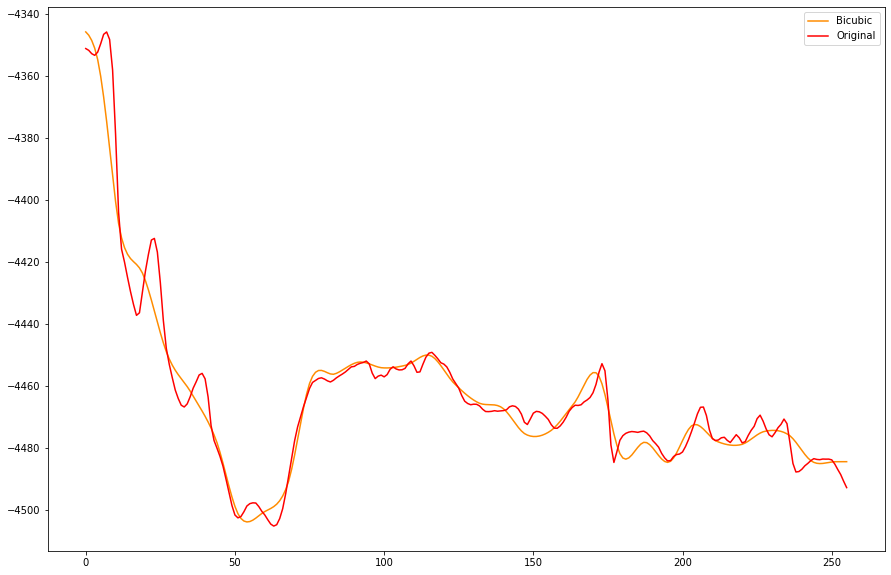

In [142]:
line_plot(HR_file_path=file_paths['HR_test_256'], SR_model= SR_256_x8_model, SRGAN_model = SRGAN_256_x8_model, image = 1, x_line= 165)

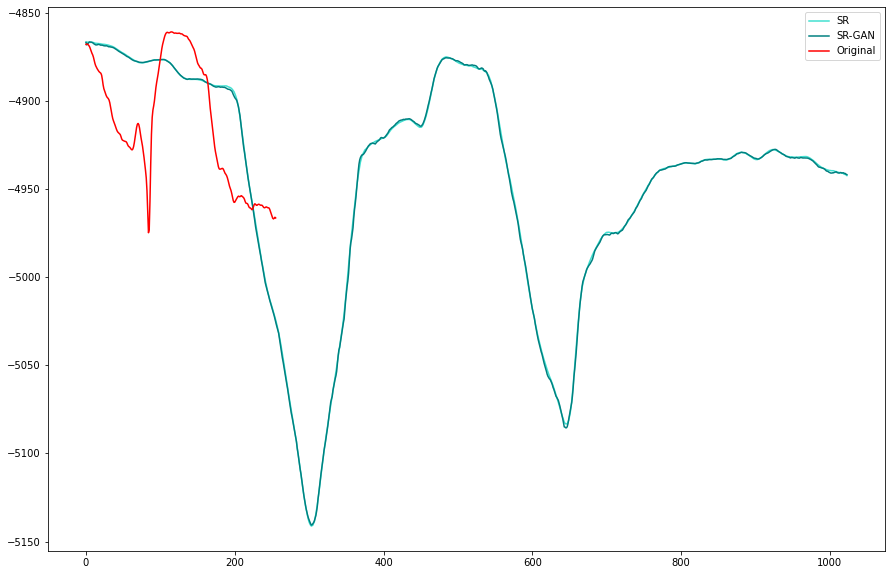

In [138]:
plt.figure(figsize=(15,10))

#plt.plot(np.array(bicubic_nohalfpixel_denorm)[image,x_line,:,0], label='Bicubic (no HP)', color='gold')
#plt.plot(np.array(bicubic_denorm)[image,x_line,:,0], label='Bicubic', color='darkorange')
plt.plot(np.array(tf.squeeze(SR_pred_denorm))[image,x_line,:,0], label='SR', color='turquoise') 
plt.plot(np.array(tf.squeeze(SRGAN_pred_denorm))[image,x_line,:,0], label='SR-GAN', color='teal')
plt.plot(np.array(hr_denorm)[image,x_line,:,0], label='Original', color='red')
plt.legend()

In [115]:
#%matplotlib widget
import ipywidgets as widgets

def plot_horizontal_line(image, x_line):
    plt.figure(figsize=(15,10))
    plt.plot(np.array(bicubic_nohalfpixel_denorm)[image,x_line,:,0], label='Bicubic (no HP)', color='gold')
    plt.plot(np.array(tf.squeeze(SR_pred_denorm))[image,x_line,:,0], label='SR', color='turquoise')
    plt.plot(np.array(tf.squeeze(SRGAN_pred_denorm))[image,x_line,:,0], label='SR-GAN', color='teal')
    plt.plot(np.array(hr_denorm)[image,x_line,:,0], label='Original', color='orange')
    plt.legend()
    
_ = widgets.interact(plot_horizontal_line, 
                 image=(0, 15, 1), 
                 x_line=(0,256,1), 
                )

In [128]:
HR_file_path=file_paths['HR_test_256'] 
SR_model= SR_256_x8_model 
SRGAN_model = SRGAN_256_x8_model 
image = 10
x_line= 180

hr, lr, lr_denorm, hr_denorm = load_test_dataset_with_degraded_LR(HR_file_path=HR_file_path)

bicubic = tf.image.resize(lr, [Params['hr_dimension'], Params['hr_dimension']],method=tf.image.ResizeMethod.BICUBIC)
bicubic_denorm = denorm(bicubic)

bicubic_nohalfpixel = tf.compat.v1.image.resize_bicubic(lr, [Params['hr_dimension'], Params['hr_dimension']])
bicubic_nohalfpixel_denorm = denorm(bicubic_nohalfpixel)

SR_pred = calculate_prediction(lr, SR_model)
SR_pred_denorm = denorm(SR_pred)

SRGAN_pred = calculate_prediction(lr, SRGAN_model)
SRGAN_pred_denorm = denorm(SRGAN_pred)

HR Test Samples:  16 Files found
HR Dataset Shape:  (16, 256, 256, 3)
Upscale x 2  LR Dataset Shape:  (16, 128, 128, 3)


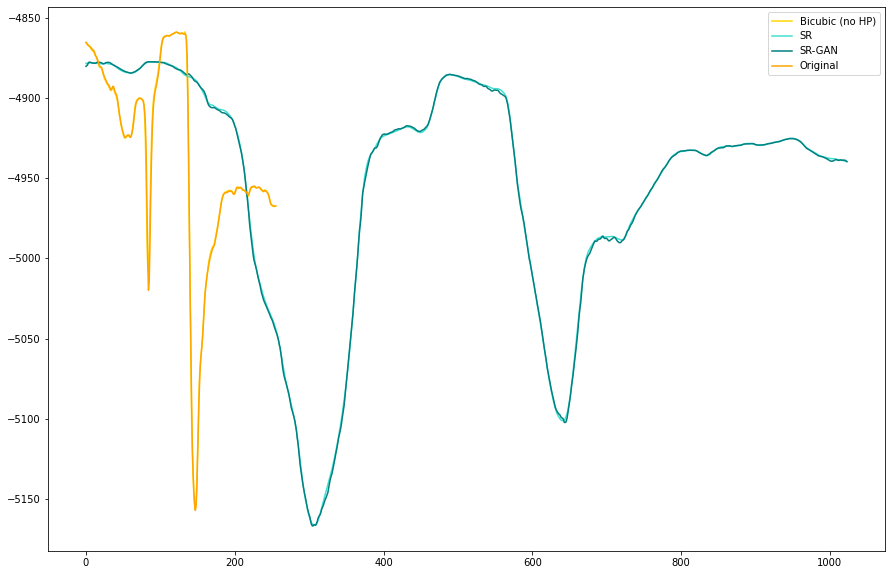

In [129]:
plt.figure(figsize=(15,10))

plt.plot(np.array(bicubic_nohalfpixel_denorm)[10,150,:,0], label='Bicubic (no HP)', color='gold')
plt.plot(np.array(tf.squeeze(SR_pred_denorm))[10,150,:,0], label='SR', color='turquoise')
plt.plot(np.array(tf.squeeze(SRGAN_pred_denorm))[10,150,:,0], label='SR-GAN', color='teal')
plt.plot(np.array(hr_denorm)[10,150,:,0], label='Original', color='orange')
plt.legend()

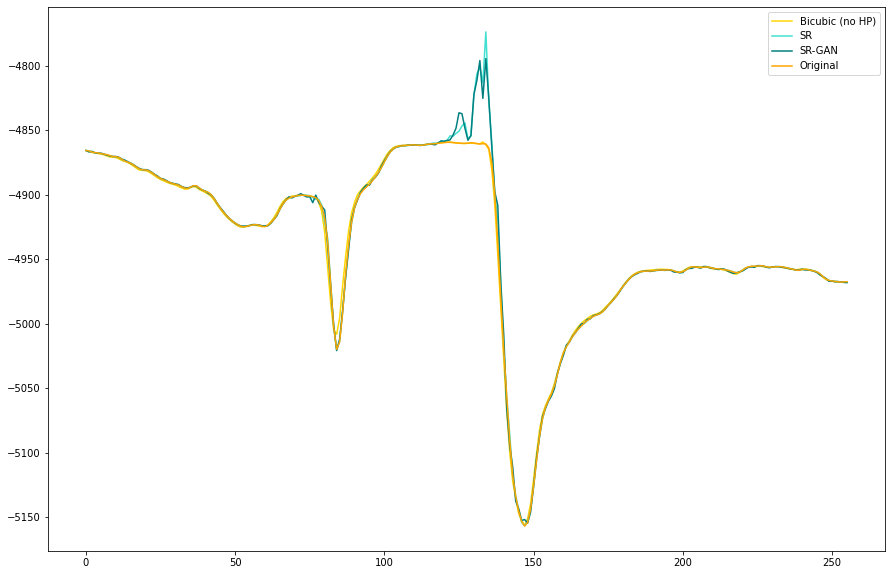

In [ ]:
plt.figure(figsize=(15,10))

plt.plot(np.array(bicubic_nohalfpixel_denorm)[10,150,:,0], label='Bicubic (no HP)', color='gold')
plt.plot(np.array(tf.squeeze(SR_pred_denorm))[10,150,:,0], label='SR', color='turquoise')
plt.plot(np.array(tf.squeeze(SRGAN_pred_denorm))[10,150,:,0], label='SR-GAN', color='teal')
plt.plot(np.array(hr_denorm)[10,150,:,0], label='Original', color='orange')
plt.legend()

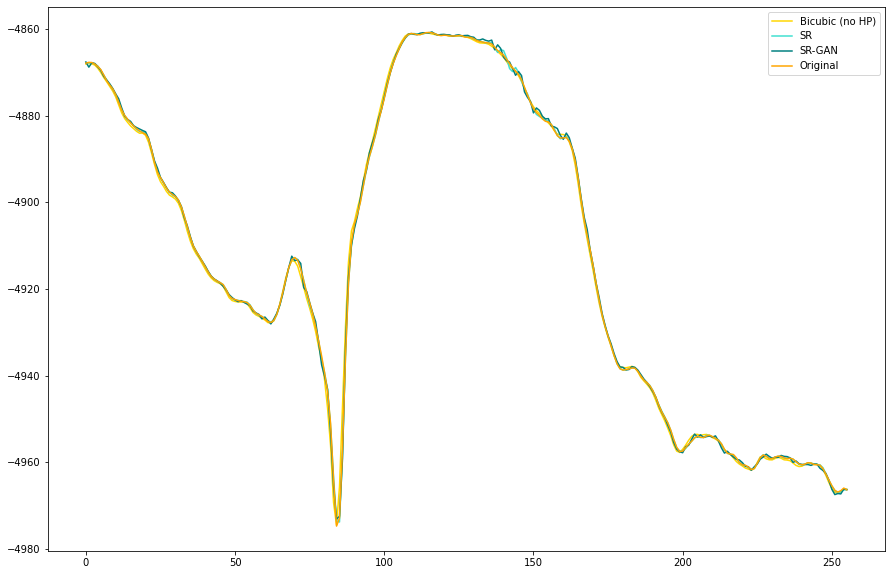

In [74]:
plt.figure(figsize=(15,10))

plt.plot(np.array(bicubic_nohalfpixel_denorm)[10,180,:,0], label='Bicubic (no HP)', color='gold')
plt.plot(np.array(tf.squeeze(SR_pred_denorm))[10,180,:,0], label='SR', color='turquoise')
plt.plot(np.array(tf.squeeze(SRGAN_pred_denorm))[10,180,:,0], label='SR-GAN', color='teal')
plt.plot(np.array(hr_denorm)[10,180,:,0], label='Original', color='orange')
plt.legend()